<a href="https://colab.research.google.com/github/tchaase/cVAE_autism/blob/main/code/cVAE_autism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contrastive Variational Autoencoder for the ABIDE Data Set

Author - Tobias Haase

## Set-Up

Firstly I am importaing the necessary modules here, that I will use within the following.



In [2]:
import torch  # The main PyTorch library for tensor computations and neural network operations

import torch.nn as nn  # Provides various neural network layers and functionalities
import torch.nn.functional as F  # Provides functional interfaces to common operations (e.g., activation functions)
import torch.optim as optim  # Contains various optimization algorithms (e.g., SGD, Adam)

import torchvision  # A PyTorch library for computer vision tasks
import torchvision.transforms as transforms  # Provides common image transformations (e.g., resizing, normalization)
from torchvision.transforms import ToTensor  # Transforms PIL images to tensors
from torch.utils.data import Dataset, DataLoader  # Provides tools for creating custom datasets and data loaders
import torch.nn as nn

import numpy as np  # NumPy library for numerical computations and array operations
import matplotlib  # Matplotlib library for data visualization
import matplotlib.pyplot as plt  # Matplotlib's pyplot module for creating plots
from tqdm import tqdm  # Progress bar library for tracking iterations

import os
import requests
import nibabel as nib
import numpy as np
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cpu')

Now, it is very helpful to keep a set seed so my analyes are reproducible.

In [3]:
import random
import numpy as np
import torch

seed_value = 42

# Set seed for Python's random module
random.seed(seed_value)

# Set seed for NumPy
np.random.seed(seed_value)

# Set seed for PyTorch (CPU and CUDA)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Now all random operations in Python, NumPy, and PyTorch will be reproducible

And this to make my graphics all useable for later writing:

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Increase font size for all Matplotlib elements
mpl.rcParams['font.size'] = 14  # You can adjust the size as needed

# Optionally, you can increase the font size for specific elements:
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14


### Preparing and loading the data


Next, I am loading the project's data. To load the data there are multiple options - one is cyberduck. I deviated from using cyberduck as it was easier to figure out the links for other files via `urllib.request.urlretrieve`. However I am leaving the code here - but commenting it out.

Firstly, to use **CyberDuck**, one would need to install it:


In [ ]:
#!echo -e "deb https://s3.amazonaws.com/repo.deb.cyberduck.io stable main" | sudo tee /etc/apt/sources.list.d/cyberduck.list > /dev/null
#!sudo apt-key adv --keyserver keyserver.ubuntu.com --recv-keys FE7097963FEFBE72
#!sudo apt-get update
#!sudo apt-get install duck

#duck --username anonymous --verbose --download s3:/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/ants/anat_thickness/*_anat_thickness.nii.gz ./drive/MyDrive/MasterThesisData

As I want to use a specific atlas, I need to do the transformations myself. For this, I need access to the ANTs pipeline. Thankfully you can load it like below, as explained [here]( https://colab.research.google.com/drive/1g5cnZxj1llRaHmOs4xSglqsXnFkQYuol?usp=sharing#scrollTo=7J9SVgWtVD_D).

In [ ]:
import os
os.environ["LD_PRELOAD"] = "";
os.environ["APPTAINER_BINDPATH"] = "/content"
os.environ["LMOD_CMD"] = "/usr/share/lmod/lmod/libexec/lmod"

!curl -J -O https://raw.githubusercontent.com/NeuroDesk/neurocommand/main/googlecolab_setup.sh
!chmod +x googlecolab_setup.sh
!./googlecolab_setup.sh
os.environ["MODULEPATH"] = ':'.join(map(str, list(map(lambda x: os.path.join(os.path.abspath('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/'), x),os.listdir('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/')))))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3338  100  3338    0     0   9895      0 --:--:-- --:--:-- --:--:--  9875
^C


FileNotFoundError: ignored

Now I just load a version of ants!

In [ ]:
import lmod
await lmod.load('ants/2.3.5')

Next, I am mounting the drive so I can use it later to store the data.

In [ ]:
#!ls ./data/anat_thickness/
!rm -rf ./data

from google.colab import drive
drive.mount('/content/drive')


Now, its helpful to have the file with the participant info already.

In [ ]:
# URL to download the CSV file!
csv_url = "https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv"  # Replace with the actual URL

# Directory to store the CSV file
data_directory = "./data/participant_info"

# Create the directory if it does not exist
os.makedirs(data_directory, exist_ok=True)

# File path to save the CSV file
csv_file_path = os.path.join(data_directory, "participant_info.csv")

# Download the CSV file
response = requests.get(csv_url)
if response.status_code == 200:
    with open(csv_file_path, "wb") as f:
        f.write(response.content)
    print("CSV file downloaded successfully.")
else:
    print("Failed to download the CSV file.")


CSV file downloaded successfully.


To get the data transformed later I will also need a template. This is loaded here!

In [ ]:
!pip install templateflow
from templateflow import api as tflow
mni152 = tflow.get('MNI152NLin2009cAsym', desc=None, resolution=1,
                    suffix='T1w', extension='nii.gz')
mni152_path = str(mni152)

Now that we have the template, the pipelines we can actually load the data. But first let's define the relevant directories.

In [ ]:
#!pip install ants
!pip install nipype

import pandas as pd
import os
import shutil
import urllib.request
from nipype.interfaces.ants import ApplyTransforms

# Define paths
data_directory = "./data/participant_info"
transformed_directory = './drive/MyDrive/MasterThesisData/transformed'
temp_directory = '/content/temp_data'  # Temporary directory

# Create directories if they don't exist
os.makedirs(transformed_directory, exist_ok=True)
os.makedirs(temp_directory, exist_ok=True)

# Load the CSV file
csv_file_path = os.path.join(data_directory, "participant_info.csv")
data = pd.read_csv(csv_file_path)
participant_info = data
failed_download = []

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.5 MB/s eta 0:00:00


Let's attempt this with one participant and see if it works.

In [ ]:
sub_id = "50003"

try:
    # Construct the MRI data file name
    mri_data_file = f"{file_id}_anat_thickness.nii.gz"
    mri_data_path = os.path.join(temp_directory, mri_data_file)

    # Download the MRI data file to the temporary directory
    mri_url = f"https://fcp-indi.s3.amazonaws.com/data/Projects/ABIDE/Outputs/mindboggle_swf/mindboggle/ants_subjects/sub-00{sub_id}/antsCorticalThickness.nii.gz"
    urllib.request.urlretrieve(mri_url, mri_data_path)

    # Construct the transformation template file name
    template_file_name = f'sub-00{sub_id}_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5'
    template_destination = os.path.join(temp_directory, template_file_name)

    # Download the transformation template
    template_url = f"https://fcp-indi.s3.amazonaws.com/data/Projects/ABIDE/Outputs/fmriprep/fmriprep/sub-00{sub_id}/anat/{template_file_name}"
    urllib.request.urlretrieve(template_url, template_destination)

    # Define paths for the transformed output
    transformed_output_path = os.path.join(transformed_directory, f"sub-00{sub_id}_space-MNI152NLin2009cAsym_desc-corticalthickness.nii.gz")

    from nipype import config, logging
    from nipype.interfaces.base import CommandLine

    # Set the execution plugin to CommandLine
    config.enable_debug_mode()
    config.enable_provenance()
    logging.update_logging(config)

    # Define the antsApplyTransforms interface
    at = ApplyTransforms()
    at.inputs.input_image = mri_data_path
    at.inputs.reference_image = mni152_path
    at.inputs.transforms = template_destination
    at.inputs.output_image = transformed_output_path

    # Execute the antsApplyTransforms command
    cmdline = at.cmdline
    cl = CommandLine(command=cmdline)
    cl.run()

    # Clean up: Delete the input data and template
    !rm /content/temp_data/*

    print(f"Transformed and saved for FILE_ID: {file_id}")

except Exception as e:
    print(f"Failed for FILE_ID: {file_id}. Error: {e}")


Great! Now onto all the other participants.

In [ ]:
for index, row in data.iterrows():
    file_id = row['FILE_ID']
    sub_id = row['SUB_ID']

    try:
        # Construct the MRI data file name
        mri_data_file = f"{file_id}_anat_thickness.nii.gz"
        mri_data_path = os.path.join(temp_directory, mri_data_file)

        # Download the MRI data file to the temporary directory
        mri_url = f"https://fcp-indi.s3.amazonaws.com/data/Projects/ABIDE/Outputs/mindboggle_swf/mindboggle/ants_subjects/sub-00{sub_id}/antsCorticalThickness.nii.gz"
        urllib.request.urlretrieve(mri_url, mri_data_path)

        # Construct the transformation template file name
        template_file_name = f'sub-00{sub_id}_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5'
        template_destination = os.path.join(temp_directory, template_file_name)

        # Download the transformation template
        template_url = f"https://fcp-indi.s3.amazonaws.com/data/Projects/ABIDE/Outputs/fmriprep/fmriprep/sub-00{sub_id}/anat/{template_file_name}"
        urllib.request.urlretrieve(template_url, template_destination)

        # Define paths for the transformed output
        transformed_output_path = os.path.join(transformed_directory, f"sub-00{sub_id}_space-MNI152NLin2009cAsym_desc-corticalthickness.nii.gz")

        from nipype import config, logging
        from nipype.interfaces.base import CommandLine

        # Set the execution plugin to CommandLine
        config.enable_debug_mode()
        config.enable_provenance()
        logging.update_logging(config)

        # Define the antsApplyTransforms interface
        at = ApplyTransforms()
        at.inputs.input_image = mri_data_path
        at.inputs.reference_image = mni152_path
        at.inputs.transforms = template_destination
        at.inputs.output_image = transformed_output_path

        # Execute the antsApplyTransforms command
        cmdline = at.cmdline
        cl = CommandLine(command=cmdline)
        cl.run()

        # Clean up: Delete the input data and template
        !rm "./temp_data/*"

        print(f"Transformed and saved for FILE_ID: {file_id}")

    except Exception as e:
        print(f"Failed for FILE_ID: {file_id}. Error: {e}")

print("Processing completed.")


Now, I need to actually apply the atlas. In this step I am loading the atlas and the corresponding labels.

In [ ]:
# Load the atlas
!pip install nilearn
from nilearn.datasets import fetch_atlas_destrieux_2009
from nilearn.image import load_img

atlas_destrieux_dataset = fetch_atlas_destrieux_2009(lateralized = True)
atlas_destrieux = load_img(atlas_destrieux_dataset.maps)

# From this, we can also export the labels that we can use for later visualization.
labels = atlas_destrieux_dataset.labels



We can now use the niftilabelmasker to actually apply the mask. Of course I should use a loop here later!

In [ ]:
from nilearn.maskers import NiftiLabelsMasker

masker_destrieux = NiftiLabelsMasker(labels_img=atlas_destrieux)

thickness_data_dict = {}

for filename in os.listdir(transformed_directory):
    if filename.endswith("_desc-corticalthickness.nii.gz"):
        sub_id = filename.split("_")[0].replace("sub-", "")
        thickness_filename = f"thickness_{sub_id}"

        thickness_data = masker_destrieux.fit_transform(os.path.join(transformed_directory, filename))

        thickness_data_dict[sub_id] = {
            "sub_id": sub_id,
            "data": thickness_data
        }

        print(f"Processed for sub_id: {sub_id}")


In a next step I will use this data to create dictionaries containing all the data, as well as the labels that will be used for training.

In [ ]:
# Read the participant information from the CSV file
csv_file = "./data/participant_info/participant_info.csv"
participant_info_df = pd.read_csv(csv_file)

# Create dictionaries to store data and participant information for autism and non-autism participants
data_info_dict_autism = {}
data_info_dict_no_autism = {}

# Loop through the thickness data dictionary
for sub_id, thickness_data_entry in thickness_data_dict.items():
    # Find the participant's information based on SUB_ID
    participant_row = participant_info_df.loc[participant_info_df['SUB_ID'] == int(sub_id)]
    if not participant_row.empty:
        # Extract age, gender, dx_group, and diag_group from the participant's information
        age = participant_row['AGE_AT_SCAN'].values[0]
        gender = participant_row['SEX'].values[0] - 1
        dx_group = participant_row['DX_GROUP'].values[0]
        diag_group = participant_row['DSM_IV_TR'].values[0]

        # Convert data to a NumPy array if needed
        thickness_data_array = np.array(thickness_data_entry['data'])

        # Create a data entry for the sub ID
        data_entry = {
            "data": thickness_data_array,
            "age": age,
            "gender": gender,
            "diag_group": diag_group
        }

        # Store the data and participant information in the appropriate dictionary based on DX_GROUP
        if dx_group == 1:
            data_info_dict_autism[sub_id] = data_entry
        elif dx_group == 2:
            data_info_dict_no_autism[sub_id] = data_entry
    else:
        print(f"No participant information found for sub_id: {sub_id}")

total_length = len(data_info_dict_autism) + len(data_info_dict_no_autism)
print(f"Total length of combined dictionaries: {total_length}")


Now, I also see how many files the dictionaries contain. Does this match with the overall number of files?

In [ ]:
! cd ./data & du -a | cut -d/ -f2 | sort | uniq -c | sort -nr

Let's check if this all worked:

In [1]:
# Calculate overall statistics for the autism category
autism_data_lengths = [len(info["data"]) for info in data_info_dict_autism.values()]
total_autism_samples = len(autism_data_lengths)
average_autism_data_length = sum(autism_data_lengths) / total_autism_samples
min_autism_data_length = min(autism_data_lengths)
max_autism_data_length = max(autism_data_lengths)
std_autism_data_length = np.std(autism_data_lengths)
autism_ages = [info["age"] for info in data_info_dict_autism.values()]
average_autism_age = sum(autism_ages) / total_autism_samples
min_autism_age = min(autism_ages)
max_autism_age = max(autism_ages)
std_autism_age = np.std(autism_ages)
autism_genders = [info["gender"] for info in data_info_dict_autism.values()]
# Calculate gender counts for the autism category
autism_male_count = autism_genders.count(0)
autism_female_count = autism_genders.count(1)

# Calculate overall statistics for the non-autism category
non_autism_data_lengths = [len(info["data"]) for info in data_info_dict_no_autism.values()]
total_non_autism_samples = len(non_autism_data_lengths)
average_non_autism_data_length = sum(non_autism_data_lengths) / total_non_autism_samples
min_non_autism_data_length = min(non_autism_data_lengths)
max_non_autism_data_length = max(non_autism_data_lengths)
std_non_autism_data_length = np.std(non_autism_data_lengths)
non_autism_ages = [info["age"] for info in data_info_dict_no_autism.values()]
average_non_autism_age = sum(non_autism_ages) / total_non_autism_samples
min_non_autism_age = min(non_autism_ages)
max_non_autism_age = max(non_autism_ages)
std_non_autism_age = np.std(non_autism_ages)
non_autism_genders = [info["gender"] for info in data_info_dict_no_autism.values()]
# Calculate gender counts for the non-autism category
non_autism_male_count = non_autism_genders.count(0)
non_autism_female_count = non_autism_genders.count(1)





# Print the statistics for the autism category
print("Autism Data Statistics:")
print("Total Samples:", total_autism_samples)
print("Average Data Length:", average_autism_data_length)
print("Minimum Data Length:", min_autism_data_length)
print("Maximum Data Length:", max_autism_data_length)
print("Standard Deviation of Data Length:", std_autism_data_length)
print("")

print("Autism Age Statistics:")
print("Average Age:", average_autism_age)
print("Minimum Age:", min_autism_age)
print("Maximum Age:", max_autism_age)
print("Standard Deviation of Age:", std_autism_age)
print("")

print("Autism Gender Counts:")
print("Male Count:", autism_male_count)
print("Female Count:", autism_female_count)
print("")

# Print the statistics for the non-autism category
print("Non-Autism Data Statistics:")
print("Total Samples:", total_non_autism_samples)
print("Average Data Length:", average_non_autism_data_length)
print("Minimum Data Length:", min_non_autism_data_length)
print("Maximum Data Length:", max_non_autism_data_length)
print("Standard Deviation of Data Length:", std_non_autism_data_length)
print("")

print("Non-Autism Age Statistics:")
print("Average Age:", average_non_autism_age)
print("Minimum Age:", min_non_autism_age)
print("Maximum Age:", max_non_autism_age)
print("Standard Deviation of Age:", std_non_autism_age)
print("")

print("Non-Autism Gender Counts:")
print("Male Count:", non_autism_male_count)
print("Female Count:", non_autism_female_count)


NameError: ignored

Now, as this seems to have worked, it seems wise to store the dictionary at this point.

In [ ]:
if isinstance(data_info_dict_autism, dict):
    print("data_info_dict_autism is a dictionary.")
else:
    print("data_info_dict_autism is not a dictionary.")

if isinstance(data_info_dict_no_autism, dict):
    print("data_info_dict_no_autism is a dictionary.")
else:
    print("data_info_dict_no_autism is not a dictionary.")


In [ ]:
import json
import os
import numpy as np

# Specify the directory for saving JSON files
preprocessed_directory = '/content/drive/MyDrive/MasterThesisData/preprocessed'
os.makedirs(preprocessed_directory, exist_ok=True)

# Paths for the JSON files
autism_json_path = os.path.join(preprocessed_directory, "data_info_dict_autism.json")
no_autism_json_path = os.path.join(preprocessed_directory, "data_info_dict_no_autism.json")

# Convert NumPy arrays to Python lists for serialization
def numpy_array_to_list(arr):
    return arr.tolist()

# Save data_info_dict_autism as JSON
with open(autism_json_path, "w") as json_file:
    json.dump(data_info_dict_autism, json_file, default=numpy_array_to_list)

# Save data_info_dict_no_autism as JSON
with open(no_autism_json_path, "w") as json_file:
    json.dump(data_info_dict_no_autism, json_file, default=numpy_array_to_list)

print("Data dictionaries saved as JSON files.")




### Reloading the data

Execute the following to **load** the data.

In [5]:
import json

from google.colab import drive
drive.mount('/content/drive')

preprocessed_directory = '/content/drive/MyDrive/MasterThesisData/preprocessed'

autism_json_path = os.path.join(preprocessed_directory, "data_info_dict_autism.json")
no_autism_json_path = os.path.join(preprocessed_directory, "data_info_dict_no_autism.json")

# Load dictionaries from JSON files
def load_dict_from_json(json_path):
    with open(json_path, "r") as json_file:
        loaded_dict = json.load(json_file)
    return loaded_dict

# Load data_info_dict_autism from JSON
loaded_data_info_dict_autism = load_dict_from_json(autism_json_path)
# Convert nested lists back to NumPy arrays
for key in loaded_data_info_dict_autism:
    loaded_data_info_dict_autism[key]["data"] = np.array(loaded_data_info_dict_autism[key]["data"])

# Load data_info_dict_no_autism from JSON
loaded_data_info_dict_no_autism = load_dict_from_json(no_autism_json_path)
# Convert nested lists back to NumPy arrays
for key in loaded_data_info_dict_no_autism:
    loaded_data_info_dict_no_autism[key]["data"] = np.array(loaded_data_info_dict_no_autism[key]["data"])



# URL to download the CSV file!
csv_url = "https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv"  # Replace with the actual URL

# Directory to store the CSV file
data_directory = "./data/participant_info"

# Create the directory if it does not exist
os.makedirs(data_directory, exist_ok=True)

# File path to save the CSV file
csv_file_path = os.path.join(data_directory, "participant_info.csv")

# Download the CSV file
response = requests.get(csv_url)
if response.status_code == 200:
    with open(csv_file_path, "wb") as f:
        f.write(response.content)
    print("CSV file downloaded successfully.")
else:
    print("Failed to download the CSV file.")

participant_info = pd.read_csv(csv_file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CSV file downloaded successfully.


If this looks good also load this:

In [6]:
data_info_dict_autism = loaded_data_info_dict_autism
data_info_dict_no_autism = loaded_data_info_dict_no_autism

import numpy as np

# Reshape "data" arrays within data_info_dict_autism
for key in data_info_dict_autism:
    data_info_dict_autism[key]["data"] = data_info_dict_autism[key]["data"].reshape(-1)

# Reshape "data" arrays within data_info_dict_no_autism
for key in data_info_dict_no_autism:
    data_info_dict_no_autism[key]["data"] = data_info_dict_no_autism[key]["data"].reshape(-1)


Next, I need to create a dataloader. But before I can use the actual dataloader, I want to stratify the data to ensure that the several data sets are comparable.

In [8]:
variables_of_interest = ['ADOS_TOTAL', 'ADOS_SOCIAL', 'DSM_IV_TR', 'FIQ']

# Loop through the participant IDs in data_info_dict_autism
for sub_id, data_entry in list(data_info_dict_autism.items()):
    sub_id_with_0 = sub_id
    # Remove the leading two zeroes
    sub_id = sub_id.lstrip('0')

    # Find the participant's information based on SUB_ID
    participant_row = participant_info.loc[participant_info['SUB_ID'] == int(sub_id)]
    if not participant_row.empty:
        # Extract covariate values from the participant's information
        for covariate in variables_of_interest:  # Exclude the first two covariates
            if covariate in participant_row:
                covariate_value = participant_row[covariate].values[0]
                # Check if the covariate value is either nonexistent or -9999
                if pd.isna(covariate_value) or covariate_value == -9999:
                    covariate_value = float('nan')
                    data_entry[covariate] = covariate_value
                else:
                    data_entry[covariate] = covariate_value
            else:
                print(f"No data found for covariate: {covariate} for sub_id: {sub_id}")
    else:
        print(f"No participant information found for sub_id: {sub_id}")

# Repeat the same process for data_info_dict_no_autism
for sub_id, data_entry in list(data_info_dict_no_autism.items()):
    sub_id_with_0 = sub_id
    # Remove the leading two zeroes
    sub_id = sub_id.lstrip('0')

    # Find the participant's information based on SUB_ID
    participant_row = participant_info.loc[participant_info['SUB_ID'] == int(sub_id)]
    if not participant_row.empty:
        # Extract covariate values from the participant's information
        for covariate in variables_of_interest[3:]:  # Exclude the first two covariates
            if covariate in participant_row:
                covariate_value = participant_row[covariate].values[0]
                # Check if the covariate value is either nonexistent or -9999
                if pd.isna(covariate_value) or covariate_value == -9999:
                    covariate_value = float('nan')
                    data_entry[covariate] = covariate_value
                else:
                    data_entry[covariate] = covariate_value
            else:
                print(f"No data found for covariate: {covariate} for sub_id: {sub_id}")
    else:
        print(f"No participant information found for sub_id: {sub_id}")


Next, I am stratifiyng by gender to ensure the test, validation and training data set contain an equal distribution of the genders.

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import pandas as pd

# Create labels for stratification based on gender for autism data
autism_labels = []
for sub_id in data_info_dict_autism.keys():
    gender = data_info_dict_autism[sub_id]["gender"]
    label = f"{gender}"
    autism_labels.append(label)

# Create a DataFrame from autism_labels
df_autism_labels = pd.DataFrame({'autism_labels': autism_labels})
# Get counts of each unique combination
label_counts_autism = df_autism_labels['autism_labels'].value_counts()
# Create a table of combinations and their counts for autism_labels
combinations_table_autism = pd.DataFrame({'Combination': label_counts_autism.index, 'Count': label_counts_autism.values})
# Print the table for autism_labels
print("Combinations Table for Autism Labels:")
print(combinations_table_autism)

# Create labels for stratification based on gender for no-autism data
no_autism_labels = []
for sub_id in data_info_dict_no_autism.keys():
    gender = data_info_dict_no_autism[sub_id]["gender"]
    label = f"{gender}"
    no_autism_labels.append(label)

# Create a DataFrame from no_autism_labels
df_no_autism_labels = pd.DataFrame({'no_autism_labels': no_autism_labels})
# Get counts of each unique combination
label_counts_no_autism = df_no_autism_labels['no_autism_labels'].value_counts()
# Create a table of combinations and their counts for no_autism_labels
combinations_table_no_autism = pd.DataFrame({'Combination': label_counts_no_autism.index, 'Count': label_counts_no_autism.values})
# Print the table for no_autism_labels
print("\nCombinations Table for No-Autism Labels:")
print(combinations_table_no_autism)

# Perform stratified sampling separately for autism and no-autism data
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.6, random_state=42)

# Split autism data into train, validation, and test sets
for train_index, test_index in stratified_splitter.split(data_info_dict_autism, autism_labels):
    autism_train_set = {sub_id: data_info_dict_autism[sub_id] for i, sub_id in enumerate(data_info_dict_autism) if i in train_index}
    autism_test_temp_set = {sub_id: data_info_dict_autism[sub_id] for i, sub_id in enumerate(data_info_dict_autism) if i in test_index}

# Further split autism test set into validation and test sets
stratified_splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for val_index, test_index in stratified_splitter2.split(autism_test_temp_set, [autism_labels[i] for i in test_index]):
    autism_validation_set = {sub_id: autism_test_temp_set[sub_id] for i, sub_id in enumerate(autism_test_temp_set) if i in val_index}
    autism_test_set = {sub_id: autism_test_temp_set[sub_id] for i, sub_id in enumerate(autism_test_temp_set) if i in test_index}

# Split no-autism data into train, validation, and test sets
for train_index, test_index in stratified_splitter.split(data_info_dict_no_autism, no_autism_labels):
    no_autism_train_set = {sub_id: data_info_dict_no_autism[sub_id] for i, sub_id in enumerate(data_info_dict_no_autism) if i in train_index}
    no_autism_test_temp_set = {sub_id: data_info_dict_no_autism[sub_id] for i, sub_id in enumerate(data_info_dict_no_autism) if i in test_index}

# Further split no-autism test set into validation and test sets
for val_index, test_index in stratified_splitter2.split(no_autism_test_temp_set, [no_autism_labels[i] for i in test_index]):
    no_autism_validation_set = {sub_id: no_autism_test_temp_set[sub_id] for i, sub_id in enumerate(no_autism_test_temp_set) if i in val_index}
    no_autism_test_set = {sub_id: no_autism_test_temp_set[sub_id] for i, sub_id in enumerate(no_autism_test_temp_set) if i in test_index}

# Now you have separate training, validation, and test sets for autism and no-autism data stratified by gender.


Combinations Table for Autism Labels:
  Combination  Count
0           0    404
1           1     63

Combinations Table for No-Autism Labels:
  Combination  Count
0           0    423
1           1     97


Now that I have loaded all the covariates, in addition to the normal data, lets create a corresponding dataset, that we can use for stratification.

In [10]:
class CombinedDataset(Dataset):
    def __init__(self, autism_data_info, no_autism_data_info):
        self.autism_data_info = autism_data_info
        self.no_autism_data_info = no_autism_data_info
        self.autism_file_ids = list(self.autism_data_info.keys())
        self.no_autism_file_ids = list(self.no_autism_data_info.keys())

    def __len__(self):
        return max(len(self.autism_file_ids), len(self.no_autism_file_ids))

    def __getitem__(self, index):
        autism_index = index % len(self.autism_file_ids)
        no_autism_index = index % len(self.no_autism_file_ids)

        autism_file_id = self.autism_file_ids[autism_index]
        no_autism_file_id = self.no_autism_file_ids[no_autism_index]

        autism_data = torch.tensor(self.autism_data_info[autism_file_id]["data"], dtype=torch.float32)
        autism_age = torch.tensor(self.autism_data_info[autism_file_id]["age"], dtype=torch.float32)
        autism_gender = torch.tensor(self.autism_data_info[autism_file_id]["gender"], dtype=torch.int32)
        autism_diag_group = torch.tensor(self.autism_data_info[autism_file_id]["diag_group"], dtype=torch.float32)

        no_autism_data = torch.tensor(self.no_autism_data_info[no_autism_file_id]["data"], dtype=torch.float32)
        no_autism_age = torch.tensor(self.no_autism_data_info[no_autism_file_id]["age"], dtype=torch.float32)
        no_autism_gender = torch.tensor(self.no_autism_data_info[no_autism_file_id]["gender"], dtype=torch.int32)
        no_autism_diag_group = torch.tensor(self.no_autism_data_info[no_autism_file_id]["diag_group"], dtype=torch.float32)

        # Extract additional covariates for both groups
        autism_ADOS_TOTAL = torch.tensor(self.autism_data_info[autism_file_id]["ADOS_TOTAL"], dtype=torch.float32)
        autism_ADOS_SOCIAL = torch.tensor(self.autism_data_info[autism_file_id]["ADOS_SOCIAL"], dtype=torch.float32)
        autism_DSM_IV_TR = torch.tensor(self.autism_data_info[autism_file_id]["DSM_IV_TR"])
        autism_FIQ = torch.tensor(self.autism_data_info[autism_file_id]["FIQ"], dtype=torch.float32)

        # Include sub ID here
        autism_sub_id = autism_file_id
        no_autism_sub_id = no_autism_file_id

        no_autism_FIQ = torch.tensor(self.no_autism_data_info[no_autism_file_id]["FIQ"], dtype=torch.float32)


        return (autism_data, autism_age, autism_FIQ, autism_diag_group, autism_ADOS_TOTAL, autism_ADOS_SOCIAL, autism_DSM_IV_TR, autism_gender, autism_sub_id), (no_autism_data, no_autism_age, no_autism_FIQ, no_autism_diag_group, no_autism_gender, no_autism_sub_id)

Next let's stratify the data.

In [11]:
from torch.utils.data import DataLoader

# Create instances of the CombinedDataset class
train_dataset = CombinedDataset(autism_train_set, no_autism_train_set)
val_dataset = CombinedDataset(autism_validation_set, no_autism_validation_set)
test_dataset = CombinedDataset(autism_test_set, no_autism_test_set)

# Define batch size for dataloaders
batch_size = 64

# Create DataLoaders for train, validation, and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# You can now use train_loader, validation_loader, and test_loader for training and evaluating your model.

train_dataloader_no_batch = DataLoader(train_dataset, batch_size= max(len(autism_train_set), len(no_autism_train_set)), shuffle=False)
val_dataloader_no_batch = DataLoader(val_dataset, batch_size= max(len(autism_validation_set), len(no_autism_validation_set)), shuffle=False)
test_dataloader_no_batch = DataLoader(test_dataset, batch_size= max(len(autism_test_set), len(no_autism_test_set)), shuffle=False)

Let's test this:

In [12]:
# Assuming you have already created your combined_dataloader
batch = next(iter(train_dataloader))

# Unpack the batch into separate variables
(autism_data, autism_age, autism_gender, autism_diag_group, _, _ ,_,_,_), (no_autism_data, no_autism_age, no_autism_gender, no_autism_diag_group, _, _) = batch

# Now you can inspect the shapes and values of the tensors
print("Autism Data:")
print("Shape:", autism_data.shape)
print("Age:", autism_age)
print("Gender:", autism_gender)
print("Diag Group:", autism_diag_group)

print("\nNo Autism Data:")
print("Shape:", no_autism_data.shape)
print("Age:", no_autism_age)
print("Gender:", no_autism_gender)
print("Diag Group:", no_autism_diag_group)


Autism Data:
Shape: torch.Size([64, 148])
Age: tensor([ 9.9900, 30.0000, 13.2800, 58.0000, 10.9100, 15.8000, 35.2000, 17.4000,
        17.0000, 22.4000, 18.0000, 13.9500, 24.4100, 11.3000,  8.5600, 12.8200,
        13.0000, 18.6000, 27.8100,  8.9199, 21.4800, 17.5300, 11.2000, 16.9900,
        28.5800, 14.7700, 27.6000, 24.0000, 21.0000, 16.4200,  9.3300, 35.2000,
        11.2628, 33.0000, 21.4800, 32.4500, 15.3300, 10.8700,  9.9500, 14.2000,
        13.5900, 17.0000, 15.1000, 15.0500, 14.2100, 31.0000, 14.9600, 22.2900,
        11.2700,  9.7400, 16.8000, 27.0000, 29.0000, 14.4200, 14.5300, 13.6700,
        13.3700, 18.9200, 14.0000, 21.5800, 20.0000, 16.9900, 12.0000, 13.0900])
Gender: tensor([128.0000,      nan,  91.0000, 129.0000,  87.0000, 129.5000,  81.0000,
        104.5000, 135.0000, 125.0000, 100.0000, 100.0000,  98.0000, 107.5000,
        105.0000, 102.0000,  95.0000, 108.0000, 100.0000, 111.0000, 128.0000,
        127.0000, 111.0000, 111.0000, 107.0000, 104.0000, 106.0000,   

We therefore need an weight. Else the accuracy will be very high, as the model will simply always predict "male", and the f1 score will be 0, as female will never be predicted. This is outlined [here](https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/)

## Dimensionality of the Data

Before I can go on and perform any analysis using machine learning, it is wise to first establish how many lower dimensional features exist within the data. I am performing a PCA within both groups, just on the cortical thickness data.

The PCA will be performed using the scikit-learn module.

When perfoming a PCA, matrix calculations will be performed. I cannot have the data in seperate vectors within seperate entries in a dictionary. So lets unpack them and put them into a Matrix.

In [ ]:
# Inspect dimensions of "data" arrays in each entry, checking if they are all correctly what I expect.
print("Autism Data Dimensions:")
for sub_id, entry in data_info_dict_autism.items():
    data_dim = entry["data"].shape
    if data_dim == (1, 148):
      pass
    else:
      print(f"Sub ID {sub_id}: {data_dim}")

print("\nNo Autism Data Dimensions:")
for sub_id, entry in data_info_dict_no_autism.items():
    data_dim = entry["data"].shape
    if data_dim == (1, 148):
      pass
    else:
      print(f"Sub ID {sub_id}: {data_dim}")

Autism Data Dimensions:

No Autism Data Dimensions:


Let's firstly get a general idea of how many components may be relevant:

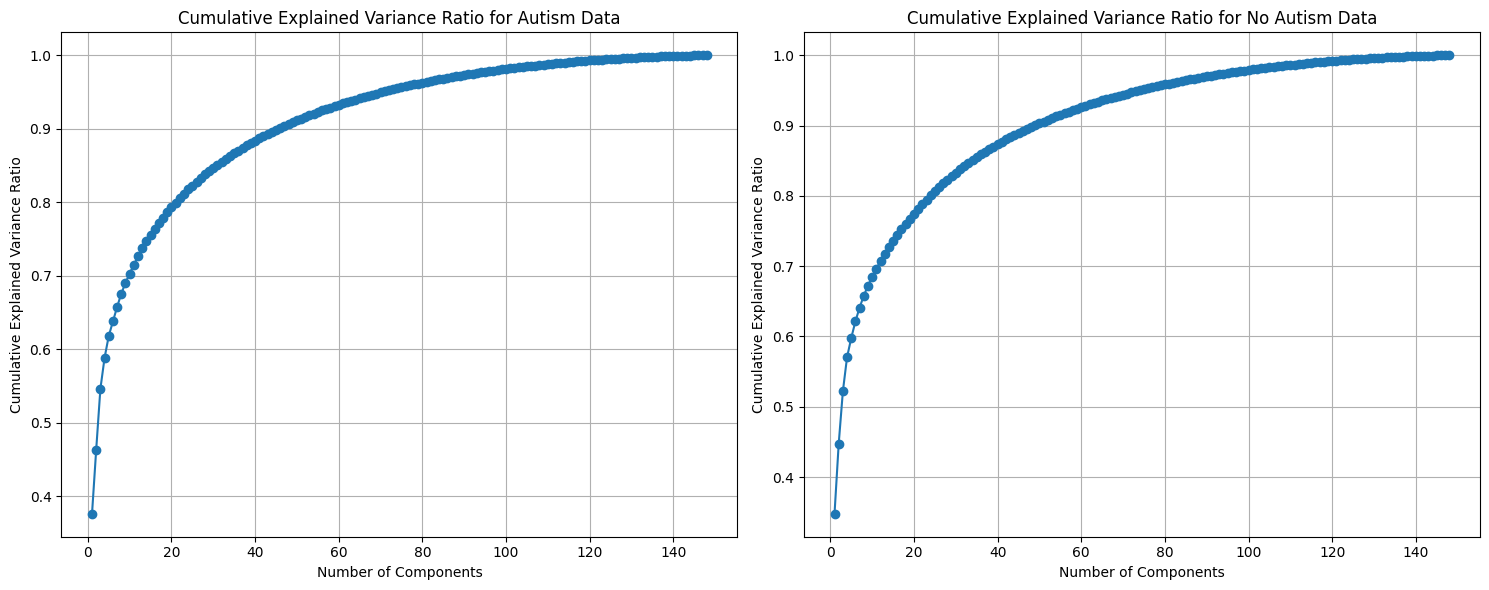

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Extract "data" arrays from data_info_dict_autism
autism_data_arrays = [entry["data"] for entry in data_info_dict_autism.values()]

# Extract "data" arrays from data_info_dict_no_autism
no_autism_data_arrays = [entry["data"] for entry in data_info_dict_no_autism.values()]

# Create a matrix by stacking the arrays for both groups
autism_data_matrix = np.vstack(autism_data_arrays)
no_autism_data_matrix = np.vstack(no_autism_data_arrays)

# Fit PCA for autism data
pca_autism = PCA()
pca_autism.fit(autism_data_matrix)

# Fit PCA for non autism data
pca_no_autism = PCA()
pca_no_autism.fit(no_autism_data_matrix)

# Calculate cumulative explained variance ratio for autism data
cumulative_explained_variance_autism = np.cumsum(pca_autism.explained_variance_ratio_)

# Calculate cumulative explained variance ratio for non autism data
cumulative_explained_variance_no_autism = np.cumsum(pca_no_autism.explained_variance_ratio_)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot cumulative explained variance ratio for autism data
axs[0].plot(range(1, len(cumulative_explained_variance_autism) + 1), cumulative_explained_variance_autism, marker='o')
axs[0].set_xlabel('Number of Components')
axs[0].set_ylabel('Cumulative Explained Variance Ratio')
axs[0].set_title('Cumulative Explained Variance Ratio for Autism Data')
axs[0].grid()

# Plot cumulative explained variance ratio for non autism data
axs[1].plot(range(1, len(cumulative_explained_variance_no_autism) + 1), cumulative_explained_variance_no_autism, marker='o')
axs[1].set_xlabel('Number of Components')
axs[1].set_ylabel('Cumulative Explained Variance Ratio')
axs[1].set_title('Cumulative Explained Variance Ratio for No Autism Data')
axs[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()


We see somewhat and elbow following the 4th component. However, one could also argue in favor of three components, as there is a stark decrease following this component. Let's inspect the option with four components.

Let's zoom in a little.

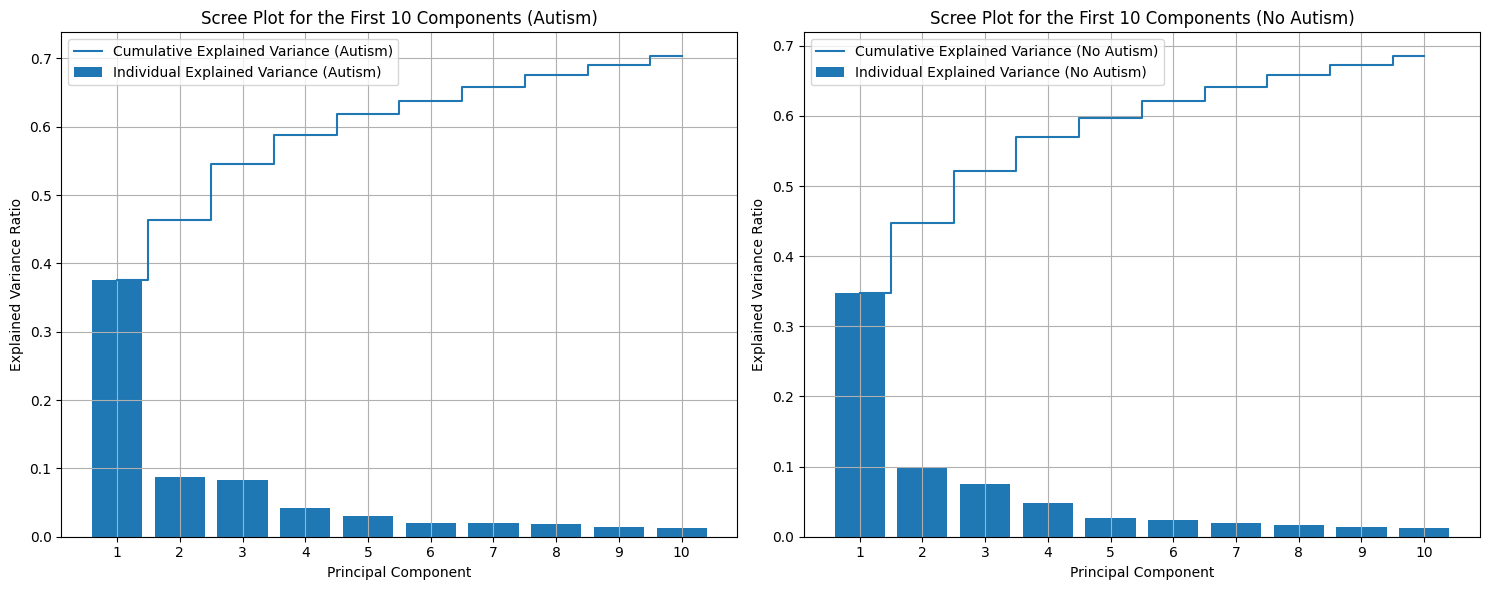

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Extract "data" arrays from data_info_dict_autism
autism_data_arrays = [entry["data"] for entry in data_info_dict_autism.values()]

# Extract "data" arrays from data_info_dict_no_autism
no_autism_data_arrays = [entry["data"] for entry in data_info_dict_no_autism.values()]

# Create a matrix by stacking the arrays for autism and non autism groups
autism_data_matrix = np.vstack(autism_data_arrays)
no_autism_data_matrix = np.vstack(no_autism_data_arrays)

# Fit PCA with the first 10 components for autism data
n_components = 10
pca_autism = PCA(n_components=n_components)
pca_autism.fit(autism_data_matrix)

# Fit PCA with the first 10 components for non autism data
pca_no_autism = PCA(n_components=n_components)
pca_no_autism.fit(no_autism_data_matrix)

# Scree plot for the first 10 components side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Autism data scree plot
explained_variance_autism = pca_autism.explained_variance_ratio_
cumulative_explained_variance_autism = np.cumsum(explained_variance_autism)

axs[0].bar(range(1, n_components + 1), explained_variance_autism, align='center', label='Individual Explained Variance (Autism)')
axs[0].step(range(1, n_components + 1), cumulative_explained_variance_autism, where='mid', label='Cumulative Explained Variance (Autism)')
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Explained Variance Ratio')
axs[0].set_title('Scree Plot for the First 10 Components (Autism)')
axs[0].set_xticks(range(1, n_components + 1))
axs[0].legend()
axs[0].grid()

# No Autism data scree plot
explained_variance_no_autism = pca_no_autism.explained_variance_ratio_
cumulative_explained_variance_no_autism = np.cumsum(explained_variance_no_autism)

axs[1].bar(range(1, n_components + 1), explained_variance_no_autism, align='center', label='Individual Explained Variance (No Autism)')
axs[1].step(range(1, n_components + 1), cumulative_explained_variance_no_autism, where='mid', label='Cumulative Explained Variance (No Autism)')
axs[1].set_xlabel('Principal Component')
axs[1].set_ylabel('Explained Variance Ratio')
axs[1].set_title('Scree Plot for the First 10 Components (No Autism)')
axs[1].set_xticks(range(1, n_components + 1))
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


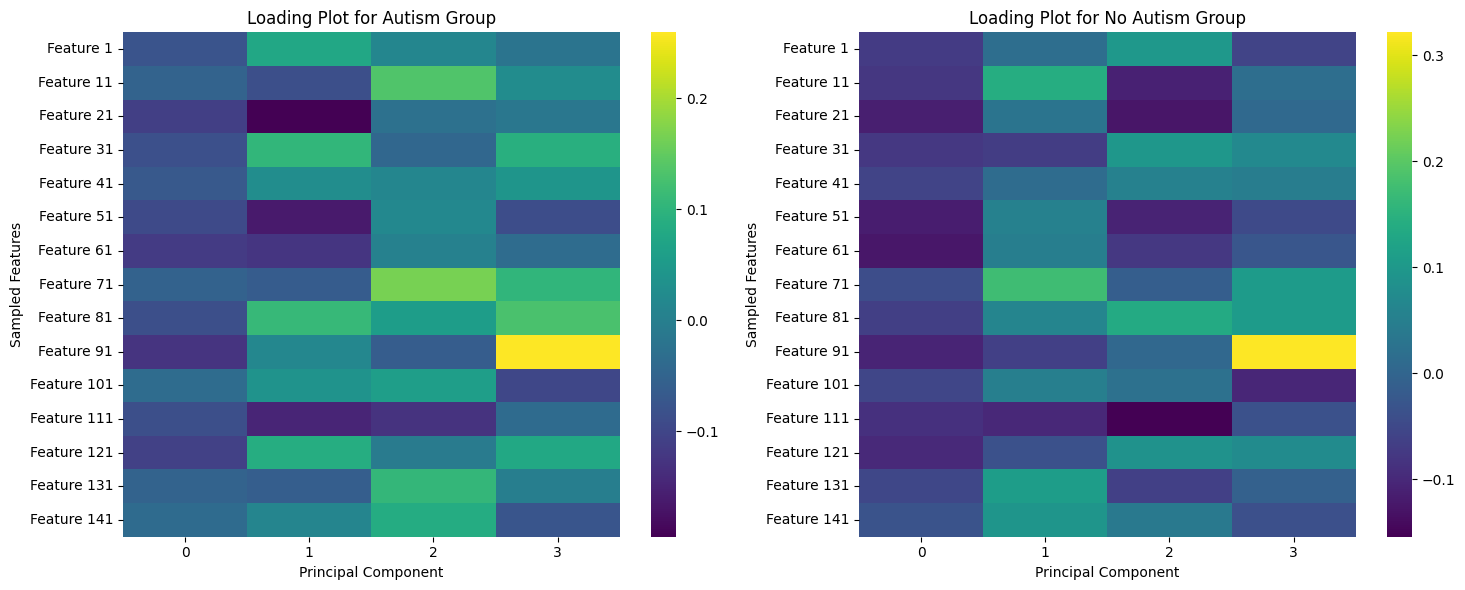

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Extract "data" arrays from dictionaries
autism_data_arrays = [entry["data"] for entry in data_info_dict_autism.values()]
no_autism_data_arrays = [entry["data"] for entry in data_info_dict_no_autism.values()]

# Convert arrays into matrices
autism_data_matrix = np.vstack(autism_data_arrays)
no_autism_data_matrix = np.vstack(no_autism_data_arrays)

# Specify the desired number of features
num_desired_features = 4  # You can adjust this number

# Create PCA instances for both groups
pca_autism = PCA(n_components=num_desired_features)
pca_no_autism = PCA(n_components=num_desired_features)

# Fit and transform "data" arrays for both groups
pca_autism_result = pca_autism.fit_transform(autism_data_matrix)
pca_no_autism_result = pca_no_autism.fit_transform(no_autism_data_matrix)

# Sample a subset of features for plotting (e.g., every 10th feature)
sampled_features_indices = np.arange(0, autism_data_matrix.shape[1], step=10)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Loading plot for autism group
sns.heatmap(pca_autism.components_.T[sampled_features_indices], cmap='viridis', yticklabels=['Feature {}'.format(i+1) for i in sampled_features_indices], ax=axs[0])
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Sampled Features')
axs[0].set_title('Loading Plot for Autism Group')

# Loading plot for no autism group
sns.heatmap(pca_no_autism.components_.T[sampled_features_indices], cmap='viridis', yticklabels=['Feature {}'.format(i+1) for i in sampled_features_indices], ax=axs[1])
axs[1].set_xlabel('Principal Component')
axs[1].set_ylabel('Sampled Features')
axs[1].set_title('Loading Plot for No Autism Group')

# Adjust layout
plt.tight_layout()
plt.show()


It is interesting to see that the second and third component have a different loading pattern.

In [ ]:
#Find the number of components where cumulative explained variance falls under 1
# Find the number of components to explain 80% of the variance
num_components_80_percent_autism = np.argmax(cumulative_explained_variance_autism >= 0.80) + 1
num_components_80_percent_no_autism = np.argmax(cumulative_explained_variance_no_autism >= 0.80) + 1

# Get the eigenvalues of the first 4 components for both groups
eigenvalues_autism = pca_autism.explained_variance_[:4]
eigenvalues_no_autism = pca_no_autism.explained_variance_[:4]

# Print the eigenvalues
print(f"Number of components for Autism Group where cumulative explained variance falls under 1: {num_components_80_percent_autism}")
print("Eigenvalues for Autism Group:")
for i, eigenvalue in enumerate(eigenvalues_autism):
    print(f"Component {i+1}: {eigenvalue:.4f}")


print(f"\nNumber of components for No Autism Group where cumulative explained variance falls under 1: {num_components_80_percent_no_autism}")
print("Eigenvalues for No Autism Group:")
for i, eigenvalue in enumerate(eigenvalues_no_autism):
    print(f"Component {i+1}: {eigenvalue:.4f}")


Number of components for Autism Group where cumulative explained variance falls under 1: 46
Eigenvalues for Autism Group:
Component 1: 11.2743
Component 2: 2.6192
Component 3: 2.4748
Component 4: 1.2665

Number of components for No Autism Group where cumulative explained variance falls under 1: 49
Eigenvalues for No Autism Group:
Component 1: 8.8548
Component 2: 2.5343
Component 3: 1.9057
Component 4: 1.2358


Based on this, the eigenvalues for the 4th component are still above 1 in both groups. According to Kaiser's criterium, one could already choose at least 4. The screeplot suggests 3 or 4 components. The original publication used 2 components, I am going to use 4 components per sample. Here is the reasoning:

I expect the non-linear nature of the model to work better with less dimensions. Introducing an additional classifier and more information later however, will likely benefit from more latent variables.

In particular, the introduction of gender and age may lead to two of the latent variables to be optimized to represent information of this nature. As to not underfit, I am therefore chosing 4 components for each of the autoencoders.

Number of components to explain 80% of the variance: 24


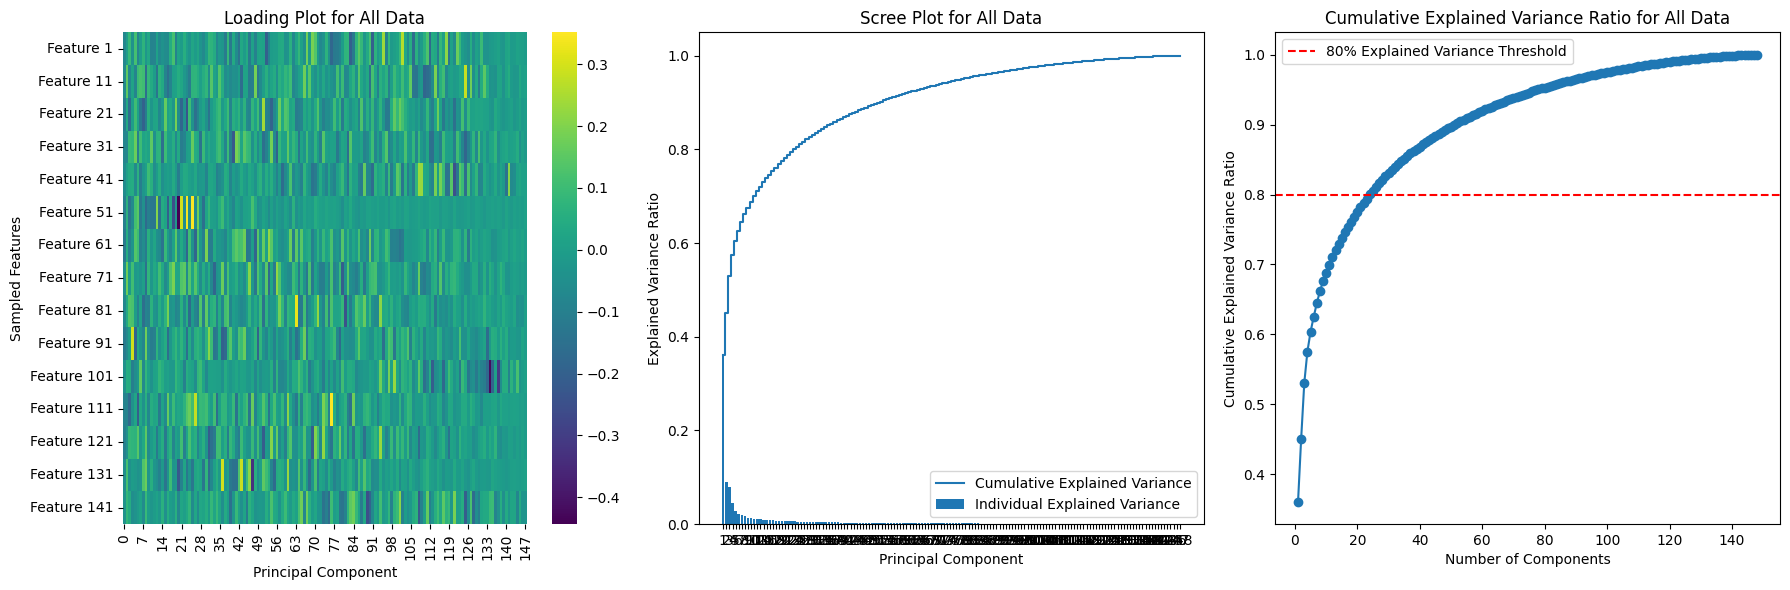

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Extract "data" arrays from dictionaries
autism_data_arrays = [entry["data"] for entry in data_info_dict_autism.values()]
no_autism_data_arrays = [entry["data"] for entry in data_info_dict_no_autism.values()]

# Convert arrays into matrices for both groups
autism_data_matrix = np.vstack(autism_data_arrays)
no_autism_data_matrix = np.vstack(no_autism_data_arrays)

# Concatenate data matrices for both groups
all_data_matrix = np.vstack((autism_data_matrix, no_autism_data_matrix))

# Create PCA instance for the whole dataset
pca_all = PCA()
pca_all.fit(all_data_matrix)

# Calculate cumulative explained variance ratio
cumulative_explained_variance_all = np.cumsum(pca_all.explained_variance_ratio_)

# Find the number of components to explain 80% of the variance
num_components_80_percent_all = np.argmax(cumulative_explained_variance_all >= 0.80) + 1

print(f"Number of components to explain 80% of the variance: {num_components_80_percent_all}")

# Sample a subset of features for loading plots (e.g., every 10th feature)
sampled_features_indices = np.arange(0, all_data_matrix.shape[1], step=10)

# Create subplots for loading plots and scree plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Loading plot for all data
sns.heatmap(pca_all.components_.T[sampled_features_indices], cmap='viridis', yticklabels=['Feature {}'.format(i+1) for i in sampled_features_indices], ax=axs[0])
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Sampled Features')
axs[0].set_title('Loading Plot for All Data')

# Scree plot
explained_variance = pca_all.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
axs[1].bar(range(1, len(explained_variance) + 1), explained_variance, align='center', label='Individual Explained Variance')
axs[1].step(range(1, len(explained_variance) + 1), cumulative_explained_variance, where='mid', label='Cumulative Explained Variance')
axs[1].set_xlabel('Principal Component')
axs[1].set_ylabel('Explained Variance Ratio')
axs[1].set_title('Scree Plot for All Data')
axs[1].set_xticks(range(1, len(explained_variance) + 1))
axs[1].legend()

# Cumulative explained variance plot
axs[2].plot(range(1, len(cumulative_explained_variance_all) + 1), cumulative_explained_variance_all, marker='o')
axs[2].axhline(y=0.8, color='r', linestyle='--', label='80% Explained Variance Threshold')
axs[2].set_xlabel('Number of Components')
axs[2].set_ylabel('Cumulative Explained Variance Ratio')
axs[2].set_title('Cumulative Explained Variance Ratio for All Data')
axs[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()


## Model Building




### Defining utility functions

Firstly, I am defining the loss function.
The loss will be computed as the sum of the BCE-Loss, as well as the KL-divergence terms.

* MSE loss: Incoming

* Cross Entropy: Incoming

* Kullback-Leibler divergence (Kullback & Leibler, 1951) This is a measure for the difference between two distributions. I.e. "how much do they diverge" from each other, how much are they different to each other. The introduction of this term into the final loss leads my model to optimize not only if the precited categories are correct and so on, but also how high the difference between the prior distribution and teh latent variables are. The prior distribution in my case is an isotropic gaussian.
  * Why is this desirable? The latent variables and the sampling process should be somewhat controlled. This divergence regulates this.


I have also attempted to regulate that a loss is only completed with the KL divergence from the second encoder if that encoder was used.

In [14]:
def final_loss(MSE, MSE_age, z_mu, z_logvar, s_mu, s_logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: reconstruction loss
    :param z_mu: mean from the latent vector of encoder_z
    :param z_logvar: log variance from the latent vector of encoder_z
    :param s_mu: mean from the latent vector of encoder_s (optional)
    :param s_logvar: log variance from the latent vector of encoder_s (optional)
    """
    mse_loss = MSE
    mse_age = MSE_age
    KLD_z = -0.5 * torch.sum(1 + z_logvar - z_mu.pow(2) - z_logvar.exp())
    if mse_age is not None:
      if s_mu is not None and s_logvar is not None:
          KLD_s = -0.5 * torch.sum(1 + s_logvar - s_mu.pow(2) - s_logvar.exp())
          return mse_loss + KLD_z + KLD_s +mse_age
      else:
          return mse_loss + KLD_z + mse_age
    else:
      if s_mu is not None and s_logvar is not None:
          KLD_s = -0.5 * torch.sum(1 + s_logvar - s_mu.pow(2) - s_logvar.exp())
          return mse_loss + KLD_z + KLD_s
      else:
          return mse_loss + KLD_z


Here is the training loop.

In [24]:
def train(model, dataloader, dataset, device, optimizer, criterion, criterion_classifier):
    model.train()
    running_loss_autism = 0.0
    running_loss_no_autism = 0.0
    running_age_loss_autism = 0.0
    running_age_loss_no_autism = 0.0
    counter = 0

    total_batches = len(dataset) // dataloader.batch_size

    for i, ((autism_data, autism_age, _, autism_diag_group,_,_,_,_,_), (no_autism_data, no_autism_age, _, no_autism_diag_group,_,_)) in tqdm(enumerate(dataloader), total=total_batches):
        autism_data = autism_data.to(device)
        no_autism_data = no_autism_data.to(device)

        autism_age = autism_age.to(device)
        no_autism_age = no_autism_age.to(device)

        optimizer.zero_grad()

        # Get the model outputs
        z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, class_autism_age, class_no_autism_age, z, s, z_no_autism = model(autism_data, no_autism_data)

        # Calculate classifier losses for age and fiq predictions using the criterion_classifier
        age_loss_autism = criterion_classifier(class_autism_age, autism_age.unsqueeze(1).float())
        age_loss_no_autism = criterion_classifier(class_no_autism_age, no_autism_age.unsqueeze(1).float())

        # Section for the autism images
        bce_loss_autism = criterion(reconstructed_data_autism, autism_data)
        loss_autism = final_loss(bce_loss_autism, age_loss_autism, z_mean, z_log_var, s_mean, s_log_var)
        running_loss_autism += loss_autism.item()
        running_age_loss_autism += age_loss_autism.item()

        # Section for the no_autism images
        bce_loss_no_autism = criterion(reconstructed_data_no_autism, no_autism_data)
        s_mean_no_autism, s_log_var_no_autism = None, None
        loss_no_autism = final_loss(bce_loss_no_autism, age_loss_no_autism, z_mean_no_autism, z_log_var_no_autism, s_mean_no_autism, s_log_var_no_autism)
        running_loss_no_autism += loss_no_autism.item()
        running_age_loss_no_autism += age_loss_no_autism.item()

        # Total loss
        loss_no_autism.backward()
        loss_autism.backward()

        optimizer.step()
        counter += len(autism_data) + len(no_autism_data)

    train_loss_autism = running_loss_autism / counter
    train_loss_no_autism = running_loss_no_autism / counter
    train_age_loss_autism = running_age_loss_autism / counter
    train_age_loss_no_autism = running_age_loss_no_autism / counter
    return (train_loss_autism, train_loss_no_autism, train_age_loss_autism, train_age_loss_no_autism)


And of course the corresponding validation function


In [25]:
def validate(model, dataloader, dataset, device, criterion, criterion_classifier):
    model.eval()  # Set the model to evaluation mode
    running_loss_autism = 0.0
    running_loss_no_autism = 0.0
    running_age_loss_autism = 0.0
    running_fiq_loss_autism = 0.0
    running_age_loss_no_autism = 0.0
    running_fiq_loss_no_autism = 0.0
    counter = 0

    total_batches = len(dataset) // dataloader.batch_size

    with torch.no_grad():  # Disable gradient calculation during validation
        for i, ((autism_data, autism_age, _, autism_diag_group,_,_,_,_,_), (no_autism_data, no_autism_age, _, no_autism_diag_group,_,_)) in tqdm(enumerate(dataloader), total=total_batches):
            autism_data = autism_data.to(device)
            no_autism_data = no_autism_data.to(device)

            autism_age = autism_age.to(device)
            no_autism_age = no_autism_age.to(device)

            # Get the model outputs
            z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, class_autism_age, class_no_autism_age, z, s, z_no_autism = model(autism_data, no_autism_data)

            # Calculate classifier losses for age and fiq predictions using the criterion_classifier
            age_loss_autism = criterion_classifier(class_autism_age, autism_age.unsqueeze(1).float())

            age_loss_no_autism = criterion_classifier(class_no_autism_age, no_autism_age.unsqueeze(1).float())

            # Section for the autism images
            bce_loss_autism = criterion(reconstructed_data_autism, autism_data)
            loss_autism = final_loss(bce_loss_autism, age_loss_autism, z_mean, z_log_var, s_mean, s_log_var)
            running_loss_autism += loss_autism.item()
            running_age_loss_autism += age_loss_autism.item()

            # Section for the no_autism images
            bce_loss_no_autism = criterion(reconstructed_data_no_autism, no_autism_data)
            s_mean_no_autism, s_log_var_no_autism = None, None
            loss_no_autism = final_loss(bce_loss_no_autism,age_loss_no_autism, z_mean_no_autism, z_log_var_no_autism, s_mean_no_autism, s_log_var_no_autism)
            running_loss_no_autism += loss_no_autism.item()
            running_age_loss_no_autism += age_loss_no_autism.item()

            counter += len(autism_data) + len(no_autism_data)

    val_loss_autism = running_loss_autism / counter
    val_loss_no_autism = running_loss_no_autism / counter
    val_age_loss_autism = running_age_loss_autism / counter
    val_age_loss_no_autism = running_age_loss_no_autism / counter

    return (val_loss_autism, val_loss_no_autism,
        val_age_loss_autism, val_age_loss_no_autism)


## Model Specifications
In the following I am specifiying the model. I am roughly orienting myself around a paper from Anglinkas, Hartshorne & Anzellotti (2022).


Next I want to define the contrastive variational autoencoder. While doing so, I am defining seperate encoders, to make it easier to later introduce other encoders. I am orienting myself on an cVAE I have written in the past.

As the paper from Aglinskas, Hartshorne and Anzellotti (2022) I mentioned, the network will have only a few layers.

A few things I will probably have to change - I do not know how many channels the data will end up having. therefore I am using one, assuming it only has one.

In [26]:
class EncoderNS(nn.Module):
    def __init__(self, input_dimension, latent_dim):
        super(EncoderNS, self).__init__()
        self.linear1 = nn.Linear(input_dimension, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, latent_dim)
        self.ns_fc_mean = nn.Linear(latent_dim, latent_dim)
        self.ns_fc_log_var = nn.Linear(latent_dim, latent_dim)

    def forward(self, x, batch_size):
        h = F.relu(self.linear1(x))
        h = F.relu(self.linear2(h))
        h = F.relu(self.linear3(h))
        ns_mean = self.ns_fc_mean(h)
        ns_log_var = self.ns_fc_log_var(h)
        return ns_mean, ns_log_var


class EncoderS(nn.Module):
    def __init__(self, input_dimension, latent_dim):
        super(EncoderS, self).__init__()
        self.linear1 = nn.Linear(input_dimension, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, latent_dim)
        self.s_fc_mean = nn.Linear(latent_dim, latent_dim)
        self.s_fc_log_var = nn.Linear(latent_dim, latent_dim)

    def forward(self, x, batch_size):
        h = F.relu(self.linear1(x))
        h = F.relu(self.linear2(h))
        h = F.relu(self.linear3(h))
        s_mean = self.s_fc_mean(h)
        s_log_var = self.s_fc_log_var(h)
        return s_mean, s_log_var

class Decoder(nn.Module):
    def __init__(self, input_dimension, latent_dim):
        super(Decoder, self).__init__()
        self.linear_decoder_1 = nn.Linear(latent_dim*2, 32)
        self.linear_decoder_2 = nn.Linear(32,64)
        self.linear_decoder_3 = nn.Linear(64, input_dimension)

    def forward(self, zs, batch_size):
        h_output = F.relu(self.linear_decoder_1(zs))
        h_output = F.relu(self.linear_decoder_2(h_output))
        output = F.relu(self.linear_decoder_3(h_output))
        return output

class Classifier(nn.Module):
    def __init__(self, latent_dim):
        super(Classifier, self).__init__()
        self.fc_first_age = nn.Linear(latent_dim *2, latent_dim // 2)
        self.fc_age = nn.Linear(latent_dim // 2, 1)

    def forward(self, z):
        x_age = self.fc_first_age(z)
        age_prediction = self.fc_age(x_age)
        return age_prediction

class cVAE_classifier(nn.Module):
    def __init__(self, input_dimension, latent_dim):
        super(cVAE_classifier, self).__init__()
        self.encoder_z = EncoderNS(input_dimension, latent_dim)
        self.encoder_s = EncoderS(input_dimension, latent_dim)
        self.decoder = Decoder(input_dimension, latent_dim)
        self.classifier = Classifier(latent_dim)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mean + epsilon * std

    def forward(self, autism, no_autism):
        batch_size = autism.size(0)
        z_mean, z_log_var = self.encoder_z(autism, batch_size)
        z = self.reparameterize(z_mean, z_log_var)
        s_mean, s_log_var = self.encoder_s(autism, batch_size)
        s = self.reparameterize(s_mean, s_log_var)
        zs = torch.cat([z, s], dim=1)

        reconstructed_data_autism = self.decoder(zs, batch_size)

        z_mean_no_autism, z_log_var_no_autism = self.encoder_z(no_autism, batch_size)
        z_no_autism = self.reparameterize(z_mean_no_autism, z_log_var_no_autism)
        z_empty = torch.zeros(z_no_autism.shape)
        model_device = z_no_autism.device
        z_empty = z_empty.to(model_device)
        z_no_autism_0 = torch.cat([z_no_autism, z_empty], dim=1)


        reconstructed_data_no_autism = self.decoder(z_no_autism_0, batch_size)

        class_autism_age = self.classifier(zs)  # Assuming z is the latent variable after concatenating s and z
        class_no_autism_age = self.classifier(z_no_autism_0)  # Using the version with 0s to have equal lengths of the latent vectors.

        return z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, class_autism_age, class_no_autism_age, z, s, z_no_autism

### Other models that will be tested later.

Firstly, here is a model, as well as the relevant training and validaiton functions, for a mdoel without a classifier.

In [31]:
class cVAE(nn.Module):
    def __init__(self, input_dimension, latent_dim):
        super(cVAE, self).__init__()
        self.encoder_z = EncoderNS(input_dimension, latent_dim)
        self.encoder_s = EncoderS(input_dimension, latent_dim)
        self.decoder = Decoder(input_dimension, latent_dim)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mean + epsilon * std

    def forward(self, autism, no_autism):
        batch_size = autism.size(0)
        z_mean, z_log_var = self.encoder_z(autism, batch_size)
        z = self.reparameterize(z_mean, z_log_var)
        s_mean, s_log_var = self.encoder_s(autism, batch_size)
        s = self.reparameterize(s_mean, s_log_var)
        zs = torch.cat([z, s], dim=1)

        reconstructed_data_autism = self.decoder(zs, batch_size)

        z_mean_no_autism, z_log_var_no_autism = self.encoder_z(no_autism, batch_size)
        z_no_autism = self.reparameterize(z_mean_no_autism, z_log_var_no_autism)
        z_empty = torch.zeros(z_no_autism.shape)
        model_device = z_no_autism.device
        z_empty = z_empty.to(model_device)
        z_no_autism_0 = torch.cat([z_no_autism, z_empty], dim=1)

        reconstructed_data_no_autism = self.decoder(z_no_autism_0, batch_size)

        return z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, z, s, z_no_autism

def train_no_classifier(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss_autism = 0.0
    running_loss_no_autism = 0.0
    counter = 0

    total_batches = len(dataset) // dataloader.batch_size

    for i, ((autism_data, _, _, _,_,_,_,_,_), (no_autism_data, _, _, _,_,_)) in tqdm(enumerate(dataloader), total=total_batches):
        autism_data = autism_data.to(device)
        no_autism_data = no_autism_data.to(device)

        optimizer.zero_grad()

        # Get the model outputs
        z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, z, s, z_no_autism = model(autism_data, no_autism_data)

        # Section for the autism images
        bce_loss_autism = criterion(reconstructed_data_autism, autism_data)
        loss_autism = final_loss(bce_loss_autism , None, z_mean, z_log_var, s_mean, s_log_var)
        running_loss_autism += loss_autism.item()

        # Section for the no_autism images
        bce_loss_no_autism = criterion(reconstructed_data_no_autism, no_autism_data)
        s_mean_no_autism, s_log_var_no_autism = None, None
        loss_no_autism = final_loss(bce_loss_no_autism  , None, z_mean_no_autism, z_log_var_no_autism, s_mean_no_autism, s_log_var_no_autism)
        running_loss_no_autism += loss_no_autism.item()

        # Total loss
        loss_no_autism.backward()
        loss_autism.backward()

        optimizer.step()
        counter += len(autism_data) + len(no_autism_data)

    train_loss_autism = running_loss_autism / counter
    train_loss_no_autism = running_loss_no_autism / counter

    return train_loss_autism, train_loss_no_autism



def validate_no_classifier(model, dataloader, dataset, device, criterion):
    model.eval()  # Set the model to evaluation mode
    running_loss_autism = 0.0
    running_loss_no_autism = 0.0
    counter = 0

    total_batches = len(dataset) // dataloader.batch_size

    with torch.no_grad():  # Disable gradient calculation during validation
        for i, ((autism_data, _, _, _,_,_,_,_,_), (no_autism_data, _, _, _,_,_)) in tqdm(enumerate(dataloader), total=total_batches):
            autism_data = autism_data.to(device)
            no_autism_data = no_autism_data.to(device)

            # Get the model outputs
            z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, z, s, z_no_autism = model(autism_data, no_autism_data)

            # Section for the autism images
            bce_loss_autism = criterion(reconstructed_data_autism, autism_data)
            loss_autism = final_loss(bce_loss_autism  , None, z_mean, z_log_var, s_mean, s_log_var)
            running_loss_autism += loss_autism.item()

            # Section for the no_autism images
            bce_loss_no_autism = criterion(reconstructed_data_no_autism, no_autism_data)
            s_mean_no_autism, s_log_var_no_autism = None, None
            loss_no_autism = final_loss(bce_loss_no_autism  , None, z_mean_no_autism, z_log_var_no_autism, s_mean_no_autism, s_log_var_no_autism)
            running_loss_no_autism += loss_no_autism.item()

            counter += len(autism_data) + len(no_autism_data)

    val_loss_autism = running_loss_autism / counter
    val_loss_no_autism = running_loss_no_autism / counter

    return val_loss_autism, val_loss_no_autism



## Training the model

In this section, I am training the various models

Here is a loop that is supposed to help me find the optimal learning rate.

Training with learning rate: 0.001
Epoch 1 of 100


4it [00:00, 54.43it/s]               
3it [00:00, 125.88it/s]              


Train Loss Autism: 4.2808, Train Loss Non-Autism: 3.7561,Train Age Loss Autism: 3.9190, Train Age Loss Non-Autism: 3.5602
Epoch 2 of 100


4it [00:00, 79.63it/s]               
3it [00:00, 121.00it/s]              


Train Loss Autism: 4.4194, Train Loss Non-Autism: 3.8259,Train Age Loss Autism: 4.1026, Train Age Loss Non-Autism: 3.6428
Epoch 3 of 100


4it [00:00, 79.57it/s]               
3it [00:00, 132.62it/s]              


Train Loss Autism: 4.1067, Train Loss Non-Autism: 3.5159,Train Age Loss Autism: 3.7976, Train Age Loss Non-Autism: 3.3380
Epoch 4 of 100


4it [00:00, 74.70it/s]               
3it [00:00, 122.01it/s]              


Train Loss Autism: 4.1119, Train Loss Non-Autism: 3.7351,Train Age Loss Autism: 3.8100, Train Age Loss Non-Autism: 3.5613
Epoch 5 of 100


4it [00:00, 65.50it/s]               
3it [00:00, 129.14it/s]              


Train Loss Autism: 4.2778, Train Loss Non-Autism: 3.4260,Train Age Loss Autism: 3.9846, Train Age Loss Non-Autism: 3.2574
Epoch 6 of 100


4it [00:00, 70.17it/s]               
3it [00:00, 99.10it/s]               


Train Loss Autism: 4.5918, Train Loss Non-Autism: 3.6842,Train Age Loss Autism: 4.3074, Train Age Loss Non-Autism: 3.5214
Epoch 7 of 100


4it [00:00, 76.96it/s]               
3it [00:00, 134.55it/s]              


Train Loss Autism: 4.5601, Train Loss Non-Autism: 3.5916,Train Age Loss Autism: 4.2842, Train Age Loss Non-Autism: 3.4342
Epoch 8 of 100


4it [00:00, 71.60it/s]               
3it [00:00, 125.23it/s]              


Train Loss Autism: 4.0570, Train Loss Non-Autism: 3.8254,Train Age Loss Autism: 3.7903, Train Age Loss Non-Autism: 3.6745
Epoch 9 of 100


4it [00:00, 78.88it/s]               
3it [00:00, 120.31it/s]              


Train Loss Autism: 4.0851, Train Loss Non-Autism: 3.7256,Train Age Loss Autism: 3.8272, Train Age Loss Non-Autism: 3.5804
Epoch 10 of 100


4it [00:00, 73.56it/s]               
3it [00:00, 127.76it/s]              


Train Loss Autism: 4.3203, Train Loss Non-Autism: 3.5874,Train Age Loss Autism: 4.0719, Train Age Loss Non-Autism: 3.4491
Epoch 11 of 100


4it [00:00, 74.85it/s]               
3it [00:00, 117.85it/s]              


Train Loss Autism: 4.0999, Train Loss Non-Autism: 3.6161,Train Age Loss Autism: 3.8597, Train Age Loss Non-Autism: 3.4832
Epoch 12 of 100


4it [00:00, 74.38it/s]               
3it [00:00, 107.81it/s]              


Train Loss Autism: 4.0222, Train Loss Non-Autism: 3.7079,Train Age Loss Autism: 3.7886, Train Age Loss Non-Autism: 3.5805
Epoch 13 of 100


4it [00:00, 81.15it/s]               
3it [00:00, 133.94it/s]              


Train Loss Autism: 4.1785, Train Loss Non-Autism: 3.8380,Train Age Loss Autism: 3.9506, Train Age Loss Non-Autism: 3.7154
Epoch 14 of 100


4it [00:00, 74.32it/s]               
3it [00:00, 119.73it/s]              


Train Loss Autism: 4.0682, Train Loss Non-Autism: 3.7963,Train Age Loss Autism: 3.8471, Train Age Loss Non-Autism: 3.6778
Epoch 15 of 100


4it [00:00, 62.93it/s]               
3it [00:00, 104.87it/s]              


Train Loss Autism: 4.3215, Train Loss Non-Autism: 3.9661,Train Age Loss Autism: 4.1051, Train Age Loss Non-Autism: 3.8518
Epoch 16 of 100


4it [00:00, 76.45it/s]               
3it [00:00, 114.77it/s]              


Train Loss Autism: 3.9347, Train Loss Non-Autism: 3.6004,Train Age Loss Autism: 3.7246, Train Age Loss Non-Autism: 3.4896
Epoch 17 of 100


4it [00:00, 40.71it/s]               
3it [00:00, 57.10it/s]               


Train Loss Autism: 3.9495, Train Loss Non-Autism: 3.7781,Train Age Loss Autism: 3.7439, Train Age Loss Non-Autism: 3.6702
Epoch 18 of 100


4it [00:00, 48.29it/s]               
3it [00:00, 75.30it/s]               


Train Loss Autism: 3.7500, Train Loss Non-Autism: 3.5274,Train Age Loss Autism: 3.5499, Train Age Loss Non-Autism: 3.4227
Epoch 19 of 100


4it [00:00, 29.00it/s]
3it [00:00, 61.95it/s]               


Train Loss Autism: 3.8245, Train Loss Non-Autism: 3.4551,Train Age Loss Autism: 3.6295, Train Age Loss Non-Autism: 3.3533
Epoch 20 of 100


4it [00:00, 43.46it/s]               
3it [00:00, 38.85it/s]               


Train Loss Autism: 3.9647, Train Loss Non-Autism: 3.4261,Train Age Loss Autism: 3.7748, Train Age Loss Non-Autism: 3.3265
Epoch 21 of 100


4it [00:00, 30.01it/s]
3it [00:00, 47.86it/s]               


Train Loss Autism: 3.7310, Train Loss Non-Autism: 3.4933,Train Age Loss Autism: 3.5451, Train Age Loss Non-Autism: 3.3968
Epoch 22 of 100


4it [00:00, 24.30it/s]                       
3it [00:00, 83.04it/s]               


Train Loss Autism: 3.8393, Train Loss Non-Autism: 3.4896,Train Age Loss Autism: 3.6577, Train Age Loss Non-Autism: 3.3950
Epoch 23 of 100


4it [00:00, 48.98it/s]               
3it [00:00, 86.36it/s]               


Train Loss Autism: 3.9911, Train Loss Non-Autism: 3.5769,Train Age Loss Autism: 3.8137, Train Age Loss Non-Autism: 3.4850
Epoch 24 of 100


4it [00:00, 43.54it/s]               
3it [00:00, 58.65it/s]               


Train Loss Autism: 3.9898, Train Loss Non-Autism: 3.5933,Train Age Loss Autism: 3.8169, Train Age Loss Non-Autism: 3.5041
Epoch 25 of 100


4it [00:00, 18.33it/s]                       
3it [00:00, 44.04it/s]               


Train Loss Autism: 3.8907, Train Loss Non-Autism: 3.3593,Train Age Loss Autism: 3.7215, Train Age Loss Non-Autism: 3.2722
Epoch 26 of 100


4it [00:00, 36.93it/s]
3it [00:00, 85.41it/s]               


Train Loss Autism: 3.8116, Train Loss Non-Autism: 3.6524,Train Age Loss Autism: 3.6459, Train Age Loss Non-Autism: 3.5675
Epoch 27 of 100


4it [00:00, 36.17it/s]
3it [00:00, 53.44it/s]               


Train Loss Autism: 3.7350, Train Loss Non-Autism: 3.6221,Train Age Loss Autism: 3.5724, Train Age Loss Non-Autism: 3.5390
Epoch 28 of 100


4it [00:00, 24.04it/s]                       
3it [00:00, 43.26it/s]               


Train Loss Autism: 4.0630, Train Loss Non-Autism: 3.6489,Train Age Loss Autism: 3.9045, Train Age Loss Non-Autism: 3.5680
Epoch 29 of 100


4it [00:00, 45.93it/s]               
3it [00:00, 79.76it/s]               


Train Loss Autism: 4.1317, Train Loss Non-Autism: 3.1998,Train Age Loss Autism: 3.9767, Train Age Loss Non-Autism: 3.1201
Epoch 30 of 100


4it [00:00, 44.40it/s]               
3it [00:00, 59.80it/s]               


Train Loss Autism: 3.8664, Train Loss Non-Autism: 3.6106,Train Age Loss Autism: 3.7147, Train Age Loss Non-Autism: 3.5331
Epoch 31 of 100


4it [00:00, 33.99it/s]
3it [00:00, 79.25it/s]               


Train Loss Autism: 3.9306, Train Loss Non-Autism: 3.6943,Train Age Loss Autism: 3.7820, Train Age Loss Non-Autism: 3.6183
Epoch 32 of 100


4it [00:00, 46.71it/s]               
3it [00:00, 65.54it/s]               


Train Loss Autism: 3.8140, Train Loss Non-Autism: 3.7290,Train Age Loss Autism: 3.6680, Train Age Loss Non-Autism: 3.6549
Epoch 33 of 100


4it [00:00, 49.17it/s]               
3it [00:00, 62.97it/s]               


Train Loss Autism: 4.1893, Train Loss Non-Autism: 3.3521,Train Age Loss Autism: 4.0462, Train Age Loss Non-Autism: 3.2793
Epoch 34 of 100


4it [00:00, 48.64it/s]               
3it [00:00, 88.30it/s]               


Train Loss Autism: 4.1933, Train Loss Non-Autism: 3.4493,Train Age Loss Autism: 4.0532, Train Age Loss Non-Autism: 3.3784
Epoch 35 of 100


4it [00:00, 42.40it/s]               
3it [00:00, 72.32it/s]               


Train Loss Autism: 3.9939, Train Loss Non-Autism: 3.5216,Train Age Loss Autism: 3.8561, Train Age Loss Non-Autism: 3.4520
Epoch 36 of 100


4it [00:00, 42.40it/s]               
3it [00:00, 35.76it/s]               


Train Loss Autism: 3.7703, Train Loss Non-Autism: 3.6007,Train Age Loss Autism: 3.6353, Train Age Loss Non-Autism: 3.5324
Epoch 37 of 100


4it [00:00, 43.95it/s]               
3it [00:00, 73.03it/s]               


Train Loss Autism: 4.2173, Train Loss Non-Autism: 3.6980,Train Age Loss Autism: 4.0850, Train Age Loss Non-Autism: 3.6312
Epoch 38 of 100


4it [00:00, 43.32it/s]               
3it [00:00, 86.92it/s]               


Train Loss Autism: 3.6201, Train Loss Non-Autism: 3.4726,Train Age Loss Autism: 3.4895, Train Age Loss Non-Autism: 3.4065
Epoch 39 of 100


4it [00:00, 78.64it/s]               
3it [00:00, 125.09it/s]              


Train Loss Autism: 3.7779, Train Loss Non-Autism: 3.6889,Train Age Loss Autism: 3.6493, Train Age Loss Non-Autism: 3.6242
Epoch 40 of 100


4it [00:00, 46.07it/s]               
3it [00:00, 78.32it/s]               


Train Loss Autism: 3.8036, Train Loss Non-Autism: 3.3611,Train Age Loss Autism: 3.6770, Train Age Loss Non-Autism: 3.2973
Epoch 41 of 100


4it [00:00, 50.94it/s]               
3it [00:00, 81.70it/s]               


Train Loss Autism: 3.9031, Train Loss Non-Autism: 3.4264,Train Age Loss Autism: 3.7785, Train Age Loss Non-Autism: 3.3638
Epoch 42 of 100


4it [00:00, 44.53it/s]               
3it [00:00, 79.47it/s]               


Train Loss Autism: 4.1517, Train Loss Non-Autism: 3.3884,Train Age Loss Autism: 4.0292, Train Age Loss Non-Autism: 3.3266
Epoch 43 of 100


4it [00:00, 50.45it/s]               
3it [00:00, 61.75it/s]               


Train Loss Autism: 3.6829, Train Loss Non-Autism: 3.5272,Train Age Loss Autism: 3.5621, Train Age Loss Non-Autism: 3.4660
Epoch 44 of 100


4it [00:00, 48.53it/s]               
3it [00:00, 74.19it/s]               


Train Loss Autism: 3.6347, Train Loss Non-Autism: 3.3064,Train Age Loss Autism: 3.5155, Train Age Loss Non-Autism: 3.2461
Epoch 45 of 100


4it [00:00, 49.77it/s]               
3it [00:00, 74.69it/s]               


Train Loss Autism: 3.8061, Train Loss Non-Autism: 3.5070,Train Age Loss Autism: 3.6882, Train Age Loss Non-Autism: 3.4472
Epoch 46 of 100


4it [00:00, 35.22it/s]
3it [00:00, 50.16it/s]               


Train Loss Autism: 3.7869, Train Loss Non-Autism: 3.3769,Train Age Loss Autism: 3.6711, Train Age Loss Non-Autism: 3.3181
Epoch 47 of 100


4it [00:00, 44.07it/s]               
3it [00:00, 79.43it/s]               


Train Loss Autism: 3.6654, Train Loss Non-Autism: 3.5442,Train Age Loss Autism: 3.5505, Train Age Loss Non-Autism: 3.4860
Epoch 48 of 100


4it [00:00, 50.19it/s]               
3it [00:00, 85.91it/s]               


Train Loss Autism: 3.8311, Train Loss Non-Autism: 3.2181,Train Age Loss Autism: 3.7174, Train Age Loss Non-Autism: 3.1604
Epoch 49 of 100


4it [00:00, 47.68it/s]               
3it [00:00, 89.60it/s]               


Train Loss Autism: 4.5198, Train Loss Non-Autism: 3.4495,Train Age Loss Autism: 4.4074, Train Age Loss Non-Autism: 3.3923
Epoch 50 of 100


4it [00:00, 41.13it/s]               
3it [00:00, 62.68it/s]               


Train Loss Autism: 3.8782, Train Loss Non-Autism: 3.2514,Train Age Loss Autism: 3.7665, Train Age Loss Non-Autism: 3.1944
Epoch 51 of 100


4it [00:00, 49.86it/s]               
3it [00:00, 89.33it/s]               


Train Loss Autism: 3.6357, Train Loss Non-Autism: 3.4912,Train Age Loss Autism: 3.5253, Train Age Loss Non-Autism: 3.4347
Epoch 52 of 100


4it [00:00, 53.18it/s]               
3it [00:00, 65.95it/s]               


Train Loss Autism: 3.8404, Train Loss Non-Autism: 3.4205,Train Age Loss Autism: 3.7308, Train Age Loss Non-Autism: 3.3644
Epoch 53 of 100


4it [00:00, 44.16it/s]               
3it [00:00, 74.52it/s]               


Train Loss Autism: 3.5743, Train Loss Non-Autism: 3.5102,Train Age Loss Autism: 3.4653, Train Age Loss Non-Autism: 3.4542
Epoch 54 of 100


4it [00:00, 45.64it/s]               
3it [00:00, 87.63it/s]               


Train Loss Autism: 3.7794, Train Loss Non-Autism: 3.1847,Train Age Loss Autism: 3.6709, Train Age Loss Non-Autism: 3.1290
Epoch 55 of 100


4it [00:00, 46.72it/s]               
3it [00:00, 82.69it/s]               


Train Loss Autism: 3.7299, Train Loss Non-Autism: 3.5033,Train Age Loss Autism: 3.6216, Train Age Loss Non-Autism: 3.4472
Epoch 56 of 100


4it [00:00, 44.18it/s]               
3it [00:00, 72.57it/s]               


Train Loss Autism: 3.6078, Train Loss Non-Autism: 3.2312,Train Age Loss Autism: 3.5004, Train Age Loss Non-Autism: 3.1755
Epoch 57 of 100


4it [00:00, 46.25it/s]               
3it [00:00, 76.91it/s]               


Train Loss Autism: 3.9029, Train Loss Non-Autism: 3.1399,Train Age Loss Autism: 3.7958, Train Age Loss Non-Autism: 3.0840
Epoch 58 of 100


4it [00:00, 51.46it/s]               
3it [00:00, 88.85it/s]               


Train Loss Autism: 3.5493, Train Loss Non-Autism: 3.3249,Train Age Loss Autism: 3.4425, Train Age Loss Non-Autism: 3.2695
Epoch 59 of 100


4it [00:00, 49.03it/s]               
3it [00:00, 91.45it/s]               


Train Loss Autism: 3.9826, Train Loss Non-Autism: 3.3425,Train Age Loss Autism: 3.8756, Train Age Loss Non-Autism: 3.2866
Epoch 60 of 100


4it [00:00, 45.38it/s]               
3it [00:00, 90.43it/s]               


Train Loss Autism: 3.4833, Train Loss Non-Autism: 3.1853,Train Age Loss Autism: 3.3764, Train Age Loss Non-Autism: 3.1292
Epoch 61 of 100


4it [00:00, 52.97it/s]               
3it [00:00, 63.64it/s]               


Train Loss Autism: 3.6483, Train Loss Non-Autism: 3.3211,Train Age Loss Autism: 3.5416, Train Age Loss Non-Autism: 3.2649
Epoch 62 of 100


4it [00:00, 49.34it/s]               
3it [00:00, 87.59it/s]               


Train Loss Autism: 3.5258, Train Loss Non-Autism: 3.1744,Train Age Loss Autism: 3.4191, Train Age Loss Non-Autism: 3.1181
Epoch 63 of 100


4it [00:00, 47.75it/s]               
3it [00:00, 82.29it/s]               


Train Loss Autism: 3.7629, Train Loss Non-Autism: 3.1066,Train Age Loss Autism: 3.6555, Train Age Loss Non-Autism: 3.0495
Epoch 64 of 100


4it [00:00, 51.71it/s]               
3it [00:00, 76.69it/s]               


Train Loss Autism: 3.4351, Train Loss Non-Autism: 3.2928,Train Age Loss Autism: 3.3278, Train Age Loss Non-Autism: 3.2357
Epoch 65 of 100


4it [00:00, 49.61it/s]               
3it [00:00, 66.59it/s]               


Train Loss Autism: 3.4416, Train Loss Non-Autism: 3.2030,Train Age Loss Autism: 3.3338, Train Age Loss Non-Autism: 3.1453
Epoch 66 of 100


4it [00:00, 50.24it/s]               
3it [00:00, 78.00it/s]               


Train Loss Autism: 3.5238, Train Loss Non-Autism: 3.6363,Train Age Loss Autism: 3.4152, Train Age Loss Non-Autism: 3.5783
Epoch 67 of 100


4it [00:00, 50.53it/s]               
3it [00:00, 80.60it/s]               


Train Loss Autism: 3.5002, Train Loss Non-Autism: 3.4330,Train Age Loss Autism: 3.3912, Train Age Loss Non-Autism: 3.3742
Epoch 68 of 100


4it [00:00, 52.95it/s]               
3it [00:00, 80.53it/s]               


Train Loss Autism: 3.3564, Train Loss Non-Autism: 3.1051,Train Age Loss Autism: 3.2468, Train Age Loss Non-Autism: 3.0458
Epoch 69 of 100


4it [00:00, 50.59it/s]               
3it [00:00, 66.62it/s]               


Train Loss Autism: 4.0997, Train Loss Non-Autism: 3.4216,Train Age Loss Autism: 3.9894, Train Age Loss Non-Autism: 3.3617
Epoch 70 of 100


4it [00:00, 51.52it/s]               
3it [00:00, 77.28it/s]               


Train Loss Autism: 3.6751, Train Loss Non-Autism: 3.1071,Train Age Loss Autism: 3.5634, Train Age Loss Non-Autism: 3.0461
Epoch 71 of 100


4it [00:00, 51.60it/s]               
3it [00:00, 89.03it/s]               


Train Loss Autism: 3.9863, Train Loss Non-Autism: 3.4237,Train Age Loss Autism: 3.8738, Train Age Loss Non-Autism: 3.3621
Epoch 72 of 100


4it [00:00, 49.28it/s]               
3it [00:00, 73.32it/s]               


Train Loss Autism: 3.4724, Train Loss Non-Autism: 2.9725,Train Age Loss Autism: 3.3588, Train Age Loss Non-Autism: 2.9100
Epoch 73 of 100


4it [00:00, 44.58it/s]               
3it [00:00, 87.51it/s]               


Train Loss Autism: 3.4609, Train Loss Non-Autism: 3.1516,Train Age Loss Autism: 3.3455, Train Age Loss Non-Autism: 3.0878
Epoch 74 of 100


4it [00:00, 52.45it/s]               
3it [00:00, 36.63it/s]               


Train Loss Autism: 3.6147, Train Loss Non-Autism: 3.3757,Train Age Loss Autism: 3.4986, Train Age Loss Non-Autism: 3.3115
Epoch 75 of 100


4it [00:00, 25.84it/s]                       
3it [00:00, 64.34it/s]               


Train Loss Autism: 3.5613, Train Loss Non-Autism: 3.1852,Train Age Loss Autism: 3.4435, Train Age Loss Non-Autism: 3.1194
Epoch 76 of 100


4it [00:00, 46.98it/s]               
3it [00:00, 26.52it/s]


Train Loss Autism: 4.0685, Train Loss Non-Autism: 3.2490,Train Age Loss Autism: 3.9491, Train Age Loss Non-Autism: 3.1822
Epoch 77 of 100


4it [00:00, 20.12it/s]                       
3it [00:00, 41.70it/s]               


Train Loss Autism: 3.4006, Train Loss Non-Autism: 3.0499,Train Age Loss Autism: 3.2798, Train Age Loss Non-Autism: 2.9822
Epoch 78 of 100


4it [00:00, 35.82it/s]
3it [00:00, 77.69it/s]               


Train Loss Autism: 3.5851, Train Loss Non-Autism: 3.5025,Train Age Loss Autism: 3.4617, Train Age Loss Non-Autism: 3.4329
Epoch 79 of 100


4it [00:00, 49.48it/s]               
3it [00:00, 84.73it/s]               


Train Loss Autism: 3.4072, Train Loss Non-Autism: 3.0885,Train Age Loss Autism: 3.2823, Train Age Loss Non-Autism: 3.0175
Epoch 80 of 100


4it [00:00, 54.49it/s]               
3it [00:00, 128.14it/s]              


Train Loss Autism: 3.1985, Train Loss Non-Autism: 3.1619,Train Age Loss Autism: 3.0715, Train Age Loss Non-Autism: 3.0899
Epoch 81 of 100


4it [00:00, 72.02it/s]               
3it [00:00, 109.58it/s]              


Train Loss Autism: 3.4189, Train Loss Non-Autism: 2.9546,Train Age Loss Autism: 3.2899, Train Age Loss Non-Autism: 2.8810
Epoch 82 of 100


4it [00:00, 79.87it/s]               
3it [00:00, 136.11it/s]              


Train Loss Autism: 3.3298, Train Loss Non-Autism: 3.0944,Train Age Loss Autism: 3.1988, Train Age Loss Non-Autism: 3.0193
Epoch 83 of 100


4it [00:00, 73.99it/s]               
3it [00:00, 117.96it/s]              


Train Loss Autism: 3.2712, Train Loss Non-Autism: 2.8900,Train Age Loss Autism: 3.1379, Train Age Loss Non-Autism: 2.8134
Epoch 84 of 100


4it [00:00, 70.85it/s]               
3it [00:00, 81.92it/s]               


Train Loss Autism: 3.3306, Train Loss Non-Autism: 3.0701,Train Age Loss Autism: 3.1949, Train Age Loss Non-Autism: 2.9917
Epoch 85 of 100


4it [00:00, 75.37it/s]               
3it [00:00, 131.71it/s]              


Train Loss Autism: 3.2685, Train Loss Non-Autism: 3.1177,Train Age Loss Autism: 3.1307, Train Age Loss Non-Autism: 3.0378
Epoch 86 of 100


4it [00:00, 51.49it/s]               
3it [00:00, 129.94it/s]              


Train Loss Autism: 3.3875, Train Loss Non-Autism: 3.1605,Train Age Loss Autism: 3.2472, Train Age Loss Non-Autism: 3.0789
Epoch 87 of 100


4it [00:00, 57.78it/s]               
3it [00:00, 99.67it/s]               


Train Loss Autism: 3.3693, Train Loss Non-Autism: 3.5593,Train Age Loss Autism: 3.2264, Train Age Loss Non-Autism: 3.4759
Epoch 88 of 100


4it [00:00, 77.15it/s]               
3it [00:00, 128.32it/s]              


Train Loss Autism: 3.4774, Train Loss Non-Autism: 3.1420,Train Age Loss Autism: 3.3317, Train Age Loss Non-Autism: 3.0566
Epoch 89 of 100


4it [00:00, 72.53it/s]               
3it [00:00, 90.83it/s]               


Train Loss Autism: 3.4438, Train Loss Non-Autism: 3.3891,Train Age Loss Autism: 3.2951, Train Age Loss Non-Autism: 3.3017
Epoch 90 of 100


4it [00:00, 73.23it/s]               
3it [00:00, 120.09it/s]              


Train Loss Autism: 3.4231, Train Loss Non-Autism: 3.0699,Train Age Loss Autism: 3.2710, Train Age Loss Non-Autism: 2.9799
Epoch 91 of 100


4it [00:00, 78.27it/s]               
3it [00:00, 134.81it/s]              


Train Loss Autism: 3.3287, Train Loss Non-Autism: 3.3537,Train Age Loss Autism: 3.1734, Train Age Loss Non-Autism: 3.2615
Epoch 92 of 100


4it [00:00, 74.33it/s]               
3it [00:00, 100.66it/s]              


Train Loss Autism: 3.3713, Train Loss Non-Autism: 3.3263,Train Age Loss Autism: 3.2130, Train Age Loss Non-Autism: 3.2322
Epoch 93 of 100


4it [00:00, 62.25it/s]               
3it [00:00, 113.12it/s]              


Train Loss Autism: 3.2473, Train Loss Non-Autism: 3.1304,Train Age Loss Autism: 3.0848, Train Age Loss Non-Autism: 3.0333
Epoch 94 of 100


4it [00:00, 67.99it/s]               
3it [00:00, 111.18it/s]              


Train Loss Autism: 3.3894, Train Loss Non-Autism: 3.2224,Train Age Loss Autism: 3.2237, Train Age Loss Non-Autism: 3.1230
Epoch 95 of 100


4it [00:00, 75.87it/s]               
3it [00:00, 136.75it/s]              


Train Loss Autism: 3.4203, Train Loss Non-Autism: 3.0551,Train Age Loss Autism: 3.2508, Train Age Loss Non-Autism: 2.9531
Epoch 96 of 100


4it [00:00, 66.62it/s]               
3it [00:00, 114.23it/s]              


Train Loss Autism: 3.3770, Train Loss Non-Autism: 2.9677,Train Age Loss Autism: 3.2026, Train Age Loss Non-Autism: 2.8624
Epoch 97 of 100


4it [00:00, 61.45it/s]               
3it [00:00, 114.60it/s]              


Train Loss Autism: 3.0988, Train Loss Non-Autism: 3.0326,Train Age Loss Autism: 2.9217, Train Age Loss Non-Autism: 2.9256
Epoch 98 of 100


4it [00:00, 79.57it/s]               
3it [00:00, 150.60it/s]              


Train Loss Autism: 3.6331, Train Loss Non-Autism: 2.9030,Train Age Loss Autism: 3.4505, Train Age Loss Non-Autism: 2.7919
Epoch 99 of 100


4it [00:00, 68.45it/s]               
3it [00:00, 117.04it/s]              


Train Loss Autism: 3.4266, Train Loss Non-Autism: 2.9027,Train Age Loss Autism: 3.2407, Train Age Loss Non-Autism: 2.7896
Epoch 100 of 100


4it [00:00, 54.58it/s]               
3it [00:00, 105.21it/s]              


Train Loss Autism: 3.0098, Train Loss Non-Autism: 2.8273,Train Age Loss Autism: 2.8193, Train Age Loss Non-Autism: 2.7110
Training with learning rate: 0.01
Epoch 1 of 100


4it [00:00, 67.64it/s]               
3it [00:00, 110.75it/s]              


Train Loss Autism: 4.4041, Train Loss Non-Autism: 3.4768,Train Age Loss Autism: 4.0640, Train Age Loss Non-Autism: 3.3006
Epoch 2 of 100


4it [00:00, 73.15it/s]               
3it [00:00, 114.67it/s]              


Train Loss Autism: 3.9685, Train Loss Non-Autism: 3.4184,Train Age Loss Autism: 3.7429, Train Age Loss Non-Autism: 3.3224
Epoch 3 of 100


4it [00:00, 65.08it/s]               
3it [00:00, 130.16it/s]              


Train Loss Autism: 3.9622, Train Loss Non-Autism: 3.3243,Train Age Loss Autism: 3.7892, Train Age Loss Non-Autism: 3.2536
Epoch 4 of 100


4it [00:00, 61.80it/s]               
3it [00:00, 116.52it/s]              


Train Loss Autism: 3.7529, Train Loss Non-Autism: 3.4757,Train Age Loss Autism: 3.6242, Train Age Loss Non-Autism: 3.4246
Epoch 5 of 100


4it [00:00, 71.61it/s]               
3it [00:00, 110.15it/s]              


Train Loss Autism: 3.7553, Train Loss Non-Autism: 3.5497,Train Age Loss Autism: 3.6568, Train Age Loss Non-Autism: 3.5135
Epoch 6 of 100


4it [00:00, 72.06it/s]               
3it [00:00, 91.42it/s]               


Train Loss Autism: 3.5483, Train Loss Non-Autism: 3.1566,Train Age Loss Autism: 3.4683, Train Age Loss Non-Autism: 3.1282
Epoch 7 of 100


4it [00:00, 54.96it/s]               
3it [00:00, 113.46it/s]              


Train Loss Autism: 3.2870, Train Loss Non-Autism: 3.0634,Train Age Loss Autism: 3.2163, Train Age Loss Non-Autism: 3.0360
Epoch 8 of 100


4it [00:00, 57.57it/s]               
3it [00:00, 102.42it/s]              


Train Loss Autism: 3.3668, Train Loss Non-Autism: 3.4327,Train Age Loss Autism: 3.3015, Train Age Loss Non-Autism: 3.4060
Epoch 9 of 100


4it [00:00, 68.15it/s]               
3it [00:00, 117.51it/s]              


Train Loss Autism: 3.1861, Train Loss Non-Autism: 2.9050,Train Age Loss Autism: 3.1213, Train Age Loss Non-Autism: 2.8777
Epoch 10 of 100


4it [00:00, 76.93it/s]               
3it [00:00, 58.94it/s]               


Train Loss Autism: 3.4547, Train Loss Non-Autism: 3.1268,Train Age Loss Autism: 3.3835, Train Age Loss Non-Autism: 3.0952
Epoch 11 of 100


4it [00:00, 38.13it/s]
3it [00:00, 82.60it/s]               


Train Loss Autism: 3.1442, Train Loss Non-Autism: 3.3192,Train Age Loss Autism: 3.0614, Train Age Loss Non-Autism: 3.2809
Epoch 12 of 100


4it [00:00, 50.72it/s]               
3it [00:00, 108.79it/s]              


Train Loss Autism: 3.2541, Train Loss Non-Autism: 2.7923,Train Age Loss Autism: 3.1536, Train Age Loss Non-Autism: 2.7450
Epoch 13 of 100


4it [00:00, 71.12it/s]               
3it [00:00, 112.11it/s]              


Train Loss Autism: 3.0844, Train Loss Non-Autism: 2.7134,Train Age Loss Autism: 2.9603, Train Age Loss Non-Autism: 2.6542
Epoch 14 of 100


4it [00:00, 73.63it/s]               
3it [00:00, 64.07it/s]               


Train Loss Autism: 3.0882, Train Loss Non-Autism: 2.8881,Train Age Loss Autism: 2.9278, Train Age Loss Non-Autism: 2.8074
Epoch 15 of 100


4it [00:00, 35.58it/s]
3it [00:00, 112.75it/s]              


Train Loss Autism: 2.7897, Train Loss Non-Autism: 2.5910,Train Age Loss Autism: 2.5921, Train Age Loss Non-Autism: 2.4925
Epoch 16 of 100


4it [00:00, 72.97it/s]               
3it [00:00, 110.54it/s]              


Train Loss Autism: 2.7402, Train Loss Non-Autism: 2.4778,Train Age Loss Autism: 2.4823, Train Age Loss Non-Autism: 2.3407
Epoch 17 of 100


4it [00:00, 51.03it/s]               
3it [00:00, 65.50it/s]               


Train Loss Autism: 2.5941, Train Loss Non-Autism: 2.2043,Train Age Loss Autism: 2.2784, Train Age Loss Non-Autism: 2.0346
Epoch 18 of 100


4it [00:00, 30.02it/s]                       
3it [00:00, 65.16it/s]               


Train Loss Autism: 2.2225, Train Loss Non-Autism: 2.2990,Train Age Loss Autism: 1.8381, Train Age Loss Non-Autism: 2.0876
Epoch 19 of 100


4it [00:00, 43.20it/s]               
3it [00:00, 54.30it/s]               


Train Loss Autism: 1.9738, Train Loss Non-Autism: 2.2777,Train Age Loss Autism: 1.5255, Train Age Loss Non-Autism: 2.0284
Epoch 20 of 100


4it [00:00, 25.89it/s]                       
3it [00:00, 36.59it/s]               


Train Loss Autism: 1.8439, Train Loss Non-Autism: 2.0288,Train Age Loss Autism: 1.3272, Train Age Loss Non-Autism: 1.7340
Epoch 21 of 100


4it [00:00, 18.31it/s]                       
3it [00:00, 31.99it/s]               


Train Loss Autism: 2.1179, Train Loss Non-Autism: 2.0004,Train Age Loss Autism: 1.5751, Train Age Loss Non-Autism: 1.6946
Epoch 22 of 100


4it [00:00, 32.81it/s]
3it [00:00, 83.40it/s]               


Train Loss Autism: 2.0450, Train Loss Non-Autism: 1.7412,Train Age Loss Autism: 1.4179, Train Age Loss Non-Autism: 1.3627
Epoch 23 of 100


4it [00:00, 18.23it/s]                       
3it [00:00, 28.76it/s]               


Train Loss Autism: 1.9206, Train Loss Non-Autism: 1.7778,Train Age Loss Autism: 1.3513, Train Age Loss Non-Autism: 1.4644
Epoch 24 of 100


4it [00:00, 21.23it/s]                       
3it [00:00, 64.25it/s]               


Train Loss Autism: 1.7231, Train Loss Non-Autism: 1.6663,Train Age Loss Autism: 1.0978, Train Age Loss Non-Autism: 1.2953
Epoch 25 of 100


4it [00:00, 19.50it/s]
3it [00:00, 37.80it/s]               


Train Loss Autism: 1.7021, Train Loss Non-Autism: 1.7590,Train Age Loss Autism: 1.1062, Train Age Loss Non-Autism: 1.4047
Epoch 26 of 100


4it [00:00, 20.21it/s]                       
3it [00:00, 24.32it/s]


Train Loss Autism: 1.6584, Train Loss Non-Autism: 1.4912,Train Age Loss Autism: 1.1077, Train Age Loss Non-Autism: 1.1624
Epoch 27 of 100


4it [00:00, 23.11it/s]                       
3it [00:00, 38.69it/s]               


Train Loss Autism: 1.6177, Train Loss Non-Autism: 1.4351,Train Age Loss Autism: 1.0841, Train Age Loss Non-Autism: 1.1007
Epoch 28 of 100


4it [00:00, 21.49it/s]                       
3it [00:00, 25.66it/s]


Train Loss Autism: 1.6855, Train Loss Non-Autism: 1.4433,Train Age Loss Autism: 1.1703, Train Age Loss Non-Autism: 1.1058
Epoch 29 of 100


4it [00:00, 21.48it/s]                       
3it [00:00, 27.77it/s]               


Train Loss Autism: 1.9993, Train Loss Non-Autism: 1.4950,Train Age Loss Autism: 1.5197, Train Age Loss Non-Autism: 1.1759
Epoch 30 of 100


4it [00:00, 21.61it/s]                       
3it [00:00, 33.55it/s]               


Train Loss Autism: 1.6721, Train Loss Non-Autism: 1.4608,Train Age Loss Autism: 1.1643, Train Age Loss Non-Autism: 1.1046
Epoch 31 of 100


4it [00:00, 20.53it/s]                       
3it [00:00, 72.66it/s]               


Train Loss Autism: 1.6359, Train Loss Non-Autism: 1.2985,Train Age Loss Autism: 1.1869, Train Age Loss Non-Autism: 0.9923
Epoch 32 of 100


4it [00:00, 29.63it/s]
3it [00:00, 37.08it/s]               


Train Loss Autism: 1.6010, Train Loss Non-Autism: 1.5761,Train Age Loss Autism: 1.1245, Train Age Loss Non-Autism: 1.2347
Epoch 33 of 100


4it [00:00, 18.71it/s]                       
3it [00:00, 27.00it/s]


Train Loss Autism: 1.7295, Train Loss Non-Autism: 1.2157,Train Age Loss Autism: 1.2438, Train Age Loss Non-Autism: 0.8608
Epoch 34 of 100


4it [00:00, 43.91it/s]               
3it [00:00, 126.26it/s]              


Train Loss Autism: 1.7812, Train Loss Non-Autism: 1.5085,Train Age Loss Autism: 1.3176, Train Age Loss Non-Autism: 1.1685
Epoch 35 of 100


4it [00:00, 55.43it/s]               
3it [00:00,  4.14it/s]                       


Train Loss Autism: 1.7869, Train Loss Non-Autism: 1.2812,Train Age Loss Autism: 1.3282, Train Age Loss Non-Autism: 0.9476
Epoch 36 of 100


4it [00:00, 23.59it/s]                       
3it [00:00, 38.68it/s]               


Train Loss Autism: 1.5797, Train Loss Non-Autism: 1.2007,Train Age Loss Autism: 0.9734, Train Age Loss Non-Autism: 0.7078
Epoch 37 of 100


4it [00:00, 21.53it/s]                       
3it [00:00, 43.30it/s]               


Train Loss Autism: 1.6943, Train Loss Non-Autism: 1.4692,Train Age Loss Autism: 1.3547, Train Age Loss Non-Autism: 1.2341
Epoch 38 of 100


4it [00:00, 36.10it/s]
3it [00:00, 34.91it/s]               


Train Loss Autism: 1.7036, Train Loss Non-Autism: 1.3086,Train Age Loss Autism: 1.3135, Train Age Loss Non-Autism: 1.0231
Epoch 39 of 100


4it [00:00, 20.35it/s]                       
3it [00:00, 38.56it/s]               


Train Loss Autism: 1.7801, Train Loss Non-Autism: 1.2632,Train Age Loss Autism: 1.1225, Train Age Loss Non-Autism: 0.7134
Epoch 40 of 100


4it [00:00, 25.38it/s]                       
3it [00:00, 85.54it/s]               


Train Loss Autism: 1.6239, Train Loss Non-Autism: 1.2784,Train Age Loss Autism: 1.2230, Train Age Loss Non-Autism: 0.9734
Epoch 41 of 100


4it [00:00, 49.47it/s]               
3it [00:00, 48.73it/s]               


Train Loss Autism: 1.4954, Train Loss Non-Autism: 1.2286,Train Age Loss Autism: 1.0840, Train Age Loss Non-Autism: 0.9119
Epoch 42 of 100


4it [00:00, 21.99it/s]                       
3it [00:00, 58.80it/s]               


Train Loss Autism: 1.3930, Train Loss Non-Autism: 1.1178,Train Age Loss Autism: 0.9106, Train Age Loss Non-Autism: 0.7222
Epoch 43 of 100


4it [00:00, 25.76it/s]                       
3it [00:00, 30.08it/s]               


Train Loss Autism: 1.3247, Train Loss Non-Autism: 1.0670,Train Age Loss Autism: 0.9896, Train Age Loss Non-Autism: 0.8102
Epoch 44 of 100


4it [00:00, 17.95it/s]                       
3it [00:00, 42.50it/s]               


Train Loss Autism: 1.3992, Train Loss Non-Autism: 1.3425,Train Age Loss Autism: 0.8925, Train Age Loss Non-Autism: 0.8982
Epoch 45 of 100


4it [00:00, 22.13it/s]                       
3it [00:00, 27.96it/s]


Train Loss Autism: 1.3812, Train Loss Non-Autism: 1.0386,Train Age Loss Autism: 1.0625, Train Age Loss Non-Autism: 0.7904
Epoch 46 of 100


4it [00:00, 25.08it/s]                       
3it [00:00, 42.86it/s]               


Train Loss Autism: 1.3992, Train Loss Non-Autism: 1.3552,Train Age Loss Autism: 0.8472, Train Age Loss Non-Autism: 0.8873
Epoch 47 of 100


4it [00:00, 24.50it/s]                       
3it [00:00, 38.86it/s]               


Train Loss Autism: 1.3642, Train Loss Non-Autism: 1.2656,Train Age Loss Autism: 1.1106, Train Age Loss Non-Autism: 1.0752
Epoch 48 of 100


4it [00:00, 23.23it/s]                       
3it [00:00, 38.04it/s]               


Train Loss Autism: 1.2682, Train Loss Non-Autism: 1.1233,Train Age Loss Autism: 0.8449, Train Age Loss Non-Autism: 0.7739
Epoch 49 of 100


4it [00:00, 23.80it/s]                       
3it [00:00, 32.74it/s]               


Train Loss Autism: 1.2803, Train Loss Non-Autism: 1.2224,Train Age Loss Autism: 0.8240, Train Age Loss Non-Autism: 0.8411
Epoch 50 of 100


4it [00:00, 26.75it/s]                       
3it [00:00, 35.47it/s]               


Train Loss Autism: 1.2744, Train Loss Non-Autism: 1.2220,Train Age Loss Autism: 0.9647, Train Age Loss Non-Autism: 0.9756
Epoch 51 of 100


4it [00:00, 14.20it/s]
3it [00:00, 25.14it/s]


Train Loss Autism: 1.2065, Train Loss Non-Autism: 1.1188,Train Age Loss Autism: 0.7366, Train Age Loss Non-Autism: 0.7176
Epoch 52 of 100


4it [00:00, 20.50it/s]                       
3it [00:00, 57.79it/s]               


Train Loss Autism: 1.1522, Train Loss Non-Autism: 0.9860,Train Age Loss Autism: 0.8425, Train Age Loss Non-Autism: 0.7330
Epoch 53 of 100


4it [00:00, 30.81it/s]
3it [00:00, 81.16it/s]               


Train Loss Autism: 1.2870, Train Loss Non-Autism: 0.9914,Train Age Loss Autism: 0.9076, Train Age Loss Non-Autism: 0.6748
Epoch 54 of 100


4it [00:00, 30.97it/s]                       
3it [00:00, 79.12it/s]               


Train Loss Autism: 1.1668, Train Loss Non-Autism: 0.9598,Train Age Loss Autism: 0.7299, Train Age Loss Non-Autism: 0.5719
Epoch 55 of 100


4it [00:00, 19.29it/s]                       
3it [00:00, 38.29it/s]               


Train Loss Autism: 1.1001, Train Loss Non-Autism: 1.0936,Train Age Loss Autism: 0.8561, Train Age Loss Non-Autism: 0.8865
Epoch 56 of 100


4it [00:00, 18.28it/s]                       
3it [00:00, 35.17it/s]               


Train Loss Autism: 1.1749, Train Loss Non-Autism: 0.9881,Train Age Loss Autism: 0.7586, Train Age Loss Non-Autism: 0.6205
Epoch 57 of 100


4it [00:00, 20.18it/s]                       
3it [00:00, 30.04it/s]               


Train Loss Autism: 1.1185, Train Loss Non-Autism: 1.1997,Train Age Loss Autism: 0.7035, Train Age Loss Non-Autism: 0.8414
Epoch 58 of 100


4it [00:00, 26.54it/s]                       
3it [00:00, 34.91it/s]               


Train Loss Autism: 1.0061, Train Loss Non-Autism: 1.0033,Train Age Loss Autism: 0.7214, Train Age Loss Non-Autism: 0.7569
Epoch 59 of 100


4it [00:00, 40.81it/s]               
3it [00:00, 39.16it/s]               


Train Loss Autism: 1.2067, Train Loss Non-Autism: 0.8875,Train Age Loss Autism: 0.7636, Train Age Loss Non-Autism: 0.4959
Epoch 60 of 100


4it [00:00, 21.06it/s]                       
3it [00:00, 40.91it/s]               


Train Loss Autism: 1.1540, Train Loss Non-Autism: 1.0080,Train Age Loss Autism: 0.9201, Train Age Loss Non-Autism: 0.8046
Epoch 61 of 100


4it [00:00, 23.24it/s]                       
3it [00:00, 26.17it/s]


Train Loss Autism: 1.0987, Train Loss Non-Autism: 0.9229,Train Age Loss Autism: 0.7337, Train Age Loss Non-Autism: 0.5972
Epoch 62 of 100


4it [00:00, 23.12it/s]                       
3it [00:00, 31.86it/s]               


Train Loss Autism: 1.1316, Train Loss Non-Autism: 0.9476,Train Age Loss Autism: 0.8005, Train Age Loss Non-Autism: 0.6375
Epoch 63 of 100


4it [00:00, 28.06it/s]                       
3it [00:00, 50.70it/s]               


Train Loss Autism: 1.1694, Train Loss Non-Autism: 1.0023,Train Age Loss Autism: 0.9182, Train Age Loss Non-Autism: 0.7868
Epoch 64 of 100


4it [00:00, 31.06it/s]                       
3it [00:00, 81.20it/s]               


Train Loss Autism: 1.1880, Train Loss Non-Autism: 0.9699,Train Age Loss Autism: 0.7757, Train Age Loss Non-Autism: 0.6033
Epoch 65 of 100


4it [00:00, 22.57it/s]                       
3it [00:00, 58.53it/s]               


Train Loss Autism: 1.3324, Train Loss Non-Autism: 0.8038,Train Age Loss Autism: 1.1155, Train Age Loss Non-Autism: 0.6144
Epoch 66 of 100


4it [00:00, 63.04it/s]               
3it [00:00, 119.52it/s]              


Train Loss Autism: 1.0064, Train Loss Non-Autism: 0.7886,Train Age Loss Autism: 0.6650, Train Age Loss Non-Autism: 0.4817
Epoch 67 of 100


4it [00:00, 42.68it/s]               
3it [00:00, 33.63it/s]               


Train Loss Autism: 1.0100, Train Loss Non-Autism: 0.8878,Train Age Loss Autism: 0.7589, Train Age Loss Non-Autism: 0.6665
Epoch 68 of 100


4it [00:00, 41.01it/s]               
3it [00:00, 79.52it/s]               


Train Loss Autism: 0.8473, Train Loss Non-Autism: 0.7847,Train Age Loss Autism: 0.5949, Train Age Loss Non-Autism: 0.5591
Epoch 69 of 100


4it [00:00, 42.78it/s]               
3it [00:00, 52.84it/s]               


Train Loss Autism: 0.9217, Train Loss Non-Autism: 0.7367,Train Age Loss Autism: 0.6114, Train Age Loss Non-Autism: 0.4568
Epoch 70 of 100


4it [00:00, 36.44it/s]
3it [00:00, 79.28it/s]               


Train Loss Autism: 1.0406, Train Loss Non-Autism: 0.8197,Train Age Loss Autism: 0.8442, Train Age Loss Non-Autism: 0.6439
Epoch 71 of 100


4it [00:00, 47.46it/s]               
3it [00:00, 83.06it/s]               


Train Loss Autism: 0.8750, Train Loss Non-Autism: 0.7205,Train Age Loss Autism: 0.5652, Train Age Loss Non-Autism: 0.4352
Epoch 72 of 100


4it [00:00, 43.62it/s]               
3it [00:00, 76.27it/s]               


Train Loss Autism: 0.8955, Train Loss Non-Autism: 0.8734,Train Age Loss Autism: 0.6837, Train Age Loss Non-Autism: 0.6857
Epoch 73 of 100


4it [00:00, 42.84it/s]               
3it [00:00, 68.09it/s]               


Train Loss Autism: 0.8497, Train Loss Non-Autism: 0.8048,Train Age Loss Autism: 0.6178, Train Age Loss Non-Autism: 0.5976
Epoch 74 of 100


4it [00:00, 40.71it/s]               
3it [00:00, 52.34it/s]               


Train Loss Autism: 1.1470, Train Loss Non-Autism: 0.7759,Train Age Loss Autism: 0.8921, Train Age Loss Non-Autism: 0.5477
Epoch 75 of 100


4it [00:00, 40.82it/s]               
3it [00:00, 74.24it/s]               


Train Loss Autism: 0.8865, Train Loss Non-Autism: 0.6668,Train Age Loss Autism: 0.6680, Train Age Loss Non-Autism: 0.4692
Epoch 76 of 100


4it [00:00, 31.48it/s]
3it [00:00, 48.14it/s]               


Train Loss Autism: 0.8319, Train Loss Non-Autism: 0.6325,Train Age Loss Autism: 0.6450, Train Age Loss Non-Autism: 0.4614
Epoch 77 of 100


4it [00:00, 41.81it/s]               
3it [00:00, 122.38it/s]              


Train Loss Autism: 0.6498, Train Loss Non-Autism: 0.6894,Train Age Loss Autism: 0.4773, Train Age Loss Non-Autism: 0.5314
Epoch 78 of 100


4it [00:00, 41.65it/s]               
3it [00:00, 65.66it/s]               


Train Loss Autism: 0.8108, Train Loss Non-Autism: 0.7305,Train Age Loss Autism: 0.5925, Train Age Loss Non-Autism: 0.5334
Epoch 79 of 100


4it [00:00, 35.84it/s]
3it [00:00, 69.20it/s]               


Train Loss Autism: 0.7790, Train Loss Non-Autism: 0.7531,Train Age Loss Autism: 0.5201, Train Age Loss Non-Autism: 0.5239
Epoch 80 of 100


4it [00:00, 41.55it/s]               
3it [00:00, 72.14it/s]               


Train Loss Autism: 0.8601, Train Loss Non-Autism: 0.6837,Train Age Loss Autism: 0.7150, Train Age Loss Non-Autism: 0.5522
Epoch 81 of 100


4it [00:00, 43.80it/s]               
3it [00:00, 67.25it/s]               


Train Loss Autism: 0.6807, Train Loss Non-Autism: 0.6370,Train Age Loss Autism: 0.4654, Train Age Loss Non-Autism: 0.4414
Epoch 82 of 100


4it [00:00, 42.70it/s]               
3it [00:00, 59.70it/s]               


Train Loss Autism: 0.7825, Train Loss Non-Autism: 0.7978,Train Age Loss Autism: 0.6448, Train Age Loss Non-Autism: 0.6680
Epoch 83 of 100


4it [00:00, 20.12it/s]                       
3it [00:00, 36.30it/s]               


Train Loss Autism: 0.7028, Train Loss Non-Autism: 0.6179,Train Age Loss Autism: 0.5292, Train Age Loss Non-Autism: 0.4600
Epoch 84 of 100


4it [00:00, 43.52it/s]               
3it [00:00, 46.72it/s]               


Train Loss Autism: 0.8348, Train Loss Non-Autism: 0.5624,Train Age Loss Autism: 0.6550, Train Age Loss Non-Autism: 0.4014
Epoch 85 of 100


4it [00:00, 40.19it/s]               
3it [00:00, 75.85it/s]               


Train Loss Autism: 0.7148, Train Loss Non-Autism: 0.6288,Train Age Loss Autism: 0.5936, Train Age Loss Non-Autism: 0.5171
Epoch 86 of 100


4it [00:00, 44.41it/s]               
3it [00:00, 65.07it/s]               


Train Loss Autism: 0.6320, Train Loss Non-Autism: 0.6394,Train Age Loss Autism: 0.4478, Train Age Loss Non-Autism: 0.4735
Epoch 87 of 100


4it [00:00, 36.44it/s]
3it [00:00, 58.31it/s]               


Train Loss Autism: 0.9234, Train Loss Non-Autism: 0.5842,Train Age Loss Autism: 0.8042, Train Age Loss Non-Autism: 0.4760
Epoch 88 of 100


4it [00:00, 41.18it/s]               
3it [00:00, 60.02it/s]               


Train Loss Autism: 0.7656, Train Loss Non-Autism: 0.6440,Train Age Loss Autism: 0.6295, Train Age Loss Non-Autism: 0.5160
Epoch 89 of 100


4it [00:00, 34.89it/s]
3it [00:00, 74.49it/s]               


Train Loss Autism: 0.6793, Train Loss Non-Autism: 0.6442,Train Age Loss Autism: 0.5333, Train Age Loss Non-Autism: 0.5079
Epoch 90 of 100


4it [00:00, 39.68it/s]               
3it [00:00, 44.51it/s]               


Train Loss Autism: 0.6765, Train Loss Non-Autism: 0.6904,Train Age Loss Autism: 0.5770, Train Age Loss Non-Autism: 0.5979
Epoch 91 of 100


4it [00:00, 34.52it/s]
3it [00:00, 69.79it/s]               


Train Loss Autism: 0.6975, Train Loss Non-Autism: 0.5920,Train Age Loss Autism: 0.5369, Train Age Loss Non-Autism: 0.4493
Epoch 92 of 100


4it [00:00, 18.10it/s]                       
3it [00:00, 68.56it/s]               


Train Loss Autism: 0.7067, Train Loss Non-Autism: 0.5893,Train Age Loss Autism: 0.5791, Train Age Loss Non-Autism: 0.4724
Epoch 93 of 100


4it [00:00, 40.06it/s]               
3it [00:00, 84.85it/s]               


Train Loss Autism: 0.6953, Train Loss Non-Autism: 0.5828,Train Age Loss Autism: 0.5722, Train Age Loss Non-Autism: 0.4703
Epoch 94 of 100


4it [00:00, 30.61it/s]                       
3it [00:00, 53.55it/s]               


Train Loss Autism: 0.6383, Train Loss Non-Autism: 0.6085,Train Age Loss Autism: 0.4858, Train Age Loss Non-Autism: 0.4708
Epoch 95 of 100


4it [00:00, 43.15it/s]               
3it [00:00, 44.26it/s]               


Train Loss Autism: 0.6605, Train Loss Non-Autism: 0.5953,Train Age Loss Autism: 0.5835, Train Age Loss Non-Autism: 0.5216
Epoch 96 of 100


4it [00:00, 19.75it/s]                       
3it [00:00, 54.33it/s]               


Train Loss Autism: 0.7556, Train Loss Non-Autism: 0.6371,Train Age Loss Autism: 0.6500, Train Age Loss Non-Autism: 0.5425
Epoch 97 of 100


4it [00:00, 23.91it/s]                       
3it [00:00, 28.66it/s]               


Train Loss Autism: 0.6095, Train Loss Non-Autism: 0.5460,Train Age Loss Autism: 0.4658, Train Age Loss Non-Autism: 0.4166
Epoch 98 of 100


4it [00:00, 13.88it/s]
3it [00:00, 26.71it/s]


Train Loss Autism: 0.5780, Train Loss Non-Autism: 0.6078,Train Age Loss Autism: 0.4995, Train Age Loss Non-Autism: 0.5343
Epoch 99 of 100


4it [00:00, 15.10it/s]
3it [00:00, 17.28it/s]                       


Train Loss Autism: 0.5650, Train Loss Non-Autism: 0.5103,Train Age Loss Autism: 0.4669, Train Age Loss Non-Autism: 0.4220
Epoch 100 of 100


4it [00:00,  6.60it/s]
3it [00:00, 12.61it/s]                       


Train Loss Autism: 0.6433, Train Loss Non-Autism: 0.6592,Train Age Loss Autism: 0.5099, Train Age Loss Non-Autism: 0.5398
Training with learning rate: 0.05
Epoch 1 of 100


4it [00:00,  7.19it/s]
3it [00:00, 17.24it/s]                       


Train Loss Autism: 5140.1047, Train Loss Non-Autism: 3622.6500,Train Age Loss Autism: 12.0394, Train Age Loss Non-Autism: 13.2417
Epoch 2 of 100


4it [00:00,  8.55it/s]                       
3it [00:00, 25.47it/s]


Train Loss Autism: 3.9094, Train Loss Non-Autism: 3.1467,Train Age Loss Autism: 3.5828, Train Age Loss Non-Autism: 2.9576
Epoch 3 of 100


4it [00:00, 26.26it/s]                       
3it [00:00, 86.87it/s]               


Train Loss Autism: 3.9082, Train Loss Non-Autism: 3.3264,Train Age Loss Autism: 3.6262, Train Age Loss Non-Autism: 3.1534
Epoch 4 of 100


4it [00:00, 51.85it/s]               
3it [00:00, 84.62it/s]               


Train Loss Autism: 3.4102, Train Loss Non-Autism: 2.6870,Train Age Loss Autism: 3.1466, Train Age Loss Non-Autism: 2.5299
Epoch 5 of 100


4it [00:00, 26.20it/s]                       
3it [00:00, 27.14it/s]


Train Loss Autism: 3.4821, Train Loss Non-Autism: 2.8029,Train Age Loss Autism: 3.2519, Train Age Loss Non-Autism: 2.6595
Epoch 6 of 100


4it [00:00, 16.97it/s]                       
3it [00:00, 31.24it/s]               


Train Loss Autism: 3.3239, Train Loss Non-Autism: 2.6838,Train Age Loss Autism: 3.1165, Train Age Loss Non-Autism: 2.5534
Epoch 7 of 100


4it [00:00, 16.40it/s]                       
3it [00:00, 21.73it/s]                       


Train Loss Autism: 2.9789, Train Loss Non-Autism: 2.7191,Train Age Loss Autism: 2.7923, Train Age Loss Non-Autism: 2.6019
Epoch 8 of 100


4it [00:00, 15.99it/s]                       
3it [00:00, 21.38it/s]


Train Loss Autism: 2.8334, Train Loss Non-Autism: 2.3629,Train Age Loss Autism: 2.6662, Train Age Loss Non-Autism: 2.2586
Epoch 9 of 100


4it [00:00,  8.05it/s]                       
3it [00:00, 17.43it/s]                       


Train Loss Autism: 2.7918, Train Loss Non-Autism: 2.3404,Train Age Loss Autism: 2.6408, Train Age Loss Non-Autism: 2.2448
Epoch 10 of 100


4it [00:00, 12.76it/s]                       
3it [00:00, 27.86it/s]               


Train Loss Autism: 2.5422, Train Loss Non-Autism: 2.1775,Train Age Loss Autism: 2.4051, Train Age Loss Non-Autism: 2.0880
Epoch 11 of 100


4it [00:00, 23.99it/s]                       
3it [00:00, 71.88it/s]               


Train Loss Autism: 2.2318, Train Loss Non-Autism: 1.9164,Train Age Loss Autism: 2.1057, Train Age Loss Non-Autism: 1.8308
Epoch 12 of 100


4it [00:00, 21.73it/s]                       
3it [00:00, 30.33it/s]               


Train Loss Autism: 2.2558, Train Loss Non-Autism: 1.9551,Train Age Loss Autism: 2.1381, Train Age Loss Non-Autism: 1.8720
Epoch 13 of 100


4it [00:00, 25.68it/s]                       
3it [00:00, 40.97it/s]               


Train Loss Autism: 2.2560, Train Loss Non-Autism: 2.1558,Train Age Loss Autism: 2.1435, Train Age Loss Non-Autism: 2.0727
Epoch 14 of 100


4it [00:00, 11.91it/s]
3it [00:00, 30.87it/s]               


Train Loss Autism: 2.2499, Train Loss Non-Autism: 1.9364,Train Age Loss Autism: 2.1396, Train Age Loss Non-Autism: 1.8518
Epoch 15 of 100


4it [00:00, 11.35it/s]
3it [00:00, 20.91it/s]                       


Train Loss Autism: 2.3565, Train Loss Non-Autism: 1.8019,Train Age Loss Autism: 2.2462, Train Age Loss Non-Autism: 1.7141
Epoch 16 of 100


4it [00:00, 13.21it/s]
3it [00:00, 27.98it/s]


Train Loss Autism: 2.0519, Train Loss Non-Autism: 1.7352,Train Age Loss Autism: 1.9382, Train Age Loss Non-Autism: 1.6426
Epoch 17 of 100


4it [00:00, 25.69it/s]                       
3it [00:00, 65.70it/s]               


Train Loss Autism: 1.6877, Train Loss Non-Autism: 1.6171,Train Age Loss Autism: 1.5680, Train Age Loss Non-Autism: 1.5181
Epoch 18 of 100


4it [00:00, 22.59it/s]                       
3it [00:00, 28.18it/s]               


Train Loss Autism: 1.8909, Train Loss Non-Autism: 1.7209,Train Age Loss Autism: 1.7638, Train Age Loss Non-Autism: 1.6140
Epoch 19 of 100


4it [00:00, 21.11it/s]                       
3it [00:00, 40.33it/s]               


Train Loss Autism: 1.8739, Train Loss Non-Autism: 1.3629,Train Age Loss Autism: 1.7367, Train Age Loss Non-Autism: 1.2460
Epoch 20 of 100


4it [00:00, 19.29it/s]                       
3it [00:00, 41.28it/s]               


Train Loss Autism: 1.6480, Train Loss Non-Autism: 1.3090,Train Age Loss Autism: 1.4979, Train Age Loss Non-Autism: 1.1795
Epoch 21 of 100


4it [00:00, 20.79it/s]                       
3it [00:00, 36.27it/s]               


Train Loss Autism: 1.3592, Train Loss Non-Autism: 1.4756,Train Age Loss Autism: 1.1947, Train Age Loss Non-Autism: 1.3322
Epoch 22 of 100


4it [00:00, 17.80it/s]                       
3it [00:00, 31.20it/s]               


Train Loss Autism: 1.4633, Train Loss Non-Autism: 1.1454,Train Age Loss Autism: 1.2868, Train Age Loss Non-Autism: 0.9895
Epoch 23 of 100


4it [00:00, 13.26it/s]
3it [00:00, 17.67it/s]                       


Train Loss Autism: 1.2550, Train Loss Non-Autism: 1.2267,Train Age Loss Autism: 1.0702, Train Age Loss Non-Autism: 1.0608
Epoch 24 of 100


4it [00:00, 11.02it/s]                       
3it [00:00, 14.80it/s]                       


Train Loss Autism: 1.1723, Train Loss Non-Autism: 0.9219,Train Age Loss Autism: 0.9831, Train Age Loss Non-Autism: 0.7498
Epoch 25 of 100


4it [00:00, 10.87it/s]                       
3it [00:00, 18.73it/s]                       


Train Loss Autism: 1.1280, Train Loss Non-Autism: 0.9060,Train Age Loss Autism: 0.9391, Train Age Loss Non-Autism: 0.7331
Epoch 26 of 100


4it [00:00, 29.08it/s]                       
3it [00:00, 68.26it/s]               


Train Loss Autism: 1.1324, Train Loss Non-Autism: 0.9677,Train Age Loss Autism: 0.9504, Train Age Loss Non-Autism: 0.7997
Epoch 27 of 100


4it [00:00, 26.09it/s]                       
3it [00:00, 65.85it/s]               


Train Loss Autism: 1.0733, Train Loss Non-Autism: 0.9545,Train Age Loss Autism: 0.8991, Train Age Loss Non-Autism: 0.7929
Epoch 28 of 100


4it [00:00, 30.36it/s]                       
3it [00:00, 50.91it/s]               


Train Loss Autism: 1.0504, Train Loss Non-Autism: 0.8151,Train Age Loss Autism: 0.8842, Train Age Loss Non-Autism: 0.6604
Epoch 29 of 100


4it [00:00, 47.17it/s]               
3it [00:00, 80.51it/s]               


Train Loss Autism: 1.1961, Train Loss Non-Autism: 0.9389,Train Age Loss Autism: 1.0400, Train Age Loss Non-Autism: 0.7931
Epoch 30 of 100


4it [00:00, 33.27it/s]
3it [00:00, 66.87it/s]               


Train Loss Autism: 0.9598, Train Loss Non-Autism: 0.8128,Train Age Loss Autism: 0.8102, Train Age Loss Non-Autism: 0.6728
Epoch 31 of 100


4it [00:00, 45.94it/s]               
3it [00:00, 60.56it/s]               


Train Loss Autism: 1.0295, Train Loss Non-Autism: 0.7991,Train Age Loss Autism: 0.8875, Train Age Loss Non-Autism: 0.6663
Epoch 32 of 100


4it [00:00, 29.82it/s]                       
3it [00:00, 51.08it/s]               


Train Loss Autism: 0.9479, Train Loss Non-Autism: 0.7672,Train Age Loss Autism: 0.8179, Train Age Loss Non-Autism: 0.6455
Epoch 33 of 100


4it [00:00, 45.49it/s]               
3it [00:00, 70.85it/s]               


Train Loss Autism: 0.9558, Train Loss Non-Autism: 0.7335,Train Age Loss Autism: 0.8401, Train Age Loss Non-Autism: 0.6254
Epoch 34 of 100


4it [00:00, 28.26it/s]                       
3it [00:00, 48.16it/s]               


Train Loss Autism: 0.9677, Train Loss Non-Autism: 0.8274,Train Age Loss Autism: 0.8671, Train Age Loss Non-Autism: 0.7335
Epoch 35 of 100


4it [00:00, 65.08it/s]               
3it [00:00, 101.68it/s]              


Train Loss Autism: 0.8512, Train Loss Non-Autism: 0.7564,Train Age Loss Autism: 0.7644, Train Age Loss Non-Autism: 0.6754
Epoch 36 of 100


4it [00:00, 67.15it/s]               
3it [00:00, 122.14it/s]              


Train Loss Autism: 0.8642, Train Loss Non-Autism: 0.8991,Train Age Loss Autism: 0.7868, Train Age Loss Non-Autism: 0.8273
Epoch 37 of 100


4it [00:00, 31.34it/s]                       
3it [00:00, 44.32it/s]               


Train Loss Autism: 0.7993, Train Loss Non-Autism: 0.6840,Train Age Loss Autism: 0.7287, Train Age Loss Non-Autism: 0.6183
Epoch 38 of 100


4it [00:00, 38.56it/s]
3it [00:00, 114.97it/s]              


Train Loss Autism: 0.8788, Train Loss Non-Autism: 0.8647,Train Age Loss Autism: 0.8133, Train Age Loss Non-Autism: 0.8036
Epoch 39 of 100


4it [00:00, 65.03it/s]               
3it [00:00, 105.10it/s]              


Train Loss Autism: 0.8035, Train Loss Non-Autism: 0.7270,Train Age Loss Autism: 0.7412, Train Age Loss Non-Autism: 0.6687
Epoch 40 of 100


4it [00:00, 64.51it/s]               
3it [00:00, 116.21it/s]              


Train Loss Autism: 0.9142, Train Loss Non-Autism: 0.6815,Train Age Loss Autism: 0.8554, Train Age Loss Non-Autism: 0.6264
Epoch 41 of 100


4it [00:00, 62.65it/s]               
3it [00:00, 116.31it/s]              


Train Loss Autism: 0.7821, Train Loss Non-Autism: 0.6897,Train Age Loss Autism: 0.7289, Train Age Loss Non-Autism: 0.6400
Epoch 42 of 100


4it [00:00, 61.99it/s]               
3it [00:00, 75.58it/s]               


Train Loss Autism: 0.9259, Train Loss Non-Autism: 0.8785,Train Age Loss Autism: 0.8782, Train Age Loss Non-Autism: 0.8340
Epoch 43 of 100


4it [00:00, 67.93it/s]               
3it [00:00, 109.03it/s]              


Train Loss Autism: 0.8214, Train Loss Non-Autism: 0.6621,Train Age Loss Autism: 0.7780, Train Age Loss Non-Autism: 0.6217
Epoch 44 of 100


4it [00:00, 64.86it/s]               
3it [00:00, 131.82it/s]              


Train Loss Autism: 0.7189, Train Loss Non-Autism: 0.5592,Train Age Loss Autism: 0.6783, Train Age Loss Non-Autism: 0.5214
Epoch 45 of 100


4it [00:00, 27.68it/s]                       
3it [00:00, 75.79it/s]               


Train Loss Autism: 0.6800, Train Loss Non-Autism: 0.6370,Train Age Loss Autism: 0.6423, Train Age Loss Non-Autism: 0.6019
Epoch 46 of 100


4it [00:00, 66.85it/s]               
3it [00:00, 61.22it/s]               


Train Loss Autism: 0.9170, Train Loss Non-Autism: 0.5783,Train Age Loss Autism: 0.8825, Train Age Loss Non-Autism: 0.5456
Epoch 47 of 100


4it [00:00, 43.74it/s]               
3it [00:00, 110.43it/s]              


Train Loss Autism: 0.6768, Train Loss Non-Autism: 0.5693,Train Age Loss Autism: 0.6448, Train Age Loss Non-Autism: 0.5388
Epoch 48 of 100


4it [00:00, 52.62it/s]               
3it [00:00, 96.82it/s]               


Train Loss Autism: 0.8693, Train Loss Non-Autism: 0.6414,Train Age Loss Autism: 0.8395, Train Age Loss Non-Autism: 0.6127
Epoch 49 of 100


4it [00:00, 64.43it/s]               
3it [00:00, 94.93it/s]               


Train Loss Autism: 0.7105, Train Loss Non-Autism: 0.5854,Train Age Loss Autism: 0.6822, Train Age Loss Non-Autism: 0.5581
Epoch 50 of 100


4it [00:00, 44.07it/s]               
3it [00:00, 76.04it/s]               


Train Loss Autism: 0.8043, Train Loss Non-Autism: 0.6051,Train Age Loss Autism: 0.7771, Train Age Loss Non-Autism: 0.5787
Epoch 51 of 100


4it [00:00, 55.07it/s]               
3it [00:00, 94.98it/s]               


Train Loss Autism: 0.7377, Train Loss Non-Autism: 0.7111,Train Age Loss Autism: 0.7111, Train Age Loss Non-Autism: 0.6853
Epoch 52 of 100


4it [00:00, 41.28it/s]               
3it [00:00, 62.90it/s]               


Train Loss Autism: 0.6857, Train Loss Non-Autism: 0.5964,Train Age Loss Autism: 0.6593, Train Age Loss Non-Autism: 0.5710
Epoch 53 of 100


4it [00:00, 25.63it/s]                       
3it [00:00, 61.53it/s]               


Train Loss Autism: 0.6756, Train Loss Non-Autism: 0.6100,Train Age Loss Autism: 0.6497, Train Age Loss Non-Autism: 0.5850
Epoch 54 of 100


4it [00:00, 38.51it/s]
3it [00:00, 55.52it/s]               


Train Loss Autism: 0.8134, Train Loss Non-Autism: 0.7614,Train Age Loss Autism: 0.7880, Train Age Loss Non-Autism: 0.7367
Epoch 55 of 100


4it [00:00, 29.81it/s]                       
3it [00:00, 24.94it/s]


Train Loss Autism: 0.7186, Train Loss Non-Autism: 0.6367,Train Age Loss Autism: 0.6934, Train Age Loss Non-Autism: 0.6122
Epoch 56 of 100


4it [00:00, 15.79it/s]                       
3it [00:00, 24.02it/s]                       


Train Loss Autism: 0.8052, Train Loss Non-Autism: 0.6303,Train Age Loss Autism: 0.7805, Train Age Loss Non-Autism: 0.6060
Epoch 57 of 100


4it [00:00, 24.07it/s]                       
3it [00:00, 43.07it/s]               


Train Loss Autism: 0.7956, Train Loss Non-Autism: 0.5886,Train Age Loss Autism: 0.7712, Train Age Loss Non-Autism: 0.5646
Epoch 58 of 100


4it [00:00, 24.46it/s]                       
3it [00:00, 41.16it/s]               


Train Loss Autism: 0.6993, Train Loss Non-Autism: 0.5986,Train Age Loss Autism: 0.6749, Train Age Loss Non-Autism: 0.5746
Epoch 59 of 100


4it [00:00, 14.60it/s]                       
3it [00:00, 35.30it/s]               


Train Loss Autism: 0.6500, Train Loss Non-Autism: 0.6230,Train Age Loss Autism: 0.6258, Train Age Loss Non-Autism: 0.5993
Epoch 60 of 100


4it [00:00, 19.23it/s]                       
3it [00:00, 82.64it/s]               


Train Loss Autism: 0.7535, Train Loss Non-Autism: 0.6529,Train Age Loss Autism: 0.7296, Train Age Loss Non-Autism: 0.6294
Epoch 61 of 100


4it [00:00, 41.93it/s]               
3it [00:00, 71.34it/s]               


Train Loss Autism: 0.6541, Train Loss Non-Autism: 0.6280,Train Age Loss Autism: 0.6304, Train Age Loss Non-Autism: 0.6047
Epoch 62 of 100


4it [00:00, 34.90it/s]
3it [00:00, 42.70it/s]               


Train Loss Autism: 0.9194, Train Loss Non-Autism: 0.6377,Train Age Loss Autism: 0.8958, Train Age Loss Non-Autism: 0.6144
Epoch 63 of 100


4it [00:00, 37.61it/s]
3it [00:00, 39.20it/s]               


Train Loss Autism: 0.6753, Train Loss Non-Autism: 0.5506,Train Age Loss Autism: 0.6518, Train Age Loss Non-Autism: 0.5274
Epoch 64 of 100


4it [00:00, 18.78it/s]                       
3it [00:00, 22.36it/s]                       


Train Loss Autism: 0.6663, Train Loss Non-Autism: 0.5384,Train Age Loss Autism: 0.6429, Train Age Loss Non-Autism: 0.5153
Epoch 65 of 100


4it [00:00, 12.21it/s]
3it [00:00, 41.57it/s]               


Train Loss Autism: 0.6740, Train Loss Non-Autism: 0.5750,Train Age Loss Autism: 0.6507, Train Age Loss Non-Autism: 0.5519
Epoch 66 of 100


4it [00:00, 12.46it/s]
3it [00:00, 19.16it/s]                       


Train Loss Autism: 0.7937, Train Loss Non-Autism: 0.6388,Train Age Loss Autism: 0.7705, Train Age Loss Non-Autism: 0.6158
Epoch 67 of 100


4it [00:00, 12.41it/s]
3it [00:00, 20.07it/s]                       


Train Loss Autism: 0.6816, Train Loss Non-Autism: 0.5601,Train Age Loss Autism: 0.6585, Train Age Loss Non-Autism: 0.5372
Epoch 68 of 100


4it [00:00, 14.00it/s]
3it [00:00, 19.86it/s]                       


Train Loss Autism: 0.8711, Train Loss Non-Autism: 0.7999,Train Age Loss Autism: 0.8480, Train Age Loss Non-Autism: 0.7771
Epoch 69 of 100


4it [00:00, 13.05it/s]
3it [00:00, 28.80it/s]


Train Loss Autism: 0.7158, Train Loss Non-Autism: 0.5582,Train Age Loss Autism: 0.6928, Train Age Loss Non-Autism: 0.5355
Epoch 70 of 100


4it [00:00, 13.50it/s]
3it [00:00, 19.79it/s]


Train Loss Autism: 0.6677, Train Loss Non-Autism: 0.5456,Train Age Loss Autism: 0.6447, Train Age Loss Non-Autism: 0.5229
Epoch 71 of 100


4it [00:00, 11.92it/s]
3it [00:00, 23.39it/s]                       


Train Loss Autism: 0.6608, Train Loss Non-Autism: 0.5469,Train Age Loss Autism: 0.6378, Train Age Loss Non-Autism: 0.5241
Epoch 72 of 100


4it [00:00, 13.86it/s]
3it [00:00, 23.61it/s]


Train Loss Autism: 0.7125, Train Loss Non-Autism: 0.6390,Train Age Loss Autism: 0.6894, Train Age Loss Non-Autism: 0.6164
Epoch 73 of 100


4it [00:00, 22.16it/s]                       
3it [00:00, 58.83it/s]               


Train Loss Autism: 0.6712, Train Loss Non-Autism: 0.5851,Train Age Loss Autism: 0.6482, Train Age Loss Non-Autism: 0.5626
Epoch 74 of 100


4it [00:00, 39.66it/s]               
3it [00:00, 76.54it/s]               


Train Loss Autism: 0.6183, Train Loss Non-Autism: 0.6098,Train Age Loss Autism: 0.5955, Train Age Loss Non-Autism: 0.5872
Epoch 75 of 100


4it [00:00, 29.45it/s]                       
3it [00:00, 72.08it/s]               


Train Loss Autism: 0.6263, Train Loss Non-Autism: 0.6050,Train Age Loss Autism: 0.6034, Train Age Loss Non-Autism: 0.5825
Epoch 76 of 100


4it [00:00, 26.90it/s]                       
3it [00:00, 36.01it/s]               


Train Loss Autism: 0.6318, Train Loss Non-Autism: 0.6220,Train Age Loss Autism: 0.6090, Train Age Loss Non-Autism: 0.5995
Epoch 77 of 100


4it [00:00, 20.95it/s]                       
3it [00:00, 32.42it/s]               


Train Loss Autism: 0.6765, Train Loss Non-Autism: 0.5876,Train Age Loss Autism: 0.6538, Train Age Loss Non-Autism: 0.5652
Epoch 78 of 100


4it [00:00, 27.08it/s]                       
3it [00:00, 29.36it/s]               


Train Loss Autism: 0.6339, Train Loss Non-Autism: 0.5534,Train Age Loss Autism: 0.6111, Train Age Loss Non-Autism: 0.5309
Epoch 79 of 100


4it [00:00, 17.68it/s]                       
3it [00:00, 58.36it/s]               


Train Loss Autism: 0.8127, Train Loss Non-Autism: 0.5326,Train Age Loss Autism: 0.7898, Train Age Loss Non-Autism: 0.5101
Epoch 80 of 100


4it [00:00, 31.53it/s]                       
3it [00:00, 49.55it/s]               


Train Loss Autism: 0.8643, Train Loss Non-Autism: 0.5403,Train Age Loss Autism: 0.8415, Train Age Loss Non-Autism: 0.5178
Epoch 81 of 100


4it [00:00, 39.77it/s]               
3it [00:00, 36.03it/s]               


Train Loss Autism: 0.6725, Train Loss Non-Autism: 0.6249,Train Age Loss Autism: 0.6497, Train Age Loss Non-Autism: 0.6025
Epoch 82 of 100


4it [00:00, 27.22it/s]                       
3it [00:00, 59.96it/s]               


Train Loss Autism: 0.6665, Train Loss Non-Autism: 0.5432,Train Age Loss Autism: 0.6437, Train Age Loss Non-Autism: 0.5208
Epoch 83 of 100


4it [00:00, 44.64it/s]               
3it [00:00, 43.62it/s]               


Train Loss Autism: 0.7121, Train Loss Non-Autism: 0.5967,Train Age Loss Autism: 0.6892, Train Age Loss Non-Autism: 0.5742
Epoch 84 of 100


4it [00:00, 24.59it/s]                       
3it [00:00, 58.60it/s]               


Train Loss Autism: 0.6783, Train Loss Non-Autism: 0.7064,Train Age Loss Autism: 0.6556, Train Age Loss Non-Autism: 0.6839
Epoch 85 of 100


4it [00:00, 30.91it/s]                       
3it [00:00, 56.62it/s]               


Train Loss Autism: 0.6999, Train Loss Non-Autism: 0.5634,Train Age Loss Autism: 0.6771, Train Age Loss Non-Autism: 0.5410
Epoch 86 of 100


4it [00:00, 30.31it/s]                       
3it [00:00, 65.51it/s]               


Train Loss Autism: 0.6952, Train Loss Non-Autism: 0.5931,Train Age Loss Autism: 0.6725, Train Age Loss Non-Autism: 0.5707
Epoch 87 of 100


4it [00:00, 37.37it/s]
3it [00:00, 65.80it/s]               


Train Loss Autism: 0.8301, Train Loss Non-Autism: 0.5771,Train Age Loss Autism: 0.8073, Train Age Loss Non-Autism: 0.5547
Epoch 88 of 100


4it [00:00, 36.59it/s]
3it [00:00, 61.13it/s]               


Train Loss Autism: 0.7228, Train Loss Non-Autism: 0.5788,Train Age Loss Autism: 0.7001, Train Age Loss Non-Autism: 0.5564
Epoch 89 of 100


4it [00:00, 26.93it/s]                       
3it [00:00, 50.69it/s]               


Train Loss Autism: 0.6877, Train Loss Non-Autism: 0.6243,Train Age Loss Autism: 0.6651, Train Age Loss Non-Autism: 0.6019
Epoch 90 of 100


4it [00:00, 30.73it/s]                       
3it [00:00, 60.93it/s]               


Train Loss Autism: 0.7124, Train Loss Non-Autism: 0.5251,Train Age Loss Autism: 0.6898, Train Age Loss Non-Autism: 0.5027
Epoch 91 of 100


4it [00:00, 35.65it/s]
3it [00:00, 55.36it/s]               


Train Loss Autism: 0.6642, Train Loss Non-Autism: 0.5548,Train Age Loss Autism: 0.6415, Train Age Loss Non-Autism: 0.5325
Epoch 92 of 100


4it [00:00, 42.76it/s]               
3it [00:00, 53.53it/s]               


Train Loss Autism: 0.7239, Train Loss Non-Autism: 0.5975,Train Age Loss Autism: 0.7013, Train Age Loss Non-Autism: 0.5752
Epoch 93 of 100


4it [00:00, 41.58it/s]               
3it [00:00, 70.79it/s]               


Train Loss Autism: 0.6795, Train Loss Non-Autism: 0.6060,Train Age Loss Autism: 0.6569, Train Age Loss Non-Autism: 0.5837
Epoch 94 of 100


4it [00:00, 31.25it/s]                       
3it [00:00, 46.91it/s]               


Train Loss Autism: 0.7550, Train Loss Non-Autism: 0.5854,Train Age Loss Autism: 0.7323, Train Age Loss Non-Autism: 0.5630
Epoch 95 of 100


4it [00:00, 33.79it/s]
3it [00:00, 57.65it/s]               


Train Loss Autism: 0.6242, Train Loss Non-Autism: 0.7168,Train Age Loss Autism: 0.6014, Train Age Loss Non-Autism: 0.6944
Epoch 96 of 100


4it [00:00, 35.10it/s]
3it [00:00, 72.40it/s]               


Train Loss Autism: 0.6564, Train Loss Non-Autism: 0.5415,Train Age Loss Autism: 0.6337, Train Age Loss Non-Autism: 0.5191
Epoch 97 of 100


4it [00:00, 45.98it/s]               
3it [00:00, 83.96it/s]               


Train Loss Autism: 0.6632, Train Loss Non-Autism: 0.5376,Train Age Loss Autism: 0.6406, Train Age Loss Non-Autism: 0.5152
Epoch 98 of 100


4it [00:00, 27.33it/s]                       
3it [00:00, 48.17it/s]               


Train Loss Autism: 0.7009, Train Loss Non-Autism: 0.5597,Train Age Loss Autism: 0.6783, Train Age Loss Non-Autism: 0.5374
Epoch 99 of 100


4it [00:00, 27.50it/s]
3it [00:00, 44.51it/s]               


Train Loss Autism: 0.6436, Train Loss Non-Autism: 0.5858,Train Age Loss Autism: 0.6210, Train Age Loss Non-Autism: 0.5635
Epoch 100 of 100


4it [00:00, 30.44it/s]                       
3it [00:00, 63.07it/s]               


Train Loss Autism: 0.7361, Train Loss Non-Autism: 0.5503,Train Age Loss Autism: 0.7135, Train Age Loss Non-Autism: 0.5278


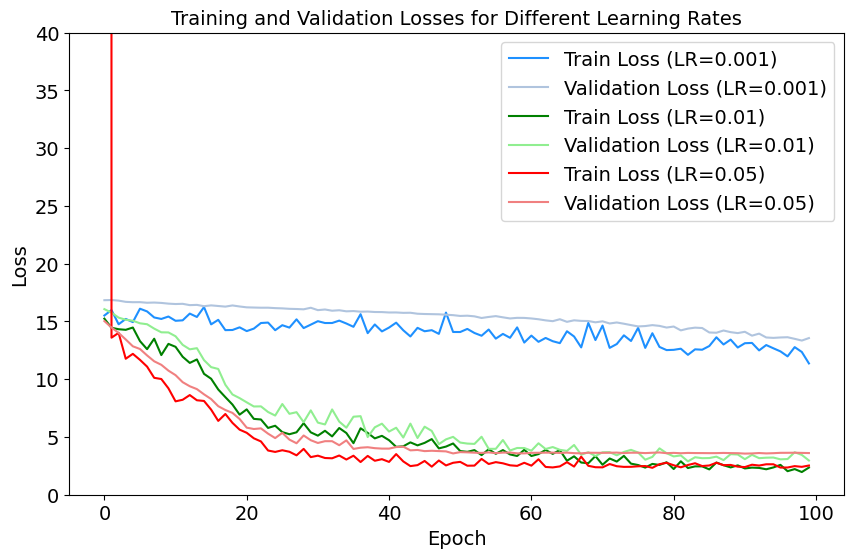

In [28]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define a list of learning rates to experiment with
learning_rates = [0.001, 0.01, 0.05]

# Lists to store train and validation losses for each learning rate
train_loss_per_lr = []
val_loss_per_lr = []

# Rest of your code remains the same
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cVAE_classifier(input_dimension=148, latent_dim=4).to(device)

# Colors for lines
train_colors = ['dodgerblue', 'green', 'red']  # Shades of blue for training
val_colors = ['lightsteelblue', 'lightgreen', 'lightcoral']  # Lighter shades for validation

# Iterate through different learning rates
for lr_idx, lr in enumerate(learning_rates):
    print(f"Training with learning rate: {lr}")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loss_list = []  # List to store train losses
    val_loss_list = []  # List to store validation losses

    model = cVAE_classifier(input_dimension=148, latent_dim=4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    classifier_criterion = nn.MSELoss()

    num_epochs = 100
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1} of {num_epochs}")
        # Train the model
        (train_loss_autism,
         train_loss_no_autism,
         train_age_loss_autism,
         train_age_loss_no_autism) = train(model,
            train_dataloader,
            train_dataset,
            device,
            optimizer,
            criterion,
            classifier_criterion,
        )

        # Validate the model
        (val_loss_autism, val_loss_no_autism,
         val_age_loss_autism, val_age_loss_no_autism) = validate(model, val_dataloader, val_dataset, device, criterion, classifier_criterion)

        # Appending the loss values to a list to allow for visualizations:
        train_loss_list.append(
            train_loss_autism
            + train_loss_no_autism
            + train_age_loss_autism
            + train_age_loss_no_autism
           )
        val_loss_list.append(
            val_loss_autism
            + val_loss_no_autism
            + val_age_loss_autism
            + val_age_loss_no_autism
        )

        # Print the losses
        print(
            f"Train Loss Autism: {train_loss_autism:.4f}, Train Loss Non-Autism: {train_loss_no_autism:.4f},"
            f"Train Age Loss Autism: {train_age_loss_autism:.4f}, Train Age Loss Non-Autism: {train_age_loss_no_autism:.4f}"
        )

    # Store train and validation losses for this learning rate
    train_loss_per_lr.append(train_loss_list)
    val_loss_per_lr.append(val_loss_list)

# Plot the training and validation losses for each learning rate
plt.figure(figsize=(10, 6))
for i, lr in enumerate(learning_rates):
    plt.plot(train_loss_per_lr[i], label=f"Train Loss (LR={lr})", color=train_colors[i])
    plt.plot(val_loss_per_lr[i], label=f"Validation Loss (LR={lr})", color=val_colors[i])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for Different Learning Rates')
plt.legend()
plt.ylim(0, 40)  # Set y-axis limits
plt.show()


I have previously also experimented with higher learning rates. However, the instability of the model lead to poorer performance. As with 100 episodes, I achieve an equally as good performance using 0.01, but the model learns more stable. I chose this value. When inspecting models with 0.05, sometimes the various components of the model spikes up and down in their loss, but with 0.01, there was more so a gradual decrease among them.

Here is ChatGPTs answer as to why the learning rate may not matter that much with ADAM:
  > "The learning rate in the ADAM optimizer can be considered as an adaptive factor that adjusts during training based on the estimates of the first and second moments of the gradients. This adaptability allows ADAM to automatically adjust the learning rate for different parameters, which can be advantageous in terms of convergence speed and stability. As a result, the initial choice of learning rate becomes less critical compared to traditional optimizers, as ADAM's adaptive behavior helps mitigate the need for manual fine-tuning of the learning rate. This adaptability can often lead to reasonable training performance even with a wider range of initial learning rate choices, making ADAM more forgiving in practice."


Here is the final training loop with the chosen parameters. Note that the learning rate is .05, which is higher than the preset learning rate.

Epoch 1 of 100


4it [00:00, 42.89it/s]               
3it [00:00, 77.81it/s]               


Train Loss Autism: 4.0658, Train Loss Non-Autism: 3.1945, Train Age Loss Autism: 3.7558, Train Age Loss Non-Autism: 3.0128
Val Loss Autism: 3.7069, Val Loss Non-Autism: 4.0058, Val Age Loss Autism: 3.5286, Val Age Loss Non-Autism: 3.9042
Epoch 2 of 100


4it [00:00, 43.75it/s]               
3it [00:00, 78.31it/s]               


Train Loss Autism: 3.8790, Train Loss Non-Autism: 3.4241, Train Age Loss Autism: 3.7296, Train Age Loss Non-Autism: 3.3424
Val Loss Autism: 3.5986, Val Loss Non-Autism: 3.8578, Val Age Loss Autism: 3.4957, Val Age Loss Non-Autism: 3.8066
Epoch 3 of 100


4it [00:00, 39.77it/s]               
3it [00:00, 66.99it/s]               


Train Loss Autism: 3.7089, Train Loss Non-Autism: 3.1083, Train Age Loss Autism: 3.6215, Train Age Loss Non-Autism: 3.0638
Val Loss Autism: 3.4693, Val Loss Non-Autism: 3.7885, Val Age Loss Autism: 3.4011, Val Age Loss Non-Autism: 3.7493
Epoch 4 of 100


4it [00:00, 47.19it/s]               
3it [00:00, 74.39it/s]               


Train Loss Autism: 3.4555, Train Loss Non-Autism: 2.9962, Train Age Loss Autism: 3.3913, Train Age Loss Non-Autism: 2.9577
Val Loss Autism: 3.2990, Val Loss Non-Autism: 3.6631, Val Age Loss Autism: 3.2380, Val Age Loss Non-Autism: 3.6230
Epoch 5 of 100


4it [00:00, 46.37it/s]               
3it [00:00, 64.35it/s]               


Train Loss Autism: 3.8438, Train Loss Non-Autism: 3.2922, Train Age Loss Autism: 3.7801, Train Age Loss Non-Autism: 3.2495
Val Loss Autism: 3.1855, Val Loss Non-Autism: 3.6646, Val Age Loss Autism: 3.0962, Val Age Loss Non-Autism: 3.5994
Epoch 6 of 100


4it [00:00, 36.50it/s]
3it [00:00, 62.55it/s]               


Train Loss Autism: 3.7589, Train Loss Non-Autism: 2.9030, Train Age Loss Autism: 3.6708, Train Age Loss Non-Autism: 2.8407
Val Loss Autism: 3.0286, Val Loss Non-Autism: 3.5467, Val Age Loss Autism: 2.8672, Val Age Loss Non-Autism: 3.4212
Epoch 7 of 100


4it [00:00, 31.20it/s]                       
3it [00:00, 57.10it/s]               


Train Loss Autism: 2.9002, Train Loss Non-Autism: 2.6242, Train Age Loss Autism: 2.7488, Train Age Loss Non-Autism: 2.5103
Val Loss Autism: 2.9784, Val Loss Non-Autism: 3.2937, Val Age Loss Autism: 2.7988, Val Age Loss Non-Autism: 3.1684
Epoch 8 of 100


4it [00:00, 32.31it/s]                       
3it [00:00, 69.42it/s]               


Train Loss Autism: 2.8631, Train Loss Non-Autism: 2.7223, Train Age Loss Autism: 2.6196, Train Age Loss Non-Autism: 2.5372
Val Loss Autism: 2.6184, Val Loss Non-Autism: 2.9369, Val Age Loss Autism: 2.1796, Val Age Loss Non-Autism: 2.5856
Epoch 9 of 100


4it [00:00, 45.80it/s]               
3it [00:00, 72.57it/s]               


Train Loss Autism: 2.4252, Train Loss Non-Autism: 2.2939, Train Age Loss Autism: 1.9874, Train Age Loss Non-Autism: 1.9447
Val Loss Autism: 2.2560, Val Loss Non-Autism: 2.8789, Val Age Loss Autism: 1.8040, Val Age Loss Non-Autism: 2.5477
Epoch 10 of 100


4it [00:00, 45.39it/s]               
3it [00:00, 58.10it/s]               


Train Loss Autism: 2.2258, Train Loss Non-Autism: 2.0622, Train Age Loss Autism: 1.7353, Train Age Loss Non-Autism: 1.6981
Val Loss Autism: 2.1183, Val Loss Non-Autism: 2.5132, Val Age Loss Autism: 1.4505, Val Age Loss Non-Autism: 2.0072
Epoch 11 of 100


4it [00:00, 40.58it/s]               
3it [00:00, 72.50it/s]               


Train Loss Autism: 2.0418, Train Loss Non-Autism: 1.9002, Train Age Loss Autism: 1.3700, Train Age Loss Non-Autism: 1.3899
Val Loss Autism: 2.1130, Val Loss Non-Autism: 2.0385, Val Age Loss Autism: 1.4626, Val Age Loss Non-Autism: 1.5755
Epoch 12 of 100


4it [00:00, 43.99it/s]               
3it [00:00, 69.44it/s]               


Train Loss Autism: 2.0575, Train Loss Non-Autism: 1.6865, Train Age Loss Autism: 1.4265, Train Age Loss Non-Autism: 1.2403
Val Loss Autism: 2.3626, Val Loss Non-Autism: 2.2796, Val Age Loss Autism: 1.7767, Val Age Loss Non-Autism: 1.8849
Epoch 13 of 100


4it [00:00, 37.11it/s]
3it [00:00, 55.06it/s]               


Train Loss Autism: 1.9729, Train Loss Non-Autism: 1.8827, Train Age Loss Autism: 1.3871, Train Age Loss Non-Autism: 1.4851
Val Loss Autism: 2.2029, Val Loss Non-Autism: 2.3587, Val Age Loss Autism: 1.6540, Val Age Loss Non-Autism: 1.9956
Epoch 14 of 100


4it [00:00, 33.29it/s]
3it [00:00, 53.13it/s]               


Train Loss Autism: 1.9676, Train Loss Non-Autism: 1.8674, Train Age Loss Autism: 1.4452, Train Age Loss Non-Autism: 1.5239
Val Loss Autism: 1.7335, Val Loss Non-Autism: 2.1228, Val Age Loss Autism: 1.2348, Val Age Loss Non-Autism: 1.7917
Epoch 15 of 100


4it [00:00, 25.44it/s]                       
3it [00:00, 34.31it/s]               


Train Loss Autism: 2.0414, Train Loss Non-Autism: 1.4151, Train Age Loss Autism: 1.5426, Train Age Loss Non-Autism: 1.0761
Val Loss Autism: 2.0951, Val Loss Non-Autism: 1.8320, Val Age Loss Autism: 1.5982, Val Age Loss Non-Autism: 1.4802
Epoch 16 of 100


4it [00:00, 19.43it/s]                       
3it [00:00, 35.61it/s]               


Train Loss Autism: 1.7317, Train Loss Non-Autism: 1.5450, Train Age Loss Autism: 1.2479, Train Age Loss Non-Autism: 1.1989
Val Loss Autism: 1.9705, Val Loss Non-Autism: 1.6287, Val Age Loss Autism: 1.5105, Val Age Loss Non-Autism: 1.2929
Epoch 17 of 100


4it [00:00, 22.50it/s]                       
3it [00:00,  6.61it/s]                       


Train Loss Autism: 1.7933, Train Loss Non-Autism: 1.4583, Train Age Loss Autism: 1.3418, Train Age Loss Non-Autism: 1.1248
Val Loss Autism: 1.8920, Val Loss Non-Autism: 2.1000, Val Age Loss Autism: 1.4452, Val Age Loss Non-Autism: 1.7613
Epoch 18 of 100


4it [00:00, 21.49it/s]                       
3it [00:00, 40.41it/s]               


Train Loss Autism: 1.9086, Train Loss Non-Autism: 1.6095, Train Age Loss Autism: 1.4654, Train Age Loss Non-Autism: 1.2709
Val Loss Autism: 2.0208, Val Loss Non-Autism: 1.7938, Val Age Loss Autism: 1.5828, Val Age Loss Non-Autism: 1.4544
Epoch 19 of 100


4it [00:00, 21.70it/s]                       
3it [00:00, 38.54it/s]               


Train Loss Autism: 1.8188, Train Loss Non-Autism: 1.3495, Train Age Loss Autism: 1.3810, Train Age Loss Non-Autism: 1.0083
Val Loss Autism: 1.9199, Val Loss Non-Autism: 1.8904, Val Age Loss Autism: 1.4857, Val Age Loss Non-Autism: 1.5491
Epoch 20 of 100


4it [00:00, 25.20it/s]                       
3it [00:00, 35.66it/s]               


Train Loss Autism: 1.9041, Train Loss Non-Autism: 1.2070, Train Age Loss Autism: 1.4823, Train Age Loss Non-Autism: 0.8774
Val Loss Autism: 2.0728, Val Loss Non-Autism: 1.7044, Val Age Loss Autism: 1.6898, Val Age Loss Non-Autism: 1.4087
Epoch 21 of 100


4it [00:00, 21.20it/s]                       
3it [00:00, 41.01it/s]               


Train Loss Autism: 1.8135, Train Loss Non-Autism: 1.4801, Train Age Loss Autism: 1.4340, Train Age Loss Non-Autism: 1.1882
Val Loss Autism: 1.9840, Val Loss Non-Autism: 2.0688, Val Age Loss Autism: 1.5883, Val Age Loss Non-Autism: 1.7564
Epoch 22 of 100


4it [00:00, 21.10it/s]                       
3it [00:00, 24.44it/s]


Train Loss Autism: 2.0206, Train Loss Non-Autism: 1.4528, Train Age Loss Autism: 1.6101, Train Age Loss Non-Autism: 1.1292
Val Loss Autism: 1.9005, Val Loss Non-Autism: 1.6591, Val Age Loss Autism: 1.4827, Val Age Loss Non-Autism: 1.3247
Epoch 23 of 100


4it [00:00, 20.78it/s]                       
3it [00:00, 41.57it/s]               


Train Loss Autism: 1.6632, Train Loss Non-Autism: 1.4754, Train Age Loss Autism: 1.2565, Train Age Loss Non-Autism: 1.1561
Val Loss Autism: 1.8437, Val Loss Non-Autism: 1.8156, Val Age Loss Autism: 1.5015, Val Age Loss Non-Autism: 1.5569
Epoch 24 of 100


4it [00:00, 24.28it/s]                       
3it [00:00, 38.08it/s]               


Train Loss Autism: 1.3884, Train Loss Non-Autism: 1.2814, Train Age Loss Autism: 1.0312, Train Age Loss Non-Autism: 1.0073
Val Loss Autism: 1.6458, Val Loss Non-Autism: 1.8548, Val Age Loss Autism: 1.2182, Val Age Loss Non-Autism: 1.5018
Epoch 25 of 100


4it [00:00, 22.47it/s]                       
3it [00:00, 38.12it/s]               


Train Loss Autism: 1.8761, Train Loss Non-Autism: 1.4191, Train Age Loss Autism: 1.4799, Train Age Loss Non-Autism: 1.1097
Val Loss Autism: 1.9346, Val Loss Non-Autism: 1.7371, Val Age Loss Autism: 1.5204, Val Age Loss Non-Autism: 1.3923
Epoch 26 of 100


4it [00:00, 23.38it/s]                       
3it [00:00, 36.79it/s]               


Train Loss Autism: 1.3824, Train Loss Non-Autism: 1.3106, Train Age Loss Autism: 0.9416, Train Age Loss Non-Autism: 0.9506
Val Loss Autism: 1.9444, Val Loss Non-Autism: 1.7955, Val Age Loss Autism: 1.6383, Val Age Loss Non-Autism: 1.5605
Epoch 27 of 100


4it [00:00, 22.92it/s]                       
3it [00:00, 39.04it/s]               


Train Loss Autism: 1.4704, Train Loss Non-Autism: 1.3623, Train Age Loss Autism: 1.1618, Train Age Loss Non-Autism: 1.1305
Val Loss Autism: 1.9846, Val Loss Non-Autism: 1.6363, Val Age Loss Autism: 1.5600, Val Age Loss Non-Autism: 1.2721
Epoch 28 of 100


4it [00:00, 23.77it/s]                       
3it [00:00, 40.86it/s]               


Train Loss Autism: 1.3706, Train Loss Non-Autism: 1.4893, Train Age Loss Autism: 0.9956, Train Age Loss Non-Autism: 1.1847
Val Loss Autism: 1.7286, Val Loss Non-Autism: 1.6230, Val Age Loss Autism: 1.2627, Val Age Loss Non-Autism: 1.2046
Epoch 29 of 100


4it [00:00, 24.22it/s]                       
3it [00:00, 49.93it/s]               


Train Loss Autism: 1.4115, Train Loss Non-Autism: 1.2036, Train Age Loss Autism: 0.9216, Train Age Loss Non-Autism: 0.7839
Val Loss Autism: 1.5455, Val Loss Non-Autism: 1.5329, Val Age Loss Autism: 1.3595, Val Age Loss Non-Autism: 1.3826
Epoch 30 of 100


4it [00:00, 63.14it/s]               
3it [00:00, 119.54it/s]              


Train Loss Autism: 1.4022, Train Loss Non-Autism: 1.0798, Train Age Loss Autism: 1.1649, Train Age Loss Non-Autism: 0.8957
Val Loss Autism: 1.4910, Val Loss Non-Autism: 1.3167, Val Age Loss Autism: 1.2306, Val Age Loss Non-Autism: 1.0910
Epoch 31 of 100


4it [00:00, 74.21it/s]               
3it [00:00, 85.83it/s]               


Train Loss Autism: 1.2966, Train Loss Non-Autism: 1.1099, Train Age Loss Autism: 1.0252, Train Age Loss Non-Autism: 0.8847
Val Loss Autism: 1.5301, Val Loss Non-Autism: 1.5856, Val Age Loss Autism: 1.2737, Val Age Loss Non-Autism: 1.3560
Epoch 32 of 100


4it [00:00, 68.44it/s]               
3it [00:00, 130.85it/s]              


Train Loss Autism: 1.1518, Train Loss Non-Autism: 1.1681, Train Age Loss Autism: 0.9150, Train Age Loss Non-Autism: 0.9711
Val Loss Autism: 1.5088, Val Loss Non-Autism: 1.4348, Val Age Loss Autism: 1.1836, Val Age Loss Non-Autism: 1.1254
Epoch 33 of 100


4it [00:00, 72.88it/s]               
3it [00:00, 112.10it/s]              


Train Loss Autism: 1.2340, Train Loss Non-Autism: 0.9650, Train Age Loss Autism: 0.9492, Train Age Loss Non-Autism: 0.7171
Val Loss Autism: 1.2860, Val Loss Non-Autism: 1.4007, Val Age Loss Autism: 1.1669, Val Age Loss Non-Autism: 1.3137
Epoch 34 of 100


4it [00:00, 75.45it/s]               
3it [00:00, 105.73it/s]              


Train Loss Autism: 1.2835, Train Loss Non-Autism: 0.9313, Train Age Loss Autism: 1.0572, Train Age Loss Non-Autism: 0.7404
Val Loss Autism: 1.2089, Val Loss Non-Autism: 1.2132, Val Age Loss Autism: 0.8972, Val Age Loss Non-Autism: 0.9178
Epoch 35 of 100


4it [00:00, 77.12it/s]               
3it [00:00, 121.78it/s]              


Train Loss Autism: 1.2530, Train Loss Non-Autism: 1.0414, Train Age Loss Autism: 1.0204, Train Age Loss Non-Autism: 0.8578
Val Loss Autism: 1.2274, Val Loss Non-Autism: 0.9881, Val Age Loss Autism: 1.1183, Val Age Loss Non-Autism: 0.9058
Epoch 36 of 100


4it [00:00, 65.87it/s]               
3it [00:00, 112.59it/s]              


Train Loss Autism: 0.9328, Train Loss Non-Autism: 0.8483, Train Age Loss Autism: 0.7614, Train Age Loss Non-Autism: 0.7173
Val Loss Autism: 1.1469, Val Loss Non-Autism: 1.1189, Val Age Loss Autism: 0.9638, Val Age Loss Non-Autism: 0.9396
Epoch 37 of 100


4it [00:00, 72.14it/s]               
3it [00:00, 129.80it/s]              


Train Loss Autism: 1.0472, Train Loss Non-Autism: 0.8970, Train Age Loss Autism: 0.8718, Train Age Loss Non-Autism: 0.7494
Val Loss Autism: 1.0927, Val Loss Non-Autism: 0.9938, Val Age Loss Autism: 0.8971, Val Age Loss Non-Autism: 0.7960
Epoch 38 of 100


4it [00:00, 61.37it/s]               
3it [00:00, 116.76it/s]              


Train Loss Autism: 0.9801, Train Loss Non-Autism: 0.9642, Train Age Loss Autism: 0.7868, Train Age Loss Non-Autism: 0.7976
Val Loss Autism: 1.2037, Val Loss Non-Autism: 1.1380, Val Age Loss Autism: 1.0710, Val Age Loss Non-Autism: 0.9978
Epoch 39 of 100


4it [00:00, 71.88it/s]               
3it [00:00, 120.50it/s]              


Train Loss Autism: 1.0152, Train Loss Non-Autism: 0.8187, Train Age Loss Autism: 0.7766, Train Age Loss Non-Autism: 0.6060
Val Loss Autism: 1.1331, Val Loss Non-Autism: 1.2467, Val Age Loss Autism: 1.0760, Val Age Loss Non-Autism: 1.2049
Epoch 40 of 100


4it [00:00, 63.73it/s]               
3it [00:00, 112.13it/s]              


Train Loss Autism: 0.8917, Train Loss Non-Autism: 0.7401, Train Age Loss Autism: 0.7897, Train Age Loss Non-Autism: 0.6622
Val Loss Autism: 1.2101, Val Loss Non-Autism: 1.0278, Val Age Loss Autism: 1.0285, Val Age Loss Non-Autism: 0.8384
Epoch 41 of 100


4it [00:00, 69.76it/s]               
3it [00:00, 123.76it/s]              


Train Loss Autism: 1.0047, Train Loss Non-Autism: 0.8011, Train Age Loss Autism: 0.8236, Train Age Loss Non-Autism: 0.6408
Val Loss Autism: 1.0453, Val Loss Non-Autism: 0.9089, Val Age Loss Autism: 0.9646, Val Age Loss Non-Autism: 0.8185
Epoch 42 of 100


4it [00:00, 57.27it/s]               
3it [00:00, 110.01it/s]              


Train Loss Autism: 0.7474, Train Loss Non-Autism: 0.7266, Train Age Loss Autism: 0.6230, Train Age Loss Non-Autism: 0.6204
Val Loss Autism: 1.0045, Val Loss Non-Autism: 0.9804, Val Age Loss Autism: 0.8871, Val Age Loss Non-Autism: 0.8502
Epoch 43 of 100


4it [00:00, 77.11it/s]               
3it [00:00, 105.72it/s]              


Train Loss Autism: 0.8937, Train Loss Non-Autism: 0.5969, Train Age Loss Autism: 0.7552, Train Age Loss Non-Autism: 0.4779
Val Loss Autism: 1.0338, Val Loss Non-Autism: 0.8773, Val Age Loss Autism: 0.9523, Val Age Loss Non-Autism: 0.7835
Epoch 44 of 100


4it [00:00, 67.03it/s]               
3it [00:00, 122.15it/s]              


Train Loss Autism: 0.6762, Train Loss Non-Autism: 0.7740, Train Age Loss Autism: 0.5737, Train Age Loss Non-Autism: 0.6894
Val Loss Autism: 0.9580, Val Loss Non-Autism: 0.7999, Val Age Loss Autism: 0.8932, Val Age Loss Non-Autism: 0.7236
Epoch 45 of 100


4it [00:00, 68.79it/s]               
3it [00:00, 135.43it/s]              


Train Loss Autism: 0.6286, Train Loss Non-Autism: 0.5996, Train Age Loss Autism: 0.5298, Train Age Loss Non-Autism: 0.5139
Val Loss Autism: 0.9421, Val Loss Non-Autism: 0.8311, Val Age Loss Autism: 0.8749, Val Age Loss Non-Autism: 0.7485
Epoch 46 of 100


4it [00:00, 66.30it/s]               
3it [00:00, 126.14it/s]              


Train Loss Autism: 0.7622, Train Loss Non-Autism: 0.5968, Train Age Loss Autism: 0.6786, Train Age Loss Non-Autism: 0.5208
Val Loss Autism: 0.9281, Val Loss Non-Autism: 0.7922, Val Age Loss Autism: 0.8640, Val Age Loss Non-Autism: 0.7134
Epoch 47 of 100


4it [00:00, 70.25it/s]               
3it [00:00, 96.22it/s]               


Train Loss Autism: 0.7432, Train Loss Non-Autism: 0.5888, Train Age Loss Autism: 0.6491, Train Age Loss Non-Autism: 0.5038
Val Loss Autism: 0.9102, Val Loss Non-Autism: 0.7809, Val Age Loss Autism: 0.8509, Val Age Loss Non-Autism: 0.7142
Epoch 48 of 100


4it [00:00, 68.39it/s]               
3it [00:00, 103.30it/s]              


Train Loss Autism: 0.8081, Train Loss Non-Autism: 0.5796, Train Age Loss Autism: 0.7384, Train Age Loss Non-Autism: 0.5152
Val Loss Autism: 0.8864, Val Loss Non-Autism: 0.7963, Val Age Loss Autism: 0.8357, Val Age Loss Non-Autism: 0.7434
Epoch 49 of 100


4it [00:00, 73.07it/s]               
3it [00:00, 90.15it/s]               


Train Loss Autism: 0.7026, Train Loss Non-Autism: 0.6216, Train Age Loss Autism: 0.6433, Train Age Loss Non-Autism: 0.5647
Val Loss Autism: 0.9348, Val Loss Non-Autism: 0.8311, Val Age Loss Autism: 0.8862, Val Age Loss Non-Autism: 0.7796
Epoch 50 of 100


4it [00:00, 75.89it/s]               
3it [00:00, 113.24it/s]              


Train Loss Autism: 0.7816, Train Loss Non-Autism: 0.6353, Train Age Loss Autism: 0.7265, Train Age Loss Non-Autism: 0.5804
Val Loss Autism: 0.9311, Val Loss Non-Autism: 0.8248, Val Age Loss Autism: 0.8786, Val Age Loss Non-Autism: 0.7659
Epoch 51 of 100


4it [00:00, 74.56it/s]               
3it [00:00, 134.46it/s]              


Train Loss Autism: 0.6327, Train Loss Non-Autism: 0.5997, Train Age Loss Autism: 0.5634, Train Age Loss Non-Autism: 0.5333
Val Loss Autism: 0.8407, Val Loss Non-Autism: 0.7365, Val Age Loss Autism: 0.7940, Val Age Loss Non-Autism: 0.6831
Epoch 52 of 100


4it [00:00, 60.85it/s]               
3it [00:00, 136.48it/s]              


Train Loss Autism: 0.6548, Train Loss Non-Autism: 0.5237, Train Age Loss Autism: 0.6034, Train Age Loss Non-Autism: 0.4712
Val Loss Autism: 0.9136, Val Loss Non-Autism: 0.6952, Val Age Loss Autism: 0.8717, Val Age Loss Non-Autism: 0.6517
Epoch 53 of 100


4it [00:00, 74.89it/s]               
3it [00:00, 126.62it/s]              


Train Loss Autism: 0.8636, Train Loss Non-Autism: 0.6304, Train Age Loss Autism: 0.8155, Train Age Loss Non-Autism: 0.5820
Val Loss Autism: 0.9991, Val Loss Non-Autism: 0.8372, Val Age Loss Autism: 0.9433, Val Age Loss Non-Autism: 0.7687
Epoch 54 of 100


4it [00:00, 74.29it/s]               
3it [00:00, 111.41it/s]              


Train Loss Autism: 0.8171, Train Loss Non-Autism: 0.6652, Train Age Loss Autism: 0.7353, Train Age Loss Non-Autism: 0.5898
Val Loss Autism: 0.9503, Val Loss Non-Autism: 0.7756, Val Age Loss Autism: 0.8997, Val Age Loss Non-Autism: 0.7167
Epoch 55 of 100


4it [00:00, 66.66it/s]               
3it [00:00, 127.86it/s]              


Train Loss Autism: 0.6435, Train Loss Non-Autism: 0.5975, Train Age Loss Autism: 0.5796, Train Age Loss Non-Autism: 0.5345
Val Loss Autism: 0.9100, Val Loss Non-Autism: 0.7379, Val Age Loss Autism: 0.8519, Val Age Loss Non-Autism: 0.6701
Epoch 56 of 100


4it [00:00, 66.42it/s]               
3it [00:00, 88.95it/s]               


Train Loss Autism: 0.7407, Train Loss Non-Autism: 0.5878, Train Age Loss Autism: 0.6647, Train Age Loss Non-Autism: 0.5142
Val Loss Autism: 0.9641, Val Loss Non-Autism: 0.7833, Val Age Loss Autism: 0.8931, Val Age Loss Non-Autism: 0.6977
Epoch 57 of 100


4it [00:00, 71.03it/s]               
3it [00:00, 87.99it/s]               


Train Loss Autism: 0.7189, Train Loss Non-Autism: 0.5849, Train Age Loss Autism: 0.6279, Train Age Loss Non-Autism: 0.4997
Val Loss Autism: 0.8487, Val Loss Non-Autism: 0.7723, Val Age Loss Autism: 0.7863, Val Age Loss Non-Autism: 0.6993
Epoch 58 of 100


4it [00:00, 74.41it/s]               
3it [00:00, 124.32it/s]              


Train Loss Autism: 0.6141, Train Loss Non-Autism: 0.5419, Train Age Loss Autism: 0.5334, Train Age Loss Non-Autism: 0.4634
Val Loss Autism: 0.8763, Val Loss Non-Autism: 0.7369, Val Age Loss Autism: 0.8049, Val Age Loss Non-Autism: 0.6490
Epoch 59 of 100


4it [00:00, 60.61it/s]               
3it [00:00, 126.82it/s]              


Train Loss Autism: 0.6992, Train Loss Non-Autism: 0.6040, Train Age Loss Autism: 0.6092, Train Age Loss Non-Autism: 0.5177
Val Loss Autism: 0.8605, Val Loss Non-Autism: 0.7776, Val Age Loss Autism: 0.7941, Val Age Loss Non-Autism: 0.6974
Epoch 60 of 100


4it [00:00, 70.68it/s]               
3it [00:00, 109.47it/s]              


Train Loss Autism: 0.6897, Train Loss Non-Autism: 0.6359, Train Age Loss Autism: 0.6052, Train Age Loss Non-Autism: 0.5540
Val Loss Autism: 0.9467, Val Loss Non-Autism: 0.8164, Val Age Loss Autism: 0.8799, Val Age Loss Non-Autism: 0.7387
Epoch 61 of 100


4it [00:00, 74.43it/s]               
3it [00:00, 126.48it/s]              


Train Loss Autism: 0.5997, Train Loss Non-Autism: 0.5963, Train Age Loss Autism: 0.5205, Train Age Loss Non-Autism: 0.5180
Val Loss Autism: 0.9203, Val Loss Non-Autism: 0.8022, Val Age Loss Autism: 0.8521, Val Age Loss Non-Autism: 0.7239
Epoch 62 of 100


4it [00:00, 58.73it/s]               
3it [00:00, 127.53it/s]              


Train Loss Autism: 0.6045, Train Loss Non-Autism: 0.6168, Train Age Loss Autism: 0.5254, Train Age Loss Non-Autism: 0.5419
Val Loss Autism: 0.9079, Val Loss Non-Autism: 0.7540, Val Age Loss Autism: 0.8553, Val Age Loss Non-Autism: 0.6966
Epoch 63 of 100


4it [00:00, 69.34it/s]               
3it [00:00, 112.26it/s]              


Train Loss Autism: 0.6931, Train Loss Non-Autism: 0.5145, Train Age Loss Autism: 0.6375, Train Age Loss Non-Autism: 0.4592
Val Loss Autism: 0.9837, Val Loss Non-Autism: 0.8775, Val Age Loss Autism: 0.9410, Val Age Loss Non-Autism: 0.8288
Epoch 64 of 100


4it [00:00, 66.92it/s]               
3it [00:00, 129.75it/s]              


Train Loss Autism: 0.6510, Train Loss Non-Autism: 0.5209, Train Age Loss Autism: 0.5996, Train Age Loss Non-Autism: 0.4705
Val Loss Autism: 0.8567, Val Loss Non-Autism: 0.7760, Val Age Loss Autism: 0.8113, Val Age Loss Non-Autism: 0.7238
Epoch 65 of 100


4it [00:00, 72.55it/s]               
3it [00:00, 138.69it/s]              


Train Loss Autism: 0.6503, Train Loss Non-Autism: 0.5033, Train Age Loss Autism: 0.5944, Train Age Loss Non-Autism: 0.4491
Val Loss Autism: 0.9214, Val Loss Non-Autism: 0.8090, Val Age Loss Autism: 0.8773, Val Age Loss Non-Autism: 0.7600
Epoch 66 of 100


4it [00:00, 73.09it/s]               
3it [00:00, 116.49it/s]              


Train Loss Autism: 0.6153, Train Loss Non-Autism: 0.5101, Train Age Loss Autism: 0.5630, Train Age Loss Non-Autism: 0.4572
Val Loss Autism: 0.9376, Val Loss Non-Autism: 0.7853, Val Age Loss Autism: 0.8886, Val Age Loss Non-Autism: 0.7297
Epoch 67 of 100


4it [00:00, 70.35it/s]               
3it [00:00, 122.33it/s]              


Train Loss Autism: 0.6334, Train Loss Non-Autism: 0.5300, Train Age Loss Autism: 0.5771, Train Age Loss Non-Autism: 0.4738
Val Loss Autism: 0.9846, Val Loss Non-Autism: 0.8582, Val Age Loss Autism: 0.9348, Val Age Loss Non-Autism: 0.8008
Epoch 68 of 100


4it [00:00, 72.44it/s]               
3it [00:00, 131.34it/s]              


Train Loss Autism: 0.6146, Train Loss Non-Autism: 0.6568, Train Age Loss Autism: 0.5551, Train Age Loss Non-Autism: 0.5988
Val Loss Autism: 0.9141, Val Loss Non-Autism: 0.8564, Val Age Loss Autism: 0.8758, Val Age Loss Non-Autism: 0.8119
Epoch 69 of 100


4it [00:00, 62.35it/s]               
3it [00:00, 121.91it/s]              


Train Loss Autism: 0.8261, Train Loss Non-Autism: 0.6054, Train Age Loss Autism: 0.7777, Train Age Loss Non-Autism: 0.5574
Val Loss Autism: 0.8080, Val Loss Non-Autism: 0.8315, Val Age Loss Autism: 0.7607, Val Age Loss Non-Autism: 0.7758
Epoch 70 of 100


4it [00:00, 75.56it/s]               
3it [00:00, 124.52it/s]              


Train Loss Autism: 0.6672, Train Loss Non-Autism: 0.5821, Train Age Loss Autism: 0.6030, Train Age Loss Non-Autism: 0.5216
Val Loss Autism: 0.8360, Val Loss Non-Autism: 0.7447, Val Age Loss Autism: 0.7829, Val Age Loss Non-Autism: 0.6835
Epoch 71 of 100


4it [00:00, 77.54it/s]               
3it [00:00, 115.92it/s]              


Train Loss Autism: 0.5874, Train Loss Non-Autism: 0.6041, Train Age Loss Autism: 0.5201, Train Age Loss Non-Autism: 0.5390
Val Loss Autism: 0.8827, Val Loss Non-Autism: 0.8438, Val Age Loss Autism: 0.8219, Val Age Loss Non-Autism: 0.7753
Epoch 72 of 100


4it [00:00, 57.63it/s]               
3it [00:00, 133.65it/s]              


Train Loss Autism: 0.6682, Train Loss Non-Autism: 0.5936, Train Age Loss Autism: 0.5875, Train Age Loss Non-Autism: 0.5160
Val Loss Autism: 0.9222, Val Loss Non-Autism: 0.7841, Val Age Loss Autism: 0.8507, Val Age Loss Non-Autism: 0.7012
Epoch 73 of 100


4it [00:00, 76.45it/s]               
3it [00:00, 118.42it/s]              


Train Loss Autism: 0.6523, Train Loss Non-Autism: 0.5304, Train Age Loss Autism: 0.5673, Train Age Loss Non-Autism: 0.4481
Val Loss Autism: 0.8910, Val Loss Non-Autism: 0.7988, Val Age Loss Autism: 0.8257, Val Age Loss Non-Autism: 0.7246
Epoch 74 of 100


4it [00:00, 77.15it/s]               
3it [00:00, 116.56it/s]              


Train Loss Autism: 0.5909, Train Loss Non-Autism: 0.5502, Train Age Loss Autism: 0.5150, Train Age Loss Non-Autism: 0.4765
Val Loss Autism: 0.8501, Val Loss Non-Autism: 0.7251, Val Age Loss Autism: 0.7921, Val Age Loss Non-Autism: 0.6585
Epoch 75 of 100


4it [00:00, 70.56it/s]               
3it [00:00, 124.48it/s]              


Train Loss Autism: 0.6525, Train Loss Non-Autism: 0.5263, Train Age Loss Autism: 0.5760, Train Age Loss Non-Autism: 0.4541
Val Loss Autism: 0.9451, Val Loss Non-Autism: 0.7209, Val Age Loss Autism: 0.8780, Val Age Loss Non-Autism: 0.6426
Epoch 76 of 100


4it [00:00, 70.72it/s]               
3it [00:00, 105.19it/s]              


Train Loss Autism: 0.7446, Train Loss Non-Autism: 0.6313, Train Age Loss Autism: 0.6567, Train Age Loss Non-Autism: 0.5472
Val Loss Autism: 0.8159, Val Loss Non-Autism: 0.8853, Val Age Loss Autism: 0.7372, Val Age Loss Non-Autism: 0.7999
Epoch 77 of 100


4it [00:00, 71.66it/s]               
3it [00:00, 130.65it/s]              


Train Loss Autism: 0.6620, Train Loss Non-Autism: 0.6817, Train Age Loss Autism: 0.5715, Train Age Loss Non-Autism: 0.5922
Val Loss Autism: 0.8092, Val Loss Non-Autism: 0.7143, Val Age Loss Autism: 0.7369, Val Age Loss Non-Autism: 0.6324
Epoch 78 of 100


4it [00:00, 62.11it/s]               
3it [00:00, 115.03it/s]              


Train Loss Autism: 0.7360, Train Loss Non-Autism: 0.5436, Train Age Loss Autism: 0.6595, Train Age Loss Non-Autism: 0.4687
Val Loss Autism: 0.8625, Val Loss Non-Autism: 0.8244, Val Age Loss Autism: 0.8074, Val Age Loss Non-Autism: 0.7581
Epoch 79 of 100


4it [00:00, 71.38it/s]               
3it [00:00, 125.36it/s]              


Train Loss Autism: 0.6563, Train Loss Non-Autism: 0.5451, Train Age Loss Autism: 0.5751, Train Age Loss Non-Autism: 0.4702
Val Loss Autism: 0.9502, Val Loss Non-Autism: 0.8949, Val Age Loss Autism: 0.8939, Val Age Loss Non-Autism: 0.8352
Epoch 80 of 100


4it [00:00, 71.54it/s]               
3it [00:00, 112.72it/s]              


Train Loss Autism: 0.8736, Train Loss Non-Autism: 0.6467, Train Age Loss Autism: 0.8105, Train Age Loss Non-Autism: 0.5840
Val Loss Autism: 0.8868, Val Loss Non-Autism: 0.8141, Val Age Loss Autism: 0.8158, Val Age Loss Non-Autism: 0.7304
Epoch 81 of 100


4it [00:00, 64.84it/s]               
3it [00:00, 99.26it/s]               


Train Loss Autism: 0.6454, Train Loss Non-Autism: 0.5172, Train Age Loss Autism: 0.5488, Train Age Loss Non-Autism: 0.4304
Val Loss Autism: 0.8978, Val Loss Non-Autism: 0.7767, Val Age Loss Autism: 0.8457, Val Age Loss Non-Autism: 0.7195
Epoch 82 of 100


4it [00:00, 62.65it/s]               
3it [00:00, 99.57it/s]               


Train Loss Autism: 0.6373, Train Loss Non-Autism: 0.5125, Train Age Loss Autism: 0.5824, Train Age Loss Non-Autism: 0.4585
Val Loss Autism: 0.9087, Val Loss Non-Autism: 0.7765, Val Age Loss Autism: 0.8646, Val Age Loss Non-Autism: 0.7241
Epoch 83 of 100


4it [00:00, 73.37it/s]               
3it [00:00, 132.05it/s]              


Train Loss Autism: 0.6954, Train Loss Non-Autism: 0.5571, Train Age Loss Autism: 0.6324, Train Age Loss Non-Autism: 0.4986
Val Loss Autism: 0.8927, Val Loss Non-Autism: 0.7688, Val Age Loss Autism: 0.8447, Val Age Loss Non-Autism: 0.7108
Epoch 84 of 100


4it [00:00, 65.04it/s]               
3it [00:00, 110.69it/s]              


Train Loss Autism: 0.6863, Train Loss Non-Autism: 0.5528, Train Age Loss Autism: 0.6281, Train Age Loss Non-Autism: 0.4973
Val Loss Autism: 0.8528, Val Loss Non-Autism: 0.8106, Val Age Loss Autism: 0.8100, Val Age Loss Non-Autism: 0.7603
Epoch 85 of 100


4it [00:00, 62.77it/s]               
3it [00:00, 121.69it/s]              


Train Loss Autism: 0.7023, Train Loss Non-Autism: 0.6109, Train Age Loss Autism: 0.6437, Train Age Loss Non-Autism: 0.5545
Val Loss Autism: 0.9306, Val Loss Non-Autism: 0.8144, Val Age Loss Autism: 0.8703, Val Age Loss Non-Autism: 0.7434
Epoch 86 of 100


4it [00:00, 66.88it/s]               
3it [00:00, 110.41it/s]              


Train Loss Autism: 0.7983, Train Loss Non-Autism: 0.5347, Train Age Loss Autism: 0.7249, Train Age Loss Non-Autism: 0.4646
Val Loss Autism: 0.9961, Val Loss Non-Autism: 0.7700, Val Age Loss Autism: 0.9382, Val Age Loss Non-Autism: 0.7034
Epoch 87 of 100


4it [00:00, 57.66it/s]               
3it [00:00, 114.55it/s]              


Train Loss Autism: 0.6758, Train Loss Non-Autism: 0.5539, Train Age Loss Autism: 0.6010, Train Age Loss Non-Autism: 0.4833
Val Loss Autism: 0.9177, Val Loss Non-Autism: 0.8356, Val Age Loss Autism: 0.8554, Val Age Loss Non-Autism: 0.7639
Epoch 88 of 100


4it [00:00, 72.05it/s]               
3it [00:00, 114.72it/s]              


Train Loss Autism: 0.6340, Train Loss Non-Autism: 0.5782, Train Age Loss Autism: 0.5557, Train Age Loss Non-Autism: 0.5042
Val Loss Autism: 0.8444, Val Loss Non-Autism: 0.8723, Val Age Loss Autism: 0.7754, Val Age Loss Non-Autism: 0.7872
Epoch 89 of 100


4it [00:00, 64.65it/s]               
3it [00:00, 108.04it/s]              


Train Loss Autism: 0.5986, Train Loss Non-Autism: 0.6125, Train Age Loss Autism: 0.4947, Train Age Loss Non-Autism: 0.5194
Val Loss Autism: 0.8503, Val Loss Non-Autism: 0.7737, Val Age Loss Autism: 0.7690, Val Age Loss Non-Autism: 0.6792
Epoch 90 of 100


4it [00:00, 72.92it/s]               
3it [00:00, 111.21it/s]              


Train Loss Autism: 0.6338, Train Loss Non-Autism: 0.5609, Train Age Loss Autism: 0.5388, Train Age Loss Non-Autism: 0.4700
Val Loss Autism: 0.7954, Val Loss Non-Autism: 0.7804, Val Age Loss Autism: 0.7182, Val Age Loss Non-Autism: 0.6919
Epoch 91 of 100


4it [00:00, 76.38it/s]               
3it [00:00, 121.42it/s]              


Train Loss Autism: 0.6375, Train Loss Non-Autism: 0.5343, Train Age Loss Autism: 0.5430, Train Age Loss Non-Autism: 0.4468
Val Loss Autism: 0.8557, Val Loss Non-Autism: 0.8725, Val Age Loss Autism: 0.7868, Val Age Loss Non-Autism: 0.7928
Epoch 92 of 100


4it [00:00, 50.82it/s]               
3it [00:00, 117.08it/s]              


Train Loss Autism: 0.6350, Train Loss Non-Autism: 0.6036, Train Age Loss Autism: 0.5449, Train Age Loss Non-Autism: 0.5169
Val Loss Autism: 0.9223, Val Loss Non-Autism: 0.7741, Val Age Loss Autism: 0.8352, Val Age Loss Non-Autism: 0.6662
Epoch 93 of 100


4it [00:00, 70.31it/s]               
3it [00:00, 115.22it/s]              


Train Loss Autism: 0.7816, Train Loss Non-Autism: 0.5768, Train Age Loss Autism: 0.6753, Train Age Loss Non-Autism: 0.4779
Val Loss Autism: 0.9654, Val Loss Non-Autism: 0.8846, Val Age Loss Autism: 0.8914, Val Age Loss Non-Autism: 0.8032
Epoch 94 of 100


4it [00:00, 73.27it/s]               
3it [00:00, 110.52it/s]              


Train Loss Autism: 0.9595, Train Loss Non-Autism: 0.6336, Train Age Loss Autism: 0.8779, Train Age Loss Non-Autism: 0.5555
Val Loss Autism: 0.9799, Val Loss Non-Autism: 0.7686, Val Age Loss Autism: 0.9004, Val Age Loss Non-Autism: 0.6770
Epoch 95 of 100


4it [00:00, 65.71it/s]               
3it [00:00, 114.37it/s]              


Train Loss Autism: 0.6931, Train Loss Non-Autism: 0.5736, Train Age Loss Autism: 0.5925, Train Age Loss Non-Autism: 0.4832
Val Loss Autism: 0.8585, Val Loss Non-Autism: 0.7841, Val Age Loss Autism: 0.7999, Val Age Loss Non-Autism: 0.7222
Epoch 96 of 100


4it [00:00, 73.75it/s]               
3it [00:00, 129.94it/s]              


Train Loss Autism: 0.8454, Train Loss Non-Autism: 0.5580, Train Age Loss Autism: 0.7838, Train Age Loss Non-Autism: 0.4954
Val Loss Autism: 0.8496, Val Loss Non-Autism: 0.7888, Val Age Loss Autism: 0.7694, Val Age Loss Non-Autism: 0.6846
Epoch 97 of 100


4it [00:00, 67.84it/s]               
3it [00:00, 130.86it/s]              


Train Loss Autism: 0.6498, Train Loss Non-Autism: 0.5589, Train Age Loss Autism: 0.5334, Train Age Loss Non-Autism: 0.4562
Val Loss Autism: 0.9518, Val Loss Non-Autism: 0.8122, Val Age Loss Autism: 0.9050, Val Age Loss Non-Autism: 0.7609
Epoch 98 of 100


4it [00:00, 58.61it/s]               
3it [00:00, 122.12it/s]              


Train Loss Autism: 0.8699, Train Loss Non-Autism: 0.5513, Train Age Loss Autism: 0.8175, Train Age Loss Non-Autism: 0.4978
Val Loss Autism: 0.9353, Val Loss Non-Autism: 0.8919, Val Age Loss Autism: 0.8761, Val Age Loss Non-Autism: 0.8222
Epoch 99 of 100


4it [00:00, 59.77it/s]               
3it [00:00, 111.75it/s]              


Train Loss Autism: 0.6656, Train Loss Non-Autism: 0.7116, Train Age Loss Autism: 0.5811, Train Age Loss Non-Autism: 0.6351
Val Loss Autism: 0.9284, Val Loss Non-Autism: 0.7759, Val Age Loss Autism: 0.8644, Val Age Loss Non-Autism: 0.7048
Epoch 100 of 100


4it [00:00, 73.39it/s]               
3it [00:00, 114.24it/s]              


Train Loss Autism: 0.6406, Train Loss Non-Autism: 0.5309, Train Age Loss Autism: 0.5655, Train Age Loss Non-Autism: 0.4577
Val Loss Autism: 0.8399, Val Loss Non-Autism: 0.7977, Val Age Loss Autism: 0.7674, Val Age Loss Non-Autism: 0.7143


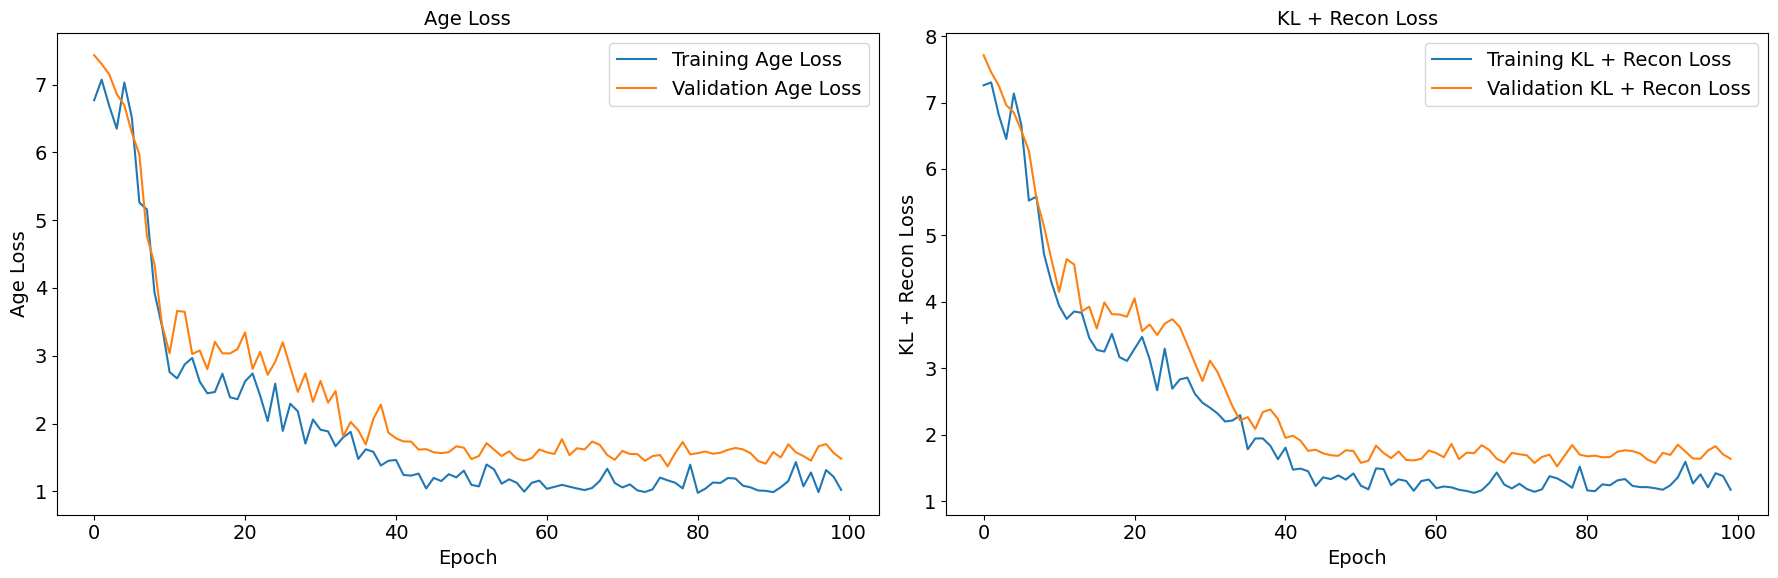

In [29]:
lr = 0.01
model_classifier = cVAE_classifier(input_dimension=148, latent_dim=16).to(device)
optimizer = torch.optim.Adam(model_classifier.parameters(), lr=lr)
criterion = nn.MSELoss()
classifier_criterion = nn.MSELoss()

# Create separate lists for training and validation losses for age, FIQ, and other terms
train_age_losses = []
val_age_losses = []
train_fiq_losses = []
val_fiq_losses = []
train_other_losses = []
val_other_losses = []

num_epochs = 100
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} of {num_epochs}")
    # Train the model
    (train_loss_autism,
     train_loss_no_autism,
     train_age_loss_autism,
     train_age_loss_no_autism) = train(
        model_classifier,
        train_dataloader,
        train_dataset,
        device,
        optimizer,
        criterion,
        classifier_criterion)

    # Validate the model
    (val_loss_autism, val_loss_no_autism, val_age_loss_autism, val_age_loss_no_autism) = validate(model_classifier, val_dataloader, val_dataset, device, criterion, classifier_criterion)

    # Appending the loss values to their respective lists for visualizations:
    train_age_losses.append(train_age_loss_autism + train_age_loss_no_autism)
    train_other_losses.append(train_loss_autism + train_loss_no_autism)

    val_age_losses.append(val_age_loss_autism + val_age_loss_no_autism)
    val_other_losses.append(val_loss_autism + val_loss_no_autism)

    print(
        f"Train Loss Autism: {train_loss_autism:.4f}, Train Loss Non-Autism: {train_loss_no_autism:.4f}, "
        f"Train Age Loss Autism: {train_age_loss_autism:.4f}, Train Age Loss Non-Autism: {train_age_loss_no_autism:.4f}"
    )

    print(
        f"Val Loss Autism: {val_loss_autism:.4f}, Val Loss Non-Autism: {val_loss_no_autism:.4f}, "
        f"Val Age Loss Autism: {val_age_loss_autism:.4f}, Val Age Loss Non-Autism: {val_age_loss_no_autism:.4f}"
    )

# Create subplots for loss in relation to age, FIQ, and other loss terms
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot training and validation losses for age
axs[0].plot(train_age_losses, label='Training Age Loss')
axs[0].plot(val_age_losses, label='Validation Age Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Age Loss')
axs[0].set_title('Age Loss')
axs[0].legend()

# Plot training and validation losses for other terms (KL divergence + Reconstruction loss)
axs[1].plot(train_other_losses, label='Training KL + Recon Loss')
axs[1].plot(val_other_losses, label='Validation KL + Recon Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('KL + Recon Loss')
axs[1].set_title('KL + Recon Loss')
axs[1].legend()

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()


Well, it seems like this was not the greatest idea I ever had. Let's save the previous model.

Let's save this model.

In [ ]:
torch.save(model_classifier.state_dict(), 'model_basic_classifier.pth')

In [ ]:
model_classifier = cVAE_classifier(input_dimension = 148, latent_dim= 16).to(device)
model_classifier.load_state_dict(torch.load('model_basic_classifier.pth'))

<All keys matched successfully>

Next, here is the training for the model wihtout a classifier.

4it [00:00, 66.36it/s]               
3it [00:00, 73.84it/s]               


Epoch [1/100]
Train Loss Autism: 0.3322, Train Loss Non-Autism: 0.2117
Val Loss Autism: 0.1742, Val Loss Non-Autism: 0.1415


4it [00:00, 55.65it/s]               
3it [00:00, 74.97it/s]               


Epoch [2/100]
Train Loss Autism: 0.1150, Train Loss Non-Autism: 0.0937
Val Loss Autism: 0.0800, Val Loss Non-Autism: 0.0546


4it [00:00, 51.54it/s]               
3it [00:00, 79.92it/s]               


Epoch [3/100]
Train Loss Autism: 0.0519, Train Loss Non-Autism: 0.0367
Val Loss Autism: 0.0414, Val Loss Non-Autism: 0.0303


4it [00:00, 43.42it/s]               
3it [00:00, 85.01it/s]               


Epoch [4/100]
Train Loss Autism: 0.0334, Train Loss Non-Autism: 0.0258
Val Loss Autism: 0.0184, Val Loss Non-Autism: 0.0133


4it [00:00, 55.61it/s]               
3it [00:00, 79.76it/s]               


Epoch [5/100]
Train Loss Autism: 0.0177, Train Loss Non-Autism: 0.0137
Val Loss Autism: 0.0164, Val Loss Non-Autism: 0.0109


4it [00:00, 49.22it/s]               
3it [00:00, 81.07it/s]               


Epoch [6/100]
Train Loss Autism: 0.0140, Train Loss Non-Autism: 0.0092
Val Loss Autism: 0.0126, Val Loss Non-Autism: 0.0087


4it [00:00, 52.70it/s]               
3it [00:00, 89.84it/s]               


Epoch [7/100]
Train Loss Autism: 0.0116, Train Loss Non-Autism: 0.0087
Val Loss Autism: 0.0103, Val Loss Non-Autism: 0.0080


4it [00:00, 54.25it/s]               
3it [00:00, 84.36it/s]               


Epoch [8/100]
Train Loss Autism: 0.0090, Train Loss Non-Autism: 0.0074
Val Loss Autism: 0.0081, Val Loss Non-Autism: 0.0065


4it [00:00, 44.77it/s]               
3it [00:00, 71.82it/s]               


Epoch [9/100]
Train Loss Autism: 0.0072, Train Loss Non-Autism: 0.0060
Val Loss Autism: 0.0071, Val Loss Non-Autism: 0.0056


4it [00:00, 50.68it/s]               
3it [00:00, 88.54it/s]               


Epoch [10/100]
Train Loss Autism: 0.0070, Train Loss Non-Autism: 0.0050
Val Loss Autism: 0.0063, Val Loss Non-Autism: 0.0044


4it [00:00, 50.24it/s]               
3it [00:00, 81.26it/s]               


Epoch [11/100]
Train Loss Autism: 0.0055, Train Loss Non-Autism: 0.0044
Val Loss Autism: 0.0054, Val Loss Non-Autism: 0.0045


4it [00:00, 47.21it/s]               
3it [00:00, 86.92it/s]               


Epoch [12/100]
Train Loss Autism: 0.0052, Train Loss Non-Autism: 0.0044
Val Loss Autism: 0.0053, Val Loss Non-Autism: 0.0042


4it [00:00, 52.51it/s]               
3it [00:00, 80.60it/s]               


Epoch [13/100]
Train Loss Autism: 0.0049, Train Loss Non-Autism: 0.0041
Val Loss Autism: 0.0050, Val Loss Non-Autism: 0.0041


4it [00:00, 52.93it/s]               
3it [00:00, 88.08it/s]               


Epoch [14/100]
Train Loss Autism: 0.0048, Train Loss Non-Autism: 0.0041
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0039


4it [00:00, 50.86it/s]               
3it [00:00, 64.83it/s]               


Epoch [15/100]
Train Loss Autism: 0.0045, Train Loss Non-Autism: 0.0039
Val Loss Autism: 0.0046, Val Loss Non-Autism: 0.0038


4it [00:00, 36.26it/s]
3it [00:00, 58.89it/s]               


Epoch [16/100]
Train Loss Autism: 0.0044, Train Loss Non-Autism: 0.0037
Val Loss Autism: 0.0044, Val Loss Non-Autism: 0.0038


4it [00:00, 37.27it/s]
3it [00:00, 49.30it/s]               


Epoch [17/100]
Train Loss Autism: 0.0042, Train Loss Non-Autism: 0.0037
Val Loss Autism: 0.0044, Val Loss Non-Autism: 0.0036


4it [00:00, 46.19it/s]               
3it [00:00, 80.82it/s]               


Epoch [18/100]
Train Loss Autism: 0.0042, Train Loss Non-Autism: 0.0036
Val Loss Autism: 0.0044, Val Loss Non-Autism: 0.0037


4it [00:00, 40.76it/s]               
3it [00:00, 86.75it/s]               


Epoch [19/100]
Train Loss Autism: 0.0043, Train Loss Non-Autism: 0.0035
Val Loss Autism: 0.0042, Val Loss Non-Autism: 0.0035


4it [00:00, 55.87it/s]               
3it [00:00, 89.49it/s]               


Epoch [20/100]
Train Loss Autism: 0.0040, Train Loss Non-Autism: 0.0034
Val Loss Autism: 0.0041, Val Loss Non-Autism: 0.0035


4it [00:00, 55.25it/s]               
3it [00:00, 90.91it/s]               


Epoch [21/100]
Train Loss Autism: 0.0040, Train Loss Non-Autism: 0.0034
Val Loss Autism: 0.0043, Val Loss Non-Autism: 0.0035


4it [00:00, 55.59it/s]               
3it [00:00, 90.88it/s]               


Epoch [22/100]
Train Loss Autism: 0.0041, Train Loss Non-Autism: 0.0035
Val Loss Autism: 0.0041, Val Loss Non-Autism: 0.0035


4it [00:00, 48.63it/s]               
3it [00:00, 88.61it/s]               


Epoch [23/100]
Train Loss Autism: 0.0038, Train Loss Non-Autism: 0.0033
Val Loss Autism: 0.0042, Val Loss Non-Autism: 0.0036


4it [00:00, 55.25it/s]               
3it [00:00, 87.57it/s]               


Epoch [24/100]
Train Loss Autism: 0.0040, Train Loss Non-Autism: 0.0034
Val Loss Autism: 0.0041, Val Loss Non-Autism: 0.0034


4it [00:00, 52.32it/s]               
3it [00:00, 90.18it/s]               


Epoch [25/100]
Train Loss Autism: 0.0039, Train Loss Non-Autism: 0.0033
Val Loss Autism: 0.0040, Val Loss Non-Autism: 0.0035


4it [00:00, 54.42it/s]               
3it [00:00, 82.80it/s]               


Epoch [26/100]
Train Loss Autism: 0.0040, Train Loss Non-Autism: 0.0034
Val Loss Autism: 0.0040, Val Loss Non-Autism: 0.0035


4it [00:00, 52.40it/s]               
3it [00:00, 88.23it/s]               


Epoch [27/100]
Train Loss Autism: 0.0037, Train Loss Non-Autism: 0.0035
Val Loss Autism: 0.0039, Val Loss Non-Autism: 0.0034


4it [00:00, 53.89it/s]               
3it [00:00, 82.98it/s]               


Epoch [28/100]
Train Loss Autism: 0.0038, Train Loss Non-Autism: 0.0034
Val Loss Autism: 0.0040, Val Loss Non-Autism: 0.0035


4it [00:00, 54.87it/s]               
3it [00:00, 92.15it/s]               


Epoch [29/100]
Train Loss Autism: 0.0037, Train Loss Non-Autism: 0.0034
Val Loss Autism: 0.0041, Val Loss Non-Autism: 0.0035


4it [00:00, 55.81it/s]               
3it [00:00, 93.65it/s]               


Epoch [30/100]
Train Loss Autism: 0.0038, Train Loss Non-Autism: 0.0033
Val Loss Autism: 0.0039, Val Loss Non-Autism: 0.0034


4it [00:00, 48.33it/s]               
3it [00:00, 81.80it/s]               


Epoch [31/100]
Train Loss Autism: 0.0036, Train Loss Non-Autism: 0.0033
Val Loss Autism: 0.0038, Val Loss Non-Autism: 0.0033


4it [00:00, 50.16it/s]               
3it [00:00, 87.29it/s]               


Epoch [32/100]
Train Loss Autism: 0.0036, Train Loss Non-Autism: 0.0033
Val Loss Autism: 0.0038, Val Loss Non-Autism: 0.0034


4it [00:00, 49.30it/s]               
3it [00:00, 83.43it/s]               


Epoch [33/100]
Train Loss Autism: 0.0037, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0039, Val Loss Non-Autism: 0.0035


4it [00:00, 55.59it/s]               
3it [00:00, 90.85it/s]               


Epoch [34/100]
Train Loss Autism: 0.0037, Train Loss Non-Autism: 0.0033
Val Loss Autism: 0.0040, Val Loss Non-Autism: 0.0036


4it [00:00, 53.73it/s]               
3it [00:00, 71.69it/s]               


Epoch [35/100]
Train Loss Autism: 0.0037, Train Loss Non-Autism: 0.0033
Val Loss Autism: 0.0041, Val Loss Non-Autism: 0.0036


4it [00:00, 43.31it/s]               
3it [00:00, 94.11it/s]               


Epoch [36/100]
Train Loss Autism: 0.0037, Train Loss Non-Autism: 0.0034
Val Loss Autism: 0.0039, Val Loss Non-Autism: 0.0035


4it [00:00, 56.72it/s]               
3it [00:00, 94.57it/s]               


Epoch [37/100]
Train Loss Autism: 0.0037, Train Loss Non-Autism: 0.0033
Val Loss Autism: 0.0038, Val Loss Non-Autism: 0.0033


4it [00:00, 56.58it/s]               
3it [00:00, 76.13it/s]               


Epoch [38/100]
Train Loss Autism: 0.0035, Train Loss Non-Autism: 0.0033
Val Loss Autism: 0.0038, Val Loss Non-Autism: 0.0033


4it [00:00, 52.85it/s]               
3it [00:00, 77.70it/s]               


Epoch [39/100]
Train Loss Autism: 0.0036, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0037, Val Loss Non-Autism: 0.0032


4it [00:00, 50.03it/s]               
3it [00:00, 120.59it/s]              


Epoch [40/100]
Train Loss Autism: 0.0035, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0037, Val Loss Non-Autism: 0.0033


4it [00:00, 75.73it/s]               
3it [00:00, 114.83it/s]              


Epoch [41/100]
Train Loss Autism: 0.0035, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0037, Val Loss Non-Autism: 0.0033


4it [00:00, 72.85it/s]               
3it [00:00, 122.00it/s]              


Epoch [42/100]
Train Loss Autism: 0.0035, Train Loss Non-Autism: 0.0033
Val Loss Autism: 0.0037, Val Loss Non-Autism: 0.0033


4it [00:00, 76.97it/s]               
3it [00:00, 100.33it/s]              


Epoch [43/100]
Train Loss Autism: 0.0035, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0037, Val Loss Non-Autism: 0.0033


4it [00:00, 80.89it/s]               
3it [00:00, 89.10it/s]               


Epoch [44/100]
Train Loss Autism: 0.0035, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0037, Val Loss Non-Autism: 0.0033


4it [00:00, 54.18it/s]               
3it [00:00, 114.14it/s]              


Epoch [45/100]
Train Loss Autism: 0.0035, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0037, Val Loss Non-Autism: 0.0033


4it [00:00, 61.23it/s]               
3it [00:00, 111.81it/s]              


Epoch [46/100]
Train Loss Autism: 0.0035, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0037, Val Loss Non-Autism: 0.0033


4it [00:00, 73.41it/s]               
3it [00:00, 138.81it/s]              


Epoch [47/100]
Train Loss Autism: 0.0035, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0037, Val Loss Non-Autism: 0.0033


4it [00:00, 75.32it/s]               
3it [00:00, 136.90it/s]              


Epoch [48/100]
Train Loss Autism: 0.0034, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0037, Val Loss Non-Autism: 0.0033


4it [00:00, 78.15it/s]               
3it [00:00, 114.80it/s]              


Epoch [49/100]
Train Loss Autism: 0.0036, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0037, Val Loss Non-Autism: 0.0033


4it [00:00, 66.56it/s]               
3it [00:00, 116.58it/s]              


Epoch [50/100]
Train Loss Autism: 0.0035, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0037, Val Loss Non-Autism: 0.0032


4it [00:00, 80.99it/s]               
3it [00:00, 130.98it/s]              


Epoch [51/100]
Train Loss Autism: 0.0034, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0037, Val Loss Non-Autism: 0.0033


4it [00:00, 75.12it/s]               
3it [00:00, 122.11it/s]              


Epoch [52/100]
Train Loss Autism: 0.0035, Train Loss Non-Autism: 0.0031
Val Loss Autism: 0.0037, Val Loss Non-Autism: 0.0032


4it [00:00, 79.70it/s]               
3it [00:00, 122.43it/s]              


Epoch [53/100]
Train Loss Autism: 0.0034, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0037, Val Loss Non-Autism: 0.0032


4it [00:00, 76.45it/s]               
3it [00:00, 115.09it/s]              


Epoch [54/100]
Train Loss Autism: 0.0034, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0037, Val Loss Non-Autism: 0.0033


4it [00:00, 63.55it/s]               
3it [00:00, 96.06it/s]               


Epoch [55/100]
Train Loss Autism: 0.0034, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0039, Val Loss Non-Autism: 0.0035


4it [00:00, 77.88it/s]               
3it [00:00, 126.71it/s]              


Epoch [56/100]
Train Loss Autism: 0.0035, Train Loss Non-Autism: 0.0034
Val Loss Autism: 0.0043, Val Loss Non-Autism: 0.0038


4it [00:00, 84.75it/s]               
3it [00:00, 135.71it/s]              


Epoch [57/100]
Train Loss Autism: 0.0038, Train Loss Non-Autism: 0.0035
Val Loss Autism: 0.0052, Val Loss Non-Autism: 0.0047


4it [00:00, 66.65it/s]               
3it [00:00, 133.36it/s]              


Epoch [58/100]
Train Loss Autism: 0.0043, Train Loss Non-Autism: 0.0040
Val Loss Autism: 0.0059, Val Loss Non-Autism: 0.0053


4it [00:00, 77.20it/s]               
3it [00:00, 119.07it/s]              


Epoch [59/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0042
Val Loss Autism: 0.0042, Val Loss Non-Autism: 0.0038


4it [00:00, 76.52it/s]               
3it [00:00, 103.60it/s]              


Epoch [60/100]
Train Loss Autism: 0.0037, Train Loss Non-Autism: 0.0035
Val Loss Autism: 0.0038, Val Loss Non-Autism: 0.0033


4it [00:00, 78.18it/s]               
3it [00:00, 125.93it/s]              


Epoch [61/100]
Train Loss Autism: 0.0036, Train Loss Non-Autism: 0.0033
Val Loss Autism: 0.0041, Val Loss Non-Autism: 0.0037


4it [00:00, 68.80it/s]               
3it [00:00, 121.33it/s]              


Epoch [62/100]
Train Loss Autism: 0.0036, Train Loss Non-Autism: 0.0034
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032


4it [00:00, 71.28it/s]               
3it [00:00, 96.35it/s]               


Epoch [63/100]
Train Loss Autism: 0.0035, Train Loss Non-Autism: 0.0033
Val Loss Autism: 0.0038, Val Loss Non-Autism: 0.0034


4it [00:00, 73.04it/s]               
3it [00:00, 115.28it/s]              


Epoch [64/100]
Train Loss Autism: 0.0037, Train Loss Non-Autism: 0.0033
Val Loss Autism: 0.0037, Val Loss Non-Autism: 0.0032


4it [00:00, 69.32it/s]               
3it [00:00, 125.25it/s]              


Epoch [65/100]
Train Loss Autism: 0.0034, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032


4it [00:00, 64.11it/s]               
3it [00:00, 124.23it/s]              


Epoch [66/100]
Train Loss Autism: 0.0034, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0033


4it [00:00, 72.16it/s]               
3it [00:00, 93.23it/s]               


Epoch [67/100]
Train Loss Autism: 0.0035, Train Loss Non-Autism: 0.0033
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032


4it [00:00, 77.14it/s]               
3it [00:00, 111.02it/s]              


Epoch [68/100]
Train Loss Autism: 0.0034, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0037, Val Loss Non-Autism: 0.0033


4it [00:00, 72.69it/s]               
3it [00:00, 138.08it/s]              


Epoch [69/100]
Train Loss Autism: 0.0034, Train Loss Non-Autism: 0.0031
Val Loss Autism: 0.0037, Val Loss Non-Autism: 0.0032


4it [00:00, 61.45it/s]               
3it [00:00, 129.26it/s]              


Epoch [70/100]
Train Loss Autism: 0.0033, Train Loss Non-Autism: 0.0031
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0033


4it [00:00, 54.26it/s]               
3it [00:00, 120.87it/s]              


Epoch [71/100]
Train Loss Autism: 0.0034, Train Loss Non-Autism: 0.0031
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032


4it [00:00, 66.29it/s]               
3it [00:00, 127.67it/s]              


Epoch [72/100]
Train Loss Autism: 0.0034, Train Loss Non-Autism: 0.0033
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032


4it [00:00, 72.49it/s]               
3it [00:00, 119.47it/s]              


Epoch [73/100]
Train Loss Autism: 0.0035, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032


4it [00:00, 80.93it/s]               
3it [00:00, 120.61it/s]              


Epoch [74/100]
Train Loss Autism: 0.0035, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032


4it [00:00, 72.70it/s]               
3it [00:00, 113.68it/s]              


Epoch [75/100]
Train Loss Autism: 0.0034, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0033


4it [00:00, 57.46it/s]               
3it [00:00, 117.01it/s]              


Epoch [76/100]
Train Loss Autism: 0.0035, Train Loss Non-Autism: 0.0031
Val Loss Autism: 0.0037, Val Loss Non-Autism: 0.0033


4it [00:00, 58.62it/s]               
3it [00:00, 96.77it/s]               


Epoch [77/100]
Train Loss Autism: 0.0034, Train Loss Non-Autism: 0.0033
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0033


4it [00:00, 58.17it/s]               
3it [00:00, 114.13it/s]              


Epoch [78/100]
Train Loss Autism: 0.0035, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032


4it [00:00, 70.76it/s]               
3it [00:00, 121.27it/s]              


Epoch [79/100]
Train Loss Autism: 0.0035, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032


4it [00:00, 75.34it/s]               
3it [00:00, 128.10it/s]              


Epoch [80/100]
Train Loss Autism: 0.0036, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0033


4it [00:00, 48.75it/s]               
3it [00:00, 96.88it/s]               


Epoch [81/100]
Train Loss Autism: 0.0034, Train Loss Non-Autism: 0.0033
Val Loss Autism: 0.0037, Val Loss Non-Autism: 0.0032


4it [00:00, 17.81it/s]                       
3it [00:00, 120.35it/s]              


Epoch [82/100]
Train Loss Autism: 0.0035, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0037, Val Loss Non-Autism: 0.0033


4it [00:00, 82.09it/s]               
3it [00:00, 113.76it/s]              


Epoch [83/100]
Train Loss Autism: 0.0033, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032


4it [00:00, 63.91it/s]               
3it [00:00, 98.61it/s]               


Epoch [84/100]
Train Loss Autism: 0.0034, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0035, Val Loss Non-Autism: 0.0032


4it [00:00, 75.59it/s]               
3it [00:00, 132.13it/s]              


Epoch [85/100]
Train Loss Autism: 0.0035, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032


4it [00:00, 73.25it/s]               
3it [00:00, 108.20it/s]              


Epoch [86/100]
Train Loss Autism: 0.0035, Train Loss Non-Autism: 0.0031
Val Loss Autism: 0.0037, Val Loss Non-Autism: 0.0032


4it [00:00, 78.71it/s]               
3it [00:00, 141.58it/s]              


Epoch [87/100]
Train Loss Autism: 0.0034, Train Loss Non-Autism: 0.0031
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032


4it [00:00, 66.64it/s]               
3it [00:00, 122.19it/s]              


Epoch [88/100]
Train Loss Autism: 0.0033, Train Loss Non-Autism: 0.0031
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032


4it [00:00, 75.83it/s]               
3it [00:00, 113.42it/s]              


Epoch [89/100]
Train Loss Autism: 0.0034, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032


4it [00:00, 73.27it/s]               
3it [00:00, 127.76it/s]              


Epoch [90/100]
Train Loss Autism: 0.0033, Train Loss Non-Autism: 0.0031
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032


4it [00:00, 73.61it/s]               
3it [00:00, 109.53it/s]              


Epoch [91/100]
Train Loss Autism: 0.0034, Train Loss Non-Autism: 0.0031
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032


4it [00:00, 64.58it/s]               
3it [00:00, 111.88it/s]              


Epoch [92/100]
Train Loss Autism: 0.0033, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032


4it [00:00, 78.10it/s]               
3it [00:00, 108.75it/s]              


Epoch [93/100]
Train Loss Autism: 0.0033, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032


4it [00:00, 59.80it/s]               
3it [00:00, 114.17it/s]              


Epoch [94/100]
Train Loss Autism: 0.0036, Train Loss Non-Autism: 0.0033
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032


4it [00:00, 75.78it/s]               
3it [00:00, 105.84it/s]              


Epoch [95/100]
Train Loss Autism: 0.0033, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0033


4it [00:00, 69.13it/s]               
3it [00:00, 137.23it/s]              


Epoch [96/100]
Train Loss Autism: 0.0034, Train Loss Non-Autism: 0.0031
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032


4it [00:00, 69.66it/s]               
3it [00:00, 111.07it/s]              


Epoch [97/100]
Train Loss Autism: 0.0034, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032


4it [00:00, 74.85it/s]               
3it [00:00, 94.79it/s]               


Epoch [98/100]
Train Loss Autism: 0.0035, Train Loss Non-Autism: 0.0032
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032


4it [00:00, 75.92it/s]               
3it [00:00, 135.85it/s]              


Epoch [99/100]
Train Loss Autism: 0.0034, Train Loss Non-Autism: 0.0031
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032


4it [00:00, 72.06it/s]               
3it [00:00, 110.21it/s]              


Epoch [100/100]
Train Loss Autism: 0.0034, Train Loss Non-Autism: 0.0031
Val Loss Autism: 0.0036, Val Loss Non-Autism: 0.0032
TRAINING COMPLETE


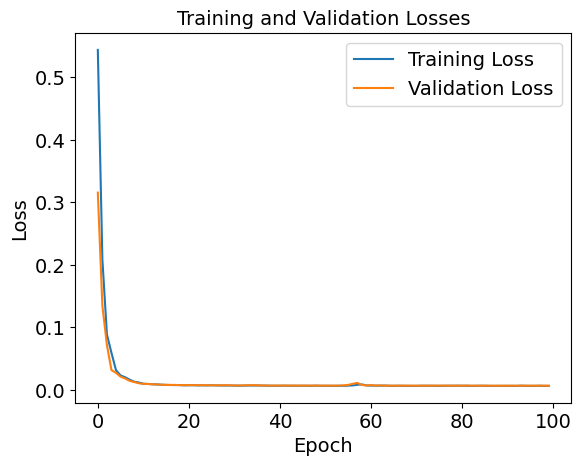

In [32]:
# Define the learning rate and create the model, optimizer, and loss functions
lr = 0.01
model_basic = cVAE(input_dimension=148, latent_dim=16).to(device)
optimizer = torch.optim.Adam(model_basic.parameters(), lr=lr)
criterion = nn.MSELoss()

train_loss_list = []  # List to store train losses
val_loss_list = []    # List to store validation losses

num_epochs = 100
for epoch in range(num_epochs):
    train_loss_autism, train_loss_no_autism = train_no_classifier(model_basic, train_dataloader, train_dataset, device, optimizer, criterion)

    # Validate the model
    val_loss_autism, val_loss_no_autism = validate_no_classifier(model_basic, val_dataloader, val_dataset, device, criterion)

    # Appending the loss values to a list to allow for visualizations:
    train_loss_list.append(train_loss_autism + train_loss_no_autism)
    val_loss_list.append(val_loss_autism + val_loss_no_autism)

    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Train Loss Autism: {train_loss_autism:.4f}, Train Loss Non-Autism: {train_loss_no_autism:.4f}")
    print(f"Val Loss Autism: {val_loss_autism:.4f}, Val Loss Non-Autism: {val_loss_no_autism:.4f}")

print("TRAINING COMPLETE")

# Plot the training and validation losses
plt.figure()
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

Here, I am saving this model

In [ ]:
torch.save(model_basic.state_dict(), 'model_basic.pth')


And here it is loaded.

In [ ]:
model_basic = cVAE(input_dimension = 148, latent_dim= 16).to(device)
model_basic.load_state_dict(torch.load('model_basic.pth'))

## Definition of Functions for Analyses


Before I will actually get to analyze the data, I want to define all the analyses steps and data wrangling I will use more often as functions. This will later end up with easier and faster analyses steps!

Here are all the functions that will be necessary to perform an RSA.

Starting with the DSM:

In [34]:
# Importing all the modules now that will later be used.
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import kendalltau
from scipy.spatial.distance import pdist, squareform
from itertools import combinations

# Define a function to calculate dissimilarity matrix
def calculate_dissimilarity_matrix(latent_vectors, metric='euclidean'):
    # Flatten the list of 3D arrays to a 2D array
    latent_vectors_flat = np.vstack(latent_vectors)

    # Calculate pairwise distances
    pairwise_distances = pdist(latent_vectors_flat, metric=metric)

    # Convert condensed distance matrix to square dissimilarity matrix
    dissimilarity_matrix = squareform(pairwise_distances)

    return dissimilarity_matrix

# Define a function to calculate the representational dissimilarity matrix (RDM)
def make_RDM(vec, data_scale='ratio', metric='euclidean'):
    vec = np.array(vec)
    min_val = min(vec.flatten())
    max_val = max(vec.flatten())

    # Avoid division by zero by adding a small constant
    vec = (vec - min_val) / (max_val - min_val)

    if np.ndim(vec) == 1:  # must be at least 2D
        vec = np.vstack((vec, np.zeros(vec.shape))).transpose()

    mat = squareform(pdist(vec, metric=metric).transpose())
    if data_scale == 'ordinal':
        mat[mat != 0] = 1  # Make into zeros and ones

    return mat

Next, here is the computation of the RSA.

In [35]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import kendalltau

def compute_rsa(latent_vectors, variable_data):
    """
    Compute RSA (Representational Similarity Analysis) similarity between latent vectors and a variable.

    Args:
    - latent_vectors: List or array of latent vectors.
    - variable_data: List or array of data for the variable.

    Returns:
    - RSA similarity score.
    """
    # Compute the Pearson correlation between latent vectors and the current variable
    correlation_matrix = np.corrcoef(latent_vectors, variable_data)

    # Extract the upper triangular part of the correlation matrix (excluding diagonal)
    upper_triangular = squareform(correlation_matrix, checks=False)

    # Calculate RSA similarity score (mean of the upper triangular values)
    rsa_similarity = np.mean(upper_triangular)

    return rsa_similarity

def rsa_dict_without_missing_values(data_dict):
    """
    Compute RSA (Representational Similarity Analysis) for each latent vector-variable pairing in a data dictionary
    while handling missing values.latent_salient_with_classifier_autism['age'].append(autism_age.detach().cpu().numpy())
latent_salient_with_classifier_autism['gender'].append(autism_gender.detach().cpu().numpy())


    Args:
    - data_dict: Dictionary where keys are variable names and values are lists or arrays of data.
                 The first key is assumed to represent latent vectors, and the second key is participant IDs.

    Returns:
    - Dictionary of RSA similarity scores for each variable pairing, or None if any pairing has missing values.
    """
    rsa_results = {}  # Dictionary to store RSA results

    variable_scales = {
    'ADOS_TOTAL': 'ratio',
    'ADOS_SOCIAL': 'ratio',
    'DSM_IV_TR': 'ordinal',
    'AGE_AT_SCAN': 'ratio',
    'SEX': 'ordinal',
    'FIQ': 'ordinal',
    'Age': 'ratio',
    'Gender': 'ordinal'}

    # Get latent vectors and participant IDs
    latent_vectors = data_dict[list(data_dict.keys())[0]]
    participant_ids = data_dict['participant_ids']

    # Iterate through variables
    for variable_name, variable_data in data_dict.items():
        if variable_name != 'salient_vector' and variable_name != 'participant_ids' and variable_name != 'background_vector':
            rsa_values = []  # List to store RSA values for each sample
            for i in range(len(latent_vectors)):
                latent_vector = latent_vectors[i]
                covariate = variable_data[i]

                # Find indices of NAs
                missings = find_non_numeric_indices(covariate)

                # Exclude missing values
                latent_vector_no_missing = [item for j, item in enumerate(latent_vector) if j not in missings]
                covariate_no_missing = [item for j, item in enumerate(covariate) if j not in missings]

                # Create matrices
                dissimilarity_latent_no_missing = calculate_dissimilarity_matrix([latent_vector_no_missing])

                rdm_covariate = make_RDM(covariate_no_missing, data_scale=variable_scales[variable_name])

                # Compute RSA similarity score
                rsa_similarity = compute_rsa(dissimilarity_latent_no_missing, rdm_covariate)
                rsa_values.append(rsa_similarity)

            # Append the RSA values to the results dictionary
            rsa_results[variable_name] = rsa_values

    return rsa_results


Here are several utility functions, as well as two functions for plotting.



In [36]:
def print_dissimilarity_matrix(matrix):
    """
    Print a dissimilarity matrix.

    Parameters:
    matrix (numpy.ndarray): The dissimilarity matrix to print.
    """
    for row in matrix:
        # Print each row of the matrix as space-separated values
        row_str = " ".join([f"{val:.7f}" for val in row])
        print(row_str)

# Here a utility function I need soon.
def flatten_dict_lists(input_dict):
    flattened_dict = {}
    for key, value in input_dict.items():
        if isinstance(value, list):
            flattened_list = [item for sublist in value for item in sublist]
            flattened_dict[key] = flattened_list
        else:
            flattened_dict[key] = value
    return flattened_dict

def find_non_numeric_indices(input_list):
    non_numeric_indices = [i for i, item in enumerate(input_list) if str(item) == "nan"]
    return non_numeric_indices


def create_rsa_bar_plots(dictionary_list1, dictionary_list2):
    # Get the list of variables to compare
    variables_to_compare = list(dictionary_list1.keys())

    # Determine the number of subplots based on the number of variables
    num_variables = len(variables_to_compare)

    if num_variables == 1:
        # Only one variable, no need for subplots
        key = variables_to_compare[0]
        rsa_values_list1 = dictionary_list1[key]
        rsa_values_list2 = dictionary_list2[key]

        # Calculate the mean of RSA values
        mean_rsa1 = np.mean(rsa_values_list1)
        mean_rsa2 = np.mean(rsa_values_list2)

        # Perform a t-test
        t_stat, p_value = stats.ttest_rel(rsa_values_list1, rsa_values_list2)

        # Create a figure for the plot
        plt.figure(figsize=(8, 6))

        # Create the bar plot for the first list (With Classifier)
        plt.bar(0.25, mean_rsa1, width=0.4, label='With Classifier', color='blue', yerr=np.std(rsa_values_list1), capsize=5, alpha=0.7)

        # Create the bar plot for the second list (Without Classifier)
        plt.bar(0.75, mean_rsa2, width=0.4, label='Without Classifier', color='red', yerr=np.std(rsa_values_list2), capsize=5, alpha=0.7)

        # Display individual data points
        plt.scatter(np.full(len(rsa_values_list1), 0.25), rsa_values_list1, color='black', marker='o', s=10, label='Individual Data', alpha=0.7)
        plt.scatter(np.full(len(rsa_values_list2), 0.75), rsa_values_list2, color='black', marker='o', s=10, alpha=0.7)

        # Set title, labels, and x-axis label
        plt.title(f'RSA Comparison - {key}\nT-Test: p-value = {p_value:.4f}', fontsize=12)
        plt.ylabel('RSA Similarity Score')
        plt.xticks([0.25, 0.75], ['With Classifier', 'Without Classifier'])

        # Show the plot
        plt.tight_layout()
        plt.show()
    else:
        # Create subplots for multiple variables
        num_rows = int(np.ceil(num_variables / 2))  # Assuming 2 columns per row
        num_cols = 2  # 2 columns per row

        # Create the subplot grid
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

        # Flatten the axs array if needed
        if num_rows == 1:
            axs = axs.reshape(1, -1)

        # Loop through variables and create subplots
        for idx, variable_name in enumerate(variables_to_compare):
            row_idx = idx // num_cols
            col_idx = idx % num_cols
            ax = axs[row_idx, col_idx]

            # Get RSA values for the current variable from both dictionaries
            rsa_values_list1 = dictionary_list1[variable_name]
            rsa_values_list2 = dictionary_list2[variable_name]

            # Calculate the mean of RSA values
            mean_rsa1 = np.mean(rsa_values_list1)
            mean_rsa2 = np.mean(rsa_values_list2)

            # Perform a t-test and display p-value
            t_stat, p_value = stats.ttest_rel(rsa_values_list1, rsa_values_list2)

            # Create bar positions
            x = np.arange(2)

            # Create a bar plot for the current variable
            ax.bar(0.25, mean_rsa1, width=0.4, label='With Classifier', color='blue', yerr=np.std(rsa_values_list1), capsize=5, alpha=0.7)
            ax.bar(0.75, mean_rsa2, width=0.4, label='Without Classifier', color='red', yerr=np.std(rsa_values_list2), capsize=5, alpha=0.7)

            # Display individual data points
            ax.scatter(np.full(len(rsa_values_list1), 0.25), rsa_values_list1, color='black', marker='o', s=10, label='Individual Data', alpha=0.7)
            ax.scatter(np.full(len(rsa_values_list2), 0.75), rsa_values_list2, color='black', marker='o', s=10, alpha=0.7)

            # Set title, labels, and x-axis label
            ax.set_title(f'RSA Comparison - {variable_name}\nT-Test: p-value = {p_value:.4f}', fontsize=12)
            ax.set_ylabel('RSA Similarity Score')
            ax.set_xticks([0.25, 0.75])
            ax.set_xticklabels(['With Classifier', 'Without Classifier'])

        # Adjust spacing between subplots
        plt.tight_layout()

        # Show the plot
        plt.show()

In [37]:
from itertools import combinations

def create_rsa_bar_plots_flexible(*dictionaries):
    num_dictionaries = len(dictionaries)

    # Get the variables that are common to all dictionaries or only in the first four dictionaries
    common_variables = set(dictionaries[0].keys())
    for dictionary in dictionaries[1:4]:
        common_variables &= set(dictionary.keys())

    # Create subplots for each common variable
    num_variables = len(common_variables)

    for variable_name in common_variables:
        plt.figure(figsize=(10, 6))  # Adjust the figure size

        # Get RSA values for the current variable from dictionaries that contain it
        rsa_values = [dictionary[variable_name] for dictionary in dictionaries if variable_name in dictionary]

        # Calculate the means of RSA values
        means = [np.mean(rsa) for rsa in rsa_values]

        # Perform pairwise t-tests
        pairwise_p_values = []
        for i, j in combinations(range(len(rsa_values)), 2):
            t_stat, p_value = stats.ttest_rel(rsa_values[i], rsa_values[j])
            pairwise_p_values.append(p_value)

        # Calculate positions for bars and significance annotations
        num_bars = len(rsa_values)
        x_positions = np.arange(num_bars)
        bar_width = 0.3
        bar_spacing = 0.1  # Reduced the bar spacing
        total_bar_space = num_bars * (bar_width + bar_spacing)
        x_positions = np.linspace(0, total_bar_space, num_bars)

        # Create bar plots for the current variable
        bars = plt.bar(x_positions, means, width=bar_width, color=['blue', 'red', 'green', 'purple'][:num_bars])

        # Display individual data points for each dictionary
        for i, rsa in enumerate(rsa_values):
            x_i = x_positions[i]  # Adjusted x position
            plt.scatter(np.full(len(rsa), x_i), rsa, color='black', marker='o', s=20, label='Individual Data', alpha=0.7)

        # Set title, labels, and x-axis label with adjusted font size
        plt.title(f'RSA Comparison - {variable_name}', fontsize=16)  # Increased title font size
        plt.ylabel('RSA Similarity Score', fontsize=14)  # Increased y-label font size

        # Dynamically generate x-axis labels based on the number of bars
        if num_bars == 4:
            x_labels = ['Salient \n With \n Classifier', 'Salient \n Without \n Classifier', 'Background \n With \n Classifier', 'Background \n Without \n Classifier']
        elif num_bars == 6:
            x_labels = ['Salient \n With \n Classifier', 'Salient \n Without \n Classifier', 'Background \n With \n Classifier', 'Background \n Without \n Classifier', 'No ASD \n With \n Classifier', 'No ASD \n Without \n Classifier']

        # Set x-axis labels with line breaks and increased font size
        plt.xticks(x_positions, x_labels, fontsize=12, rotation=0, ha='center')

        # Add significance brackets
        for i, j in combinations(range(len(rsa_values)), 2):
            if pairwise_p_values[i] < 0.05:
                significance = '*'
                bar_height_i = max(means[i], means[j]) + 0.05
                bar_height_j = max(means[i], means[j]) + 0.05
                x_i = x_positions[i]
                x_j = x_positions[j]
                plt.annotate(significance, xy=(x_i, bar_height_i), fontsize=14, ha='center', va='bottom')  # Increased annotation font size
                plt.annotate(significance, xy=(x_j, bar_height_j), fontsize=14, ha='center', va='bottom')  # Increased annotation font size

        # Print pairwise t-test results
        print(f'Pairwise t-test between Datasets 1 and 2 for variable {variable_name}: p-value = {pairwise_p_values[0]:.4f}')
        print(f'Pairwise t-test between Datasets 3 and 4 for variable {variable_name}: p-value = {pairwise_p_values[1]:.4f}')
        if num_bars == 6:
            print(f'Pairwise t-test between Datasets 5 and 6 for variable {variable_name}: p-value = {pairwise_p_values[2]:.4f}')

        # Show the plot for the current variable
        plt.tight_layout()
        plt.show()

# Example usage:
# create_rsa_bar_plots_flexible(dictionary_list1, dictionary_list2, dictionary_list3, dictionary_list4)


## Representational Similariy Analyses

### No-Classifier RSA

### RSA with Classifier

In this section, we will compare the results of the RSA with and without the classifier.

In [43]:
# Dictionaries to store latent representations
latent_salient_with_classifier_autism = {'salient_vector': [], 'participant_ids': [], 'ADOS_TOTAL': [], 'ADOS_SOCIAL': [], 'DSM_IV_TR': [], 'FIQ': [], 'Age': [], 'Gender': []}

latent_with_classifier_autism = {'background_vector': [], 'participant_ids': [], 'ADOS_TOTAL': [], 'ADOS_SOCIAL': [], 'DSM_IV_TR': [], 'FIQ': [], 'Age': [], 'Gender': []}

latent_with_classifier_no_autism = {'background_vector': [], 'participant_ids': [], 'FIQ': [], 'Age': [], 'Gender': []}

latent_salient_without_classifier_autism = {'salient_vector': [], 'participant_ids': [], 'ADOS_TOTAL': [], 'ADOS_SOCIAL': [], 'DSM_IV_TR': [], 'FIQ': [], 'Age': [], 'Gender': []}

latent_without_classifier_autism = {'background_vector': [], 'participant_ids': [], 'ADOS_TOTAL': [], 'ADOS_SOCIAL': [], 'DSM_IV_TR': [], 'FIQ': [], 'Age': [], 'Gender': []}

latent_without_classifier_no_autism = {'background_vector': [], 'participant_ids': [], 'FIQ': [], 'Age': [], 'Gender': []}

# Set models to evaluation mode
model_classifier.eval()
model_basic.eval()

# Create an iterator for the data loader
no_batch_train_iterator = iter(train_dataloader_no_batch)
# Get a single batch (sample)
sample_batch = next(no_batch_train_iterator)

i = 1
# Iterate through the DataLoader
for i in range(1, 10):
    (autism_data, autism_age, autism_FIQ, autism_diag_group, autism_ADOS_TOTAL, autism_gender, autism_ADOS_SOCIAL, autism_DSM_IV_TR, autism_sub_id), (no_autism_data, no_autism_age, no_autism_FIQ, _,  no_autism_gender, no_autism_sub_id) = batch

    # Move data to device if necessary
    autism_data = autism_data.to(device)
    no_autism_data = no_autism_data.to(device)

    # Generate latent representations using model with classifier
    (_, _, _, _, _, _, _, _, _, _, z_classifier, s_classifier, z_no_autism_classifier) = model_classifier(autism_data, no_autism_data)

    # Generate latent representations using model without classifier
    (_, _, _, _, _, _, _, _, z, s, z_no_autism) = model_basic(autism_data, no_autism_data)

    # Append latent vectors to dictionaries along with participant IDs and covariates for autism data with classifier
    latent_salient_with_classifier_autism['salient_vector'].append(s_classifier.detach().cpu().numpy())
    latent_salient_with_classifier_autism['participant_ids'].append(autism_sub_id)
    latent_salient_with_classifier_autism['ADOS_TOTAL'].append(autism_ADOS_TOTAL.detach().cpu().numpy())
    latent_salient_with_classifier_autism['ADOS_SOCIAL'].append(autism_ADOS_SOCIAL.detach().cpu().numpy())
    latent_salient_with_classifier_autism['DSM_IV_TR'].append(autism_DSM_IV_TR.detach().cpu().numpy())
    latent_salient_with_classifier_autism['FIQ'].append(autism_FIQ.detach().cpu().numpy())
    latent_salient_with_classifier_autism['Age'].append(autism_age.detach().cpu().numpy())
    latent_salient_with_classifier_autism['Gender'].append(autism_gender.detach().cpu().numpy())

    latent_with_classifier_autism['background_vector'].append(z_classifier.detach().cpu().numpy())
    latent_with_classifier_autism['participant_ids'].append(autism_sub_id)
    latent_with_classifier_autism['ADOS_TOTAL'].append(autism_ADOS_TOTAL.detach().cpu().numpy())
    latent_with_classifier_autism['ADOS_SOCIAL'].append(autism_ADOS_SOCIAL.detach().cpu().numpy())
    latent_with_classifier_autism['DSM_IV_TR'].append(autism_DSM_IV_TR.detach().cpu().numpy())
    latent_with_classifier_autism['FIQ'].append(autism_FIQ.detach().cpu().numpy())
    latent_with_classifier_autism['Age'].append(autism_age.detach().cpu().numpy())
    latent_with_classifier_autism['Gender'].append(autism_gender.detach().cpu().numpy())

    # Append latent vectors to dictionaries along with participant IDs and covariates for autism data without classifier
    latent_salient_without_classifier_autism['salient_vector'].append(s.detach().cpu().numpy())
    latent_salient_without_classifier_autism['participant_ids'].append(autism_sub_id)
    latent_salient_without_classifier_autism['ADOS_TOTAL'].append(autism_ADOS_TOTAL.detach().cpu().numpy())
    latent_salient_without_classifier_autism['ADOS_SOCIAL'].append(autism_ADOS_SOCIAL.detach().cpu().numpy())
    latent_salient_without_classifier_autism['DSM_IV_TR'].append(autism_DSM_IV_TR.detach().cpu().numpy())
    latent_salient_without_classifier_autism['FIQ'].append(autism_FIQ.detach().cpu().numpy())
    latent_salient_without_classifier_autism['Age'].append(autism_age.detach().cpu().numpy())
    latent_salient_without_classifier_autism['Gender'].append(autism_gender.detach().cpu().numpy())

    latent_without_classifier_autism['background_vector'].append(z.detach().cpu().numpy())
    latent_without_classifier_autism['participant_ids'].append(autism_sub_id)
    latent_without_classifier_autism['ADOS_TOTAL'].append(autism_ADOS_TOTAL.detach().cpu().numpy())
    latent_without_classifier_autism['ADOS_SOCIAL'].append(autism_ADOS_SOCIAL.detach().cpu().numpy())
    latent_without_classifier_autism['DSM_IV_TR'].append(autism_DSM_IV_TR.detach().cpu().numpy())
    latent_without_classifier_autism['FIQ'].append(autism_FIQ.detach().cpu().numpy())
    latent_without_classifier_autism['Age'].append(autism_age.detach().cpu().numpy())
    latent_without_classifier_autism['Gender'].append(autism_gender.detach().cpu().numpy())

    # Append latent vectors to dictionaries along with participant IDs and covariates for no-autism data with classifier
    latent_with_classifier_no_autism['background_vector'].append(z_no_autism_classifier.detach().cpu().numpy())
    latent_with_classifier_no_autism['participant_ids'].append(no_autism_sub_id)
    latent_with_classifier_no_autism['FIQ'].append(no_autism_FIQ.detach().cpu().numpy())
    latent_with_classifier_no_autism['Age'].append(no_autism_age.detach().cpu().numpy())
    latent_with_classifier_no_autism['Gender'].append(no_autism_gender.detach().cpu().numpy())

    # Append latent vectors to dictionaries along with participant IDs and covariates for no-autism data without classifier
    latent_without_classifier_no_autism['background_vector'].append(z_no_autism.detach().cpu().numpy())
    latent_without_classifier_no_autism['participant_ids'].append(no_autism_sub_id)
    latent_without_classifier_no_autism['FIQ'].append(no_autism_FIQ.detach().cpu().numpy())
    latent_without_classifier_no_autism['Age'].append(no_autism_age.detach().cpu().numpy())
    latent_without_classifier_no_autism['Gender'].append(no_autism_gender.detach().cpu().numpy())

    i += 1


In [44]:
# Generate RSA results for each dictionary
rsa_salient_with_classifier_autism = rsa_dict_without_missing_values(latent_salient_with_classifier_autism)
rsa_with_classifier_autism = rsa_dict_without_missing_values(latent_with_classifier_autism)
rsa_with_classifier_no_autism = rsa_dict_without_missing_values(latent_with_classifier_no_autism)
rsa_salient_without_classifier_autism = rsa_dict_without_missing_values(latent_salient_without_classifier_autism)
rsa_without_classifier_autism = rsa_dict_without_missing_values(latent_without_classifier_autism)
rsa_without_classifier_no_autism = rsa_dict_without_missing_values(latent_without_classifier_no_autism)

# Print or store the RSA results
print("RSA results for latent_salient_with_classifier_autism:", rsa_salient_with_classifier_autism)
print("RSA results for latent_with_classifier_autism:", rsa_with_classifier_autism)
print("RSA results for latent_with_classifier_no_autism:", rsa_with_classifier_no_autism)
print("RSA results for latent_salient_without_classifier_autism:", rsa_salient_without_classifier_autism)
print("RSA results for latent_without_classifier_autism:", rsa_without_classifier_autism)
print("RSA results for latent_without_classifier_no_autism:", rsa_without_classifier_no_autism)


RSA results for latent_salient_with_classifier_autism: {'ADOS_TOTAL': [0.0945579919533843, 0.09033119472630029, 0.09187083172654292, 0.11874346678745651, 0.10809589652760647, 0.09557391747818778, 0.10639354983952827, 0.08179687981905993, 0.08539046090630234], 'ADOS_SOCIAL': [0.1474296747072106, 0.12807983579947801, 0.14683806157268559, 0.1415855128111161, 0.16754316522359938, 0.14493743248305432, 0.1228724642032616, 0.12457994165738244, 0.15344864393357355], 'DSM_IV_TR': [0.17339799802793257, 0.1832269290767413, 0.1647543820772728, 0.17778682768224888, 0.18408945139371927, 0.1917160627227148, 0.17702102543614556, 0.14610379829077624, 0.2073563503890139], 'FIQ': [0.04164618925282965, 0.03477755486126345, 0.0452388026047912, 0.06200266343130681, 0.05516515167857636, 0.053924140283579954, 0.04013634691785847, 0.029011512686557456, 0.05218999093790039], 'Age': [0.17209743407466074, 0.14945881282436346, 0.1775045198719951, 0.1841085142873119, 0.13809975653599457, 0.1882105980496028, 0.16198

Pairwise t-test between Datasets 1 and 2 for variable Age: p-value = 0.6365
Pairwise t-test between Datasets 3 and 4 for variable Age: p-value = 0.6308
Pairwise t-test between Datasets 5 and 6 for variable Age: p-value = 0.3227


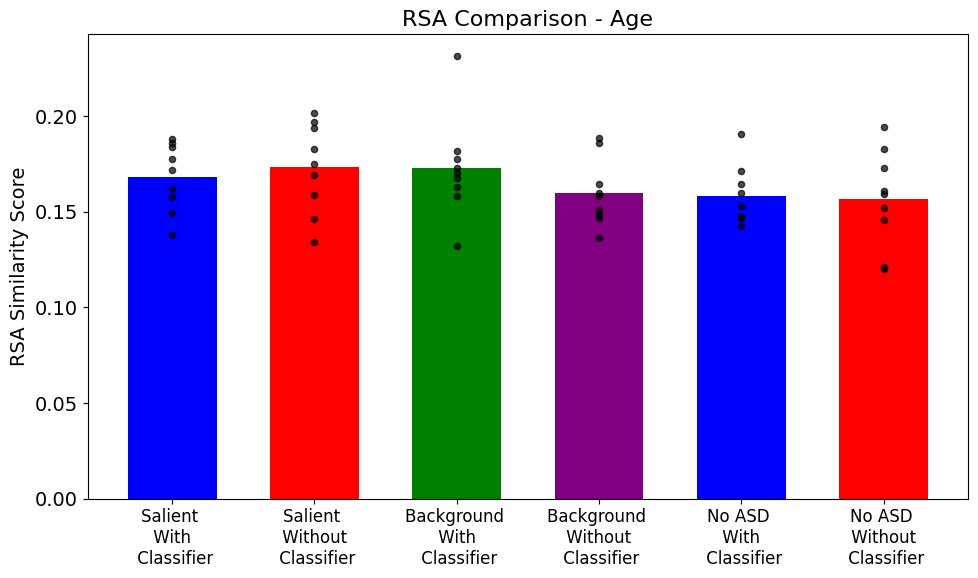

Pairwise t-test between Datasets 1 and 2 for variable ADOS_TOTAL: p-value = 0.4817
Pairwise t-test between Datasets 3 and 4 for variable ADOS_TOTAL: p-value = 0.4211


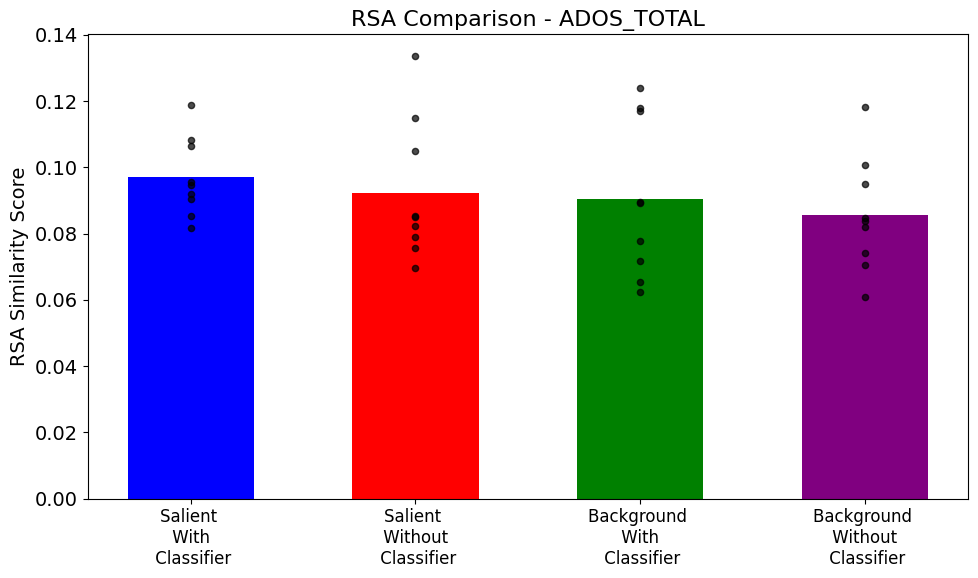

Pairwise t-test between Datasets 1 and 2 for variable ADOS_SOCIAL: p-value = 0.5806
Pairwise t-test between Datasets 3 and 4 for variable ADOS_SOCIAL: p-value = 0.8682


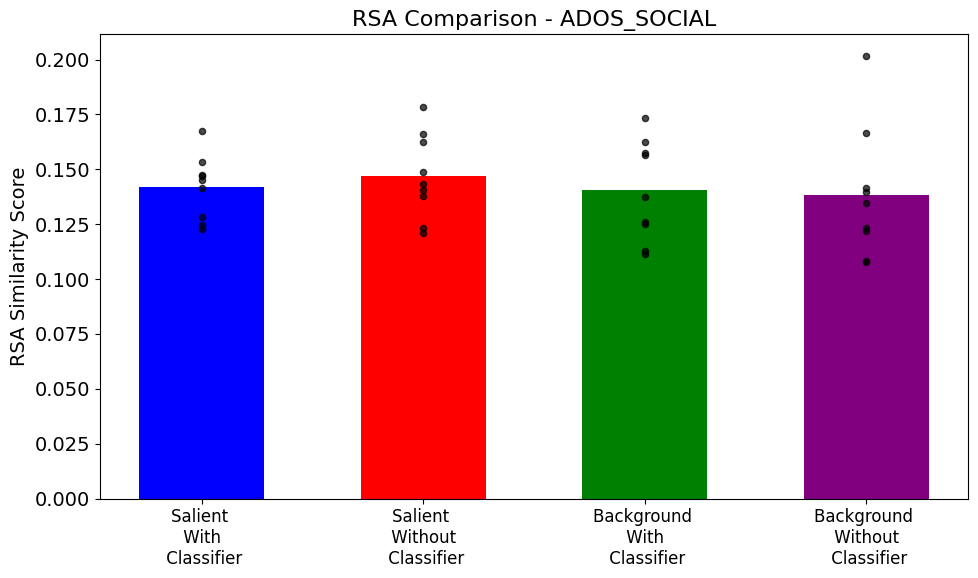

Pairwise t-test between Datasets 1 and 2 for variable DSM_IV_TR: p-value = 0.7874
Pairwise t-test between Datasets 3 and 4 for variable DSM_IV_TR: p-value = 0.8181


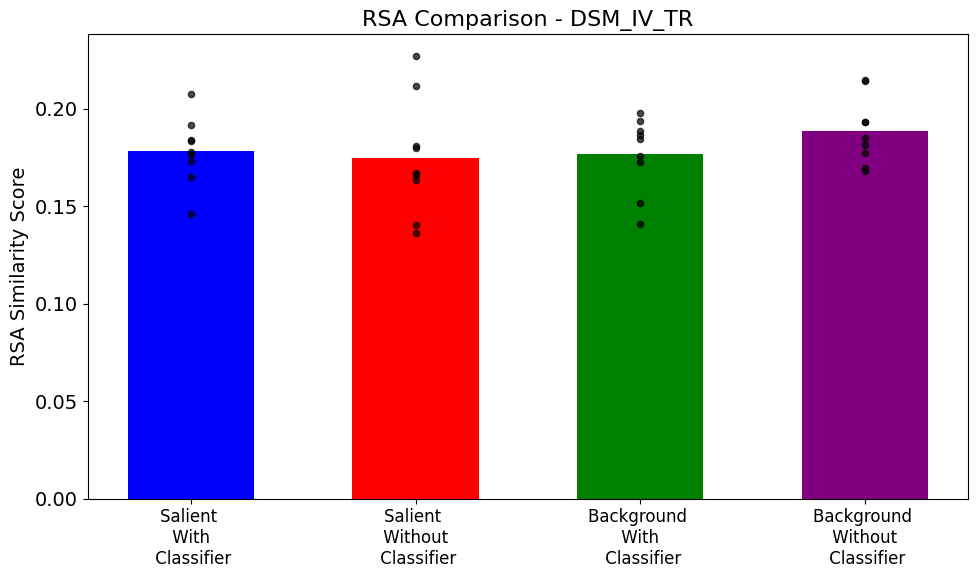

Pairwise t-test between Datasets 1 and 2 for variable Gender: p-value = 0.6765
Pairwise t-test between Datasets 3 and 4 for variable Gender: p-value = 0.1754
Pairwise t-test between Datasets 5 and 6 for variable Gender: p-value = 0.4465


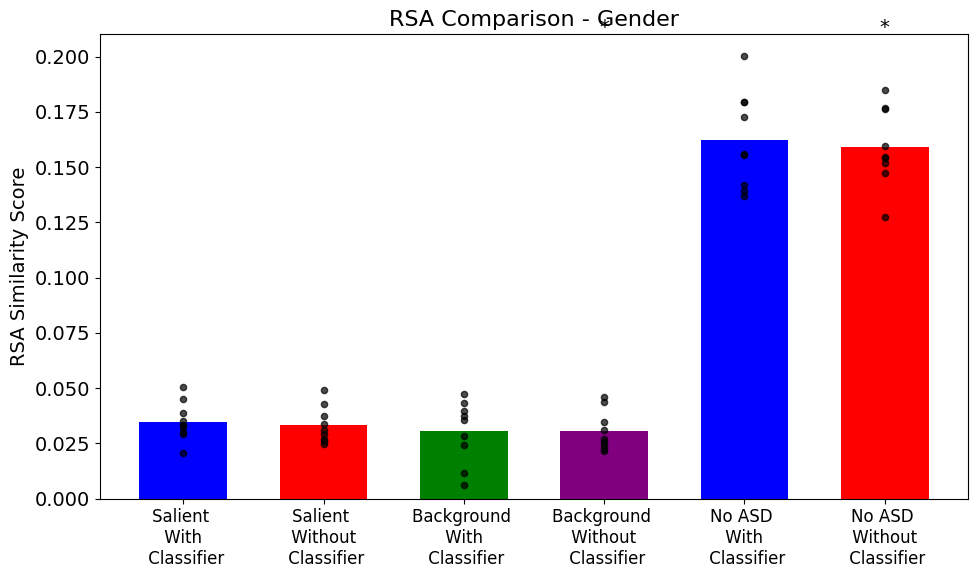

Pairwise t-test between Datasets 1 and 2 for variable FIQ: p-value = 0.4904
Pairwise t-test between Datasets 3 and 4 for variable FIQ: p-value = 0.5264
Pairwise t-test between Datasets 5 and 6 for variable FIQ: p-value = 0.8097


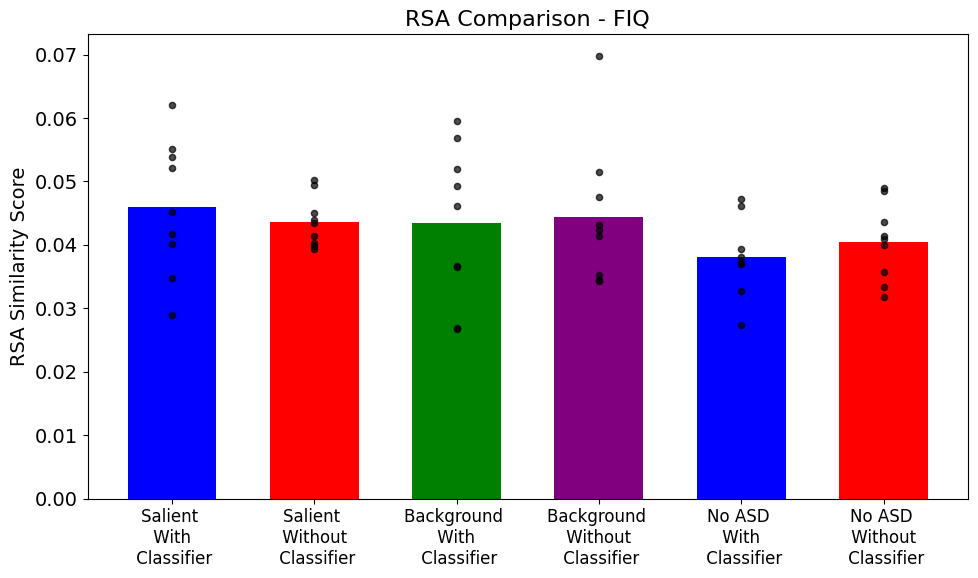

In [45]:
create_rsa_bar_plots_flexible(rsa_salient_with_classifier_autism, rsa_salient_without_classifier_autism, rsa_with_classifier_autism, rsa_without_classifier_autism, rsa_with_classifier_no_autism,rsa_without_classifier_no_autism)

Next, lets compare the results

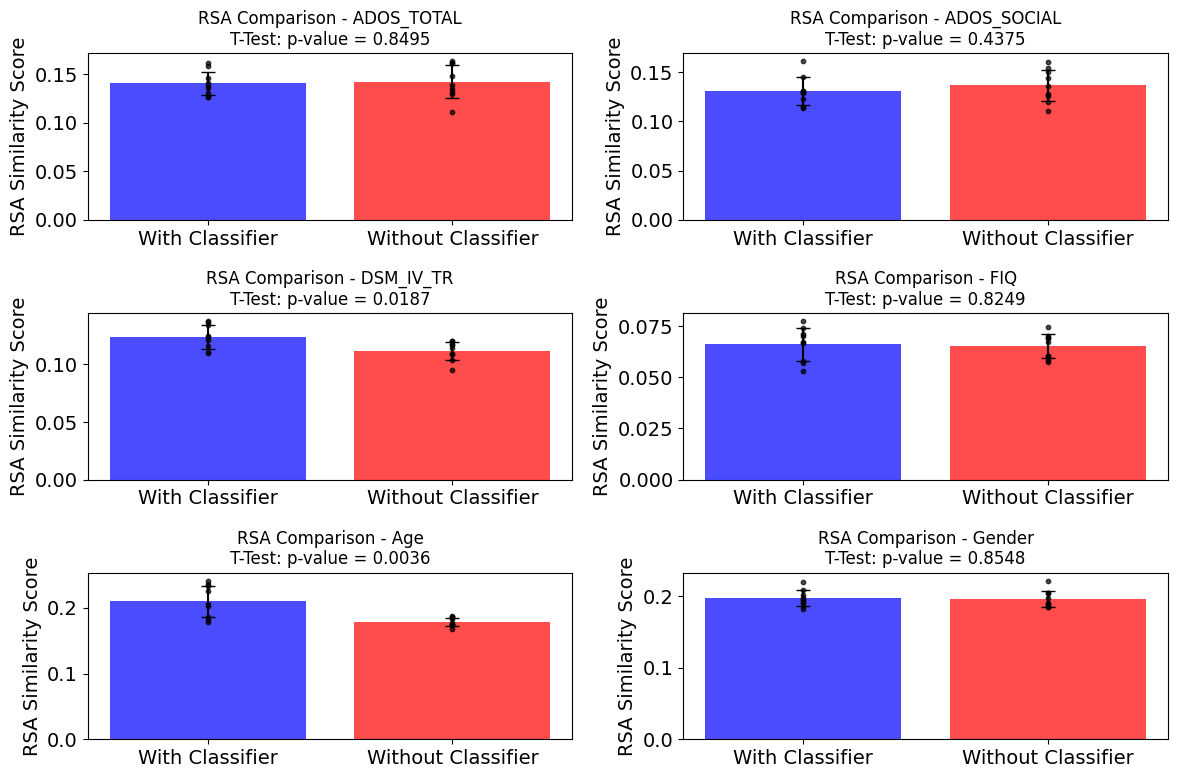

In [ ]:
# Pair 1: RSA Salient with Classifier Autism vs. RSA Salient without Classifier Autism
create_rsa_bar_plots(rsa_salient_with_classifier_autism, rsa_salient_without_classifier_autism)

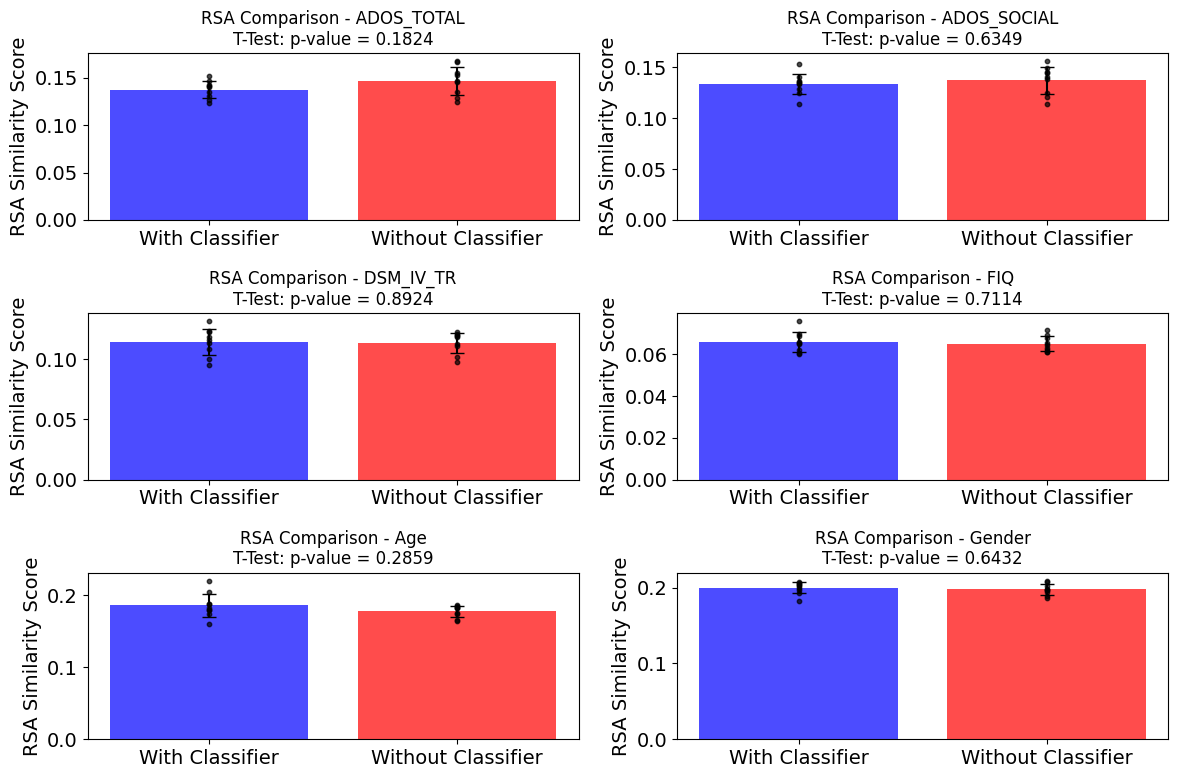

In [ ]:
# Pair 2: RSA With Classifier Autism vs. RSA Without Classifier Autism
create_rsa_bar_plots(rsa_with_classifier_autism, rsa_without_classifier_autism)


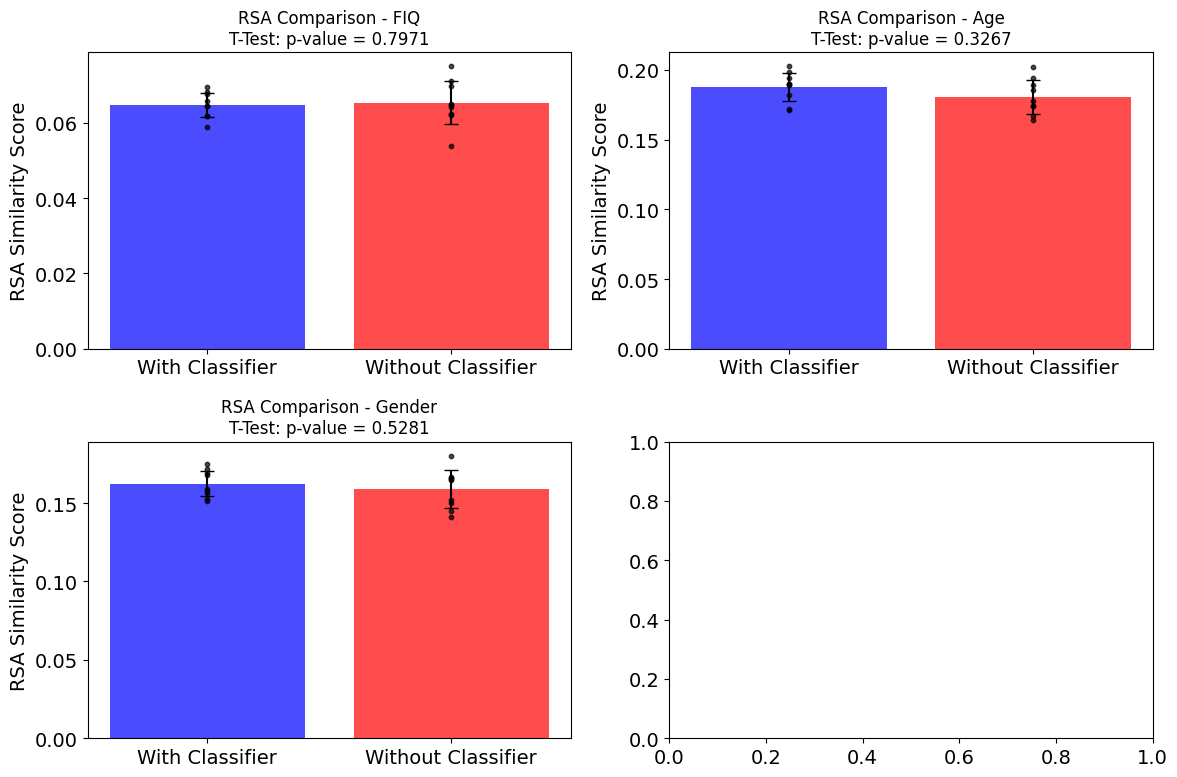

In [ ]:
# Pair 3: RSA With Classifier No Autism vs. RSA Without Classifier No Autism
create_rsa_bar_plots(rsa_with_classifier_no_autism, rsa_without_classifier_no_autism)

### t-SNE Analyses

Next, I want to look at the latent representaitons and if we see any clustering according to gender, or if the classifier leads to a change in the latent space in relation to age.

**ASD latent vectors**

<ipython-input-98-6aa2d80da9b4>:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(tsne_result_1[:, 0], tsne_result_1[:, 1], c=combined_labels, cmap=plt.cm.get_cmap("cool", 2))


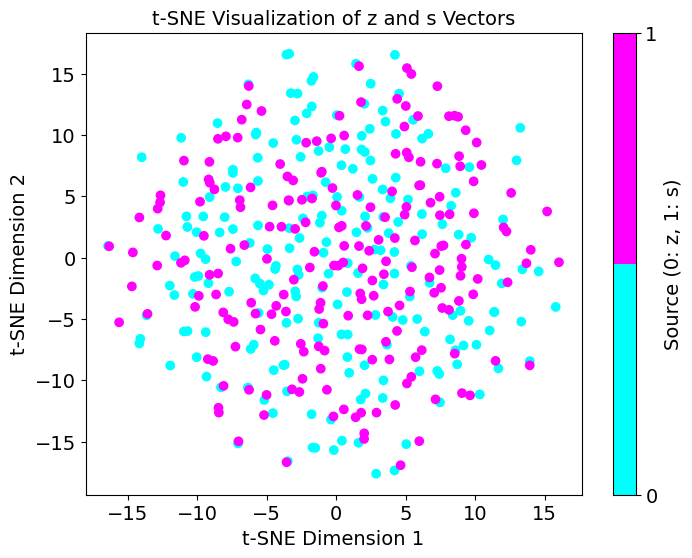

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch


def get_batch_age_and_gender(model, dataloader, device):
    model.eval()
    # Create an iterator for the data loader
    batch_iterator = iter(dataloader)

    # Get a single batch (sample)
    sample_batch = next(batch_iterator)

    (autism_data, autism_age, autism_gender, autism_diag_group, autism_ADOS_TOTAL, autism_ADOS_SOCIAL, autism_DSM_IV_TR, autism_FIQ, autism_sub_id), (no_autism_data, no_autism_age, no_autism_gender, _, no_autism_FIQ, no_autism_sub_id) = sample_batch

    autism_data = autism_data.to(device)

    _, _, _, _, _, _, _, _, _, _, _, _, z, s, z_no_autism = model(autism_data, no_autism_data)

    z_list = []  # List to store z vectors
    s_list = []  # List to store s vectors
    z_labels = []  # Labels for z vectors
    s_labels = []  # Labels for s vectors

    # Loop through the batch dimension
    for i in range(autism_data.shape[0]):
        z_list.append(z[i])
        s_list.append(s[i])

        # Use labels to differentiate between z and s vectors
        z_labels.append("z")
        s_labels.append("s")

    # Convert lists to tensors
    z_tensors = torch.stack(z_list)
    s_tensors = torch.stack(s_list)

    # Create dictionaries with z, s, age, gender, and ADOS scores
    z_dict = {
        "latent_vec": z_tensors,
        "age": autism_age,
        "gender": autism_gender,
        "ADOS_TOTAL": autism_ADOS_TOTAL,
        "ADOS_SOCIAL": autism_ADOS_SOCIAL,
        "label": z_labels
    }

    s_dict = {
        "latent_vec": s_tensors,
        "age": autism_age,
        "gender": autism_gender,
        "ADOS_TOTAL": autism_ADOS_TOTAL,
        "ADOS_SOCIAL": autism_ADOS_SOCIAL,
        "label": s_labels
    }

    return z_dict, s_dict

z_dict, s_dict = get_batch_age_and_gender(model_classifier, train_dataloader_no_batch, device)

# Assuming you have two dictionaries: z_dict and s_dict
z_vectors = z_dict["latent_vec"].detach().cpu().numpy()
s_vectors = s_dict["latent_vec"].detach().cpu().numpy()

# Create labels to indicate the source (0 for z, 1 for s)
z_labels = np.zeros(len(z_vectors))
s_labels = np.ones(len(s_vectors))

# Combine the vectors and labels into a single dataset
combined_vectors = np.vstack((z_vectors, s_vectors))
combined_labels = np.hstack((z_labels, s_labels))

# Perform t-SNE on the combined dataset
tsne_1 = TSNE(n_components=2, random_state=42)
tsne_result_1 = tsne_1.fit_transform(combined_vectors)

# Create a scatter plot with color-coded points
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result_1[:, 0], tsne_result_1[:, 1], c=combined_labels, cmap=plt.cm.get_cmap("cool", 2))
plt.colorbar(ticks=[0, 1], label="Source (0: z, 1: s)")
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of z and s Vectors')
plt.show()


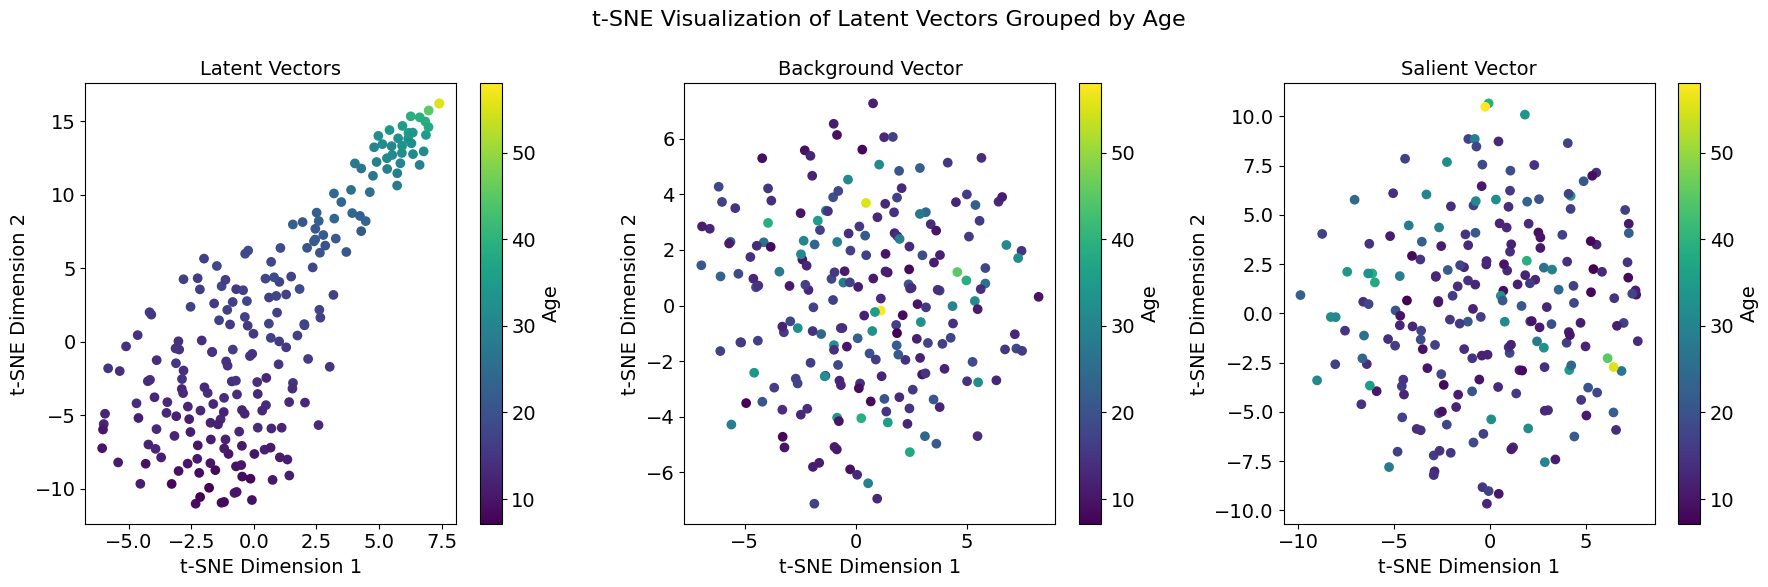

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Common title
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by Age', fontsize=16)

# First subplot: Latent Vectors (z and s combined)
z_vectors = z_dict["latent_vec"].detach().cpu().numpy()
s_vectors = s_dict["latent_vec"].detach().cpu().numpy()
combined_vectors = np.hstack((z_vectors, s_vectors, z_dict["age"].unsqueeze(1).detach().cpu().numpy()))
tsne_2 = TSNE(n_components=2, random_state=42)
tsne_result_2_combined = tsne_2.fit_transform(combined_vectors)
scatter = axs[0].scatter(tsne_result_2_combined[:, 0],tsne_result_2_combined[:, 1], c=z_dict["age"], cmap="viridis")
axs[0].set_title('Latent Vectors')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter, ax=axs[0], label="Age")

# Second subplot: Background Vectors (z vectors)
z_vectors = z_dict["latent_vec"].detach().cpu().numpy()
tsne_result_2_z = tsne_2.fit_transform(z_vectors)
scatter_z = axs[1].scatter(tsne_result_2_z[:, 0], tsne_result_2_z[:, 1], c=z_dict["age"], cmap="viridis")
axs[1].set_title('Background Vector')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z, ax=axs[1], label="Age")

# Third subplot: Salient Vectors (s vectors)
s_vectors = s_dict["latent_vec"].detach().cpu().numpy()
tsne_result_2_s = tsne_2.fit_transform(s_vectors)
scatter_s = axs[2].scatter(tsne_result_2_s[:, 0], tsne_result_2_s[:, 1], c=z_dict["age"], cmap="viridis")
axs[2].set_title('Salient Vector')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s, ax=axs[2], label="Age")

plt.tight_layout()
plt.show()


<ipython-input-102-0c5b5c42b379>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("cool", 2);


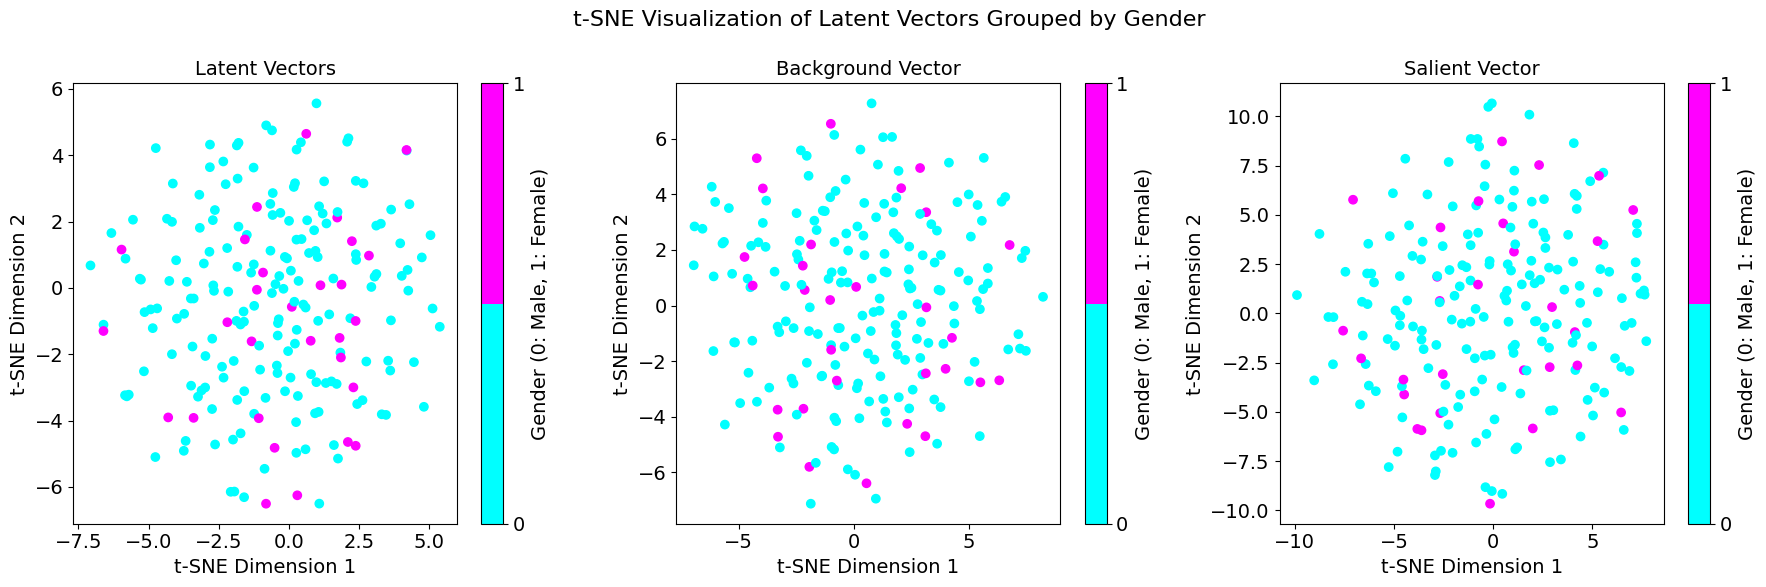

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Common title
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by Gender', fontsize=16)

# First subplot: Latent Vectors (z and s combined)
z_vectors = z_dict["latent_vec"].detach().cpu().numpy()
s_vectors = s_dict["latent_vec"].detach().cpu().numpy()
combined_vectors = np.hstack((z_vectors, s_vectors))
tsne = TSNE(n_components=2, random_state=42)
tsne_result_3_combined = tsne.fit_transform(combined_vectors)
cmap = plt.cm.get_cmap("cool", 2);
scatter = axs[0].scatter(tsne_result_3_combined[:, 0],tsne_result_3_combined[:, 1], c=z_dict["gender"], cmap=cmap)
axs[0].set_title('Latent Vectors')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter, ax=axs[0], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)

# Second subplot: Background Vectors (z vectors)
z_vectors = z_dict["latent_vec"].detach().cpu().numpy()
tsne_result_3_z = tsne.fit_transform(z_vectors)
scatter_z = axs[1].scatter(tsne_result_3_z[:, 0], tsne_result_3_z[:, 1], c=z_dict["gender"], cmap=cmap)
axs[1].set_title('Background Vector')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z, ax=axs[1], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)

# Third subplot: Salient Vectors (s vectors)
s_vectors = s_dict["latent_vec"].detach().cpu().numpy()
tsne_result_3_s = tsne.fit_transform(s_vectors)
scatter_s = axs[2].scatter(tsne_result_3_s[:, 0], tsne_result_3_s[:, 1], c=z_dict["gender"], cmap=cmap)
axs[2].set_title('Salient Vector')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s, ax=axs[2], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)

plt.tight_layout()
plt.show()


Now, let's just look at the background vector. For this we take the vector from the shared encoder and see if it differs in the correlation pattern.

<ipython-input-103-8ed845cb48b1>:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(tsne_results_background_combined_1[:, 0], tsne_results_background_combined_1[:, 1], c=combined_background_labels, cmap=plt.cm.get_cmap("cool", 2))


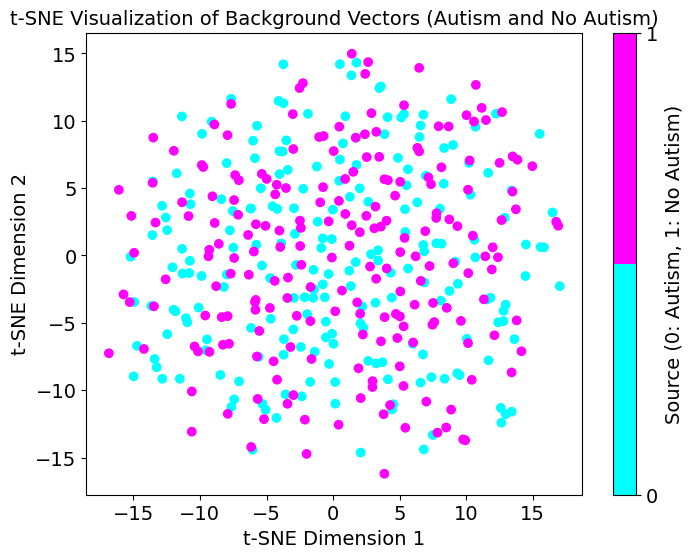

In [ ]:
def get_background_batch(model, dataloader, device):
    model.eval()
    # Create an iterator for the data loader
    batch_iterator = iter(dataloader)

    # Get a single batch (sample)
    sample_batch = next(batch_iterator)

    (autism_data, autism_age, autism_gender, autism_diag_group, autism_ADOS_TOTAL, autism_ADOS_SOCIAL, autism_DSM_IV_TR, autism_FIQ, autism_sub_id), (no_autism_data, no_autism_age, no_autism_gender, _, no_autism_FIQ, no_autism_sub_id) = sample_batch

    autism_data = autism_data.to(device)

    _, _, _, _, _, _, _, _, _, _, _, _, z, s, z_no_autism = model(autism_data, no_autism_data)

    z_list = []  # List to store z vectors
    z_no_ASD_list = []  # List to store z_no_autism vectors
    z_labels = []  # Labels for z vectors
    z_no_ASD_labels = []  # Labels for z_no_autism vectors

    # Loop through the batch dimension
    for i in range(autism_data.shape[0]):
        z_list.append(z[i])
        z_no_ASD_list.append(z_no_autism[i])

        # Use labels to differentiate between z and z_no_ASD vectors
        z_labels.append("z")
        z_no_ASD_labels.append("z_no_ASD")

    # Convert lists to tensors
    z_tensors = torch.stack(z_list)
    z_no_ASD_tensors = torch.stack(z_no_ASD_list)

    # Create dictionaries with z, z_no_ASD, age, and gender
    z_dict = {"latent_vec": z_tensors, "age": autism_age, "gender": autism_gender, "label": z_labels}
    z_no_autism_dict = {"latent_vec": z_no_ASD_tensors, "age": no_autism_age, "gender": no_autism_gender, "label": z_no_ASD_labels}

    return z_dict, z_no_autism_dict


# Get z_dict and z_no_autism_dict from the modified get_background_batch function
background_vectors_dict, background_no_autism_dict = get_background_batch(model_classifier, train_dataloader_no_batch, device)

# Extract background vectors
background_vectors = background_vectors_dict["latent_vec"].detach().cpu().numpy()
background_no_autism_vectors = background_no_autism_dict["latent_vec"].detach().cpu().numpy()

# Create labels to indicate the source (0 for autism, 1 for no autism)
background_labels = np.zeros(len(background_vectors))
background_no_autism_labels = np.ones(len(background_no_autism_vectors))

# Combine the vectors and labels into a single dataset
combined_background_vectors = np.vstack((background_vectors, background_no_autism_vectors))
combined_background_labels = np.hstack((background_labels, background_no_autism_labels))

# Perform t-SNE on the combined dataset
tsne = TSNE(n_components=2, random_state=42)
tsne_results_background_combined_1 = tsne.fit_transform(combined_background_vectors)

# Create a scatter plot with color-coded points
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_background_combined_1[:, 0], tsne_results_background_combined_1[:, 1], c=combined_background_labels, cmap=plt.cm.get_cmap("cool", 2))
plt.colorbar(ticks=[0, 1], label="Source (0: Autism, 1: No Autism)")
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Background Vectors (Autism and No Autism)')
plt.show()

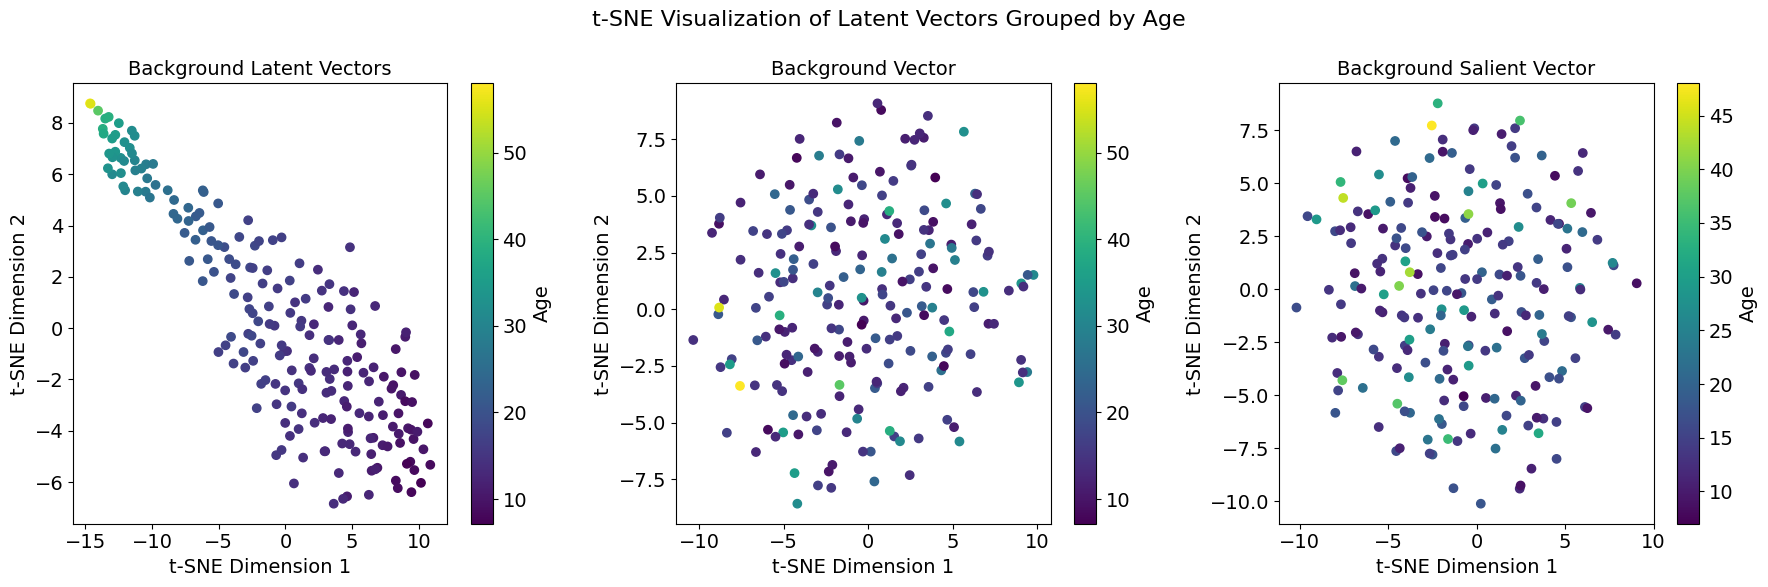

In [ ]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Common title
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by Age', fontsize=16)

# First subplot: Latent Vectors (z and s combined)
background_vectors = background_vectors_dict["latent_vec"].detach().cpu().numpy()
background_no_autism_vectors = background_no_autism_dict["latent_vec"].detach().cpu().numpy()
combined_vectors = np.hstack((background_vectors, background_no_autism_vectors, background_vectors_dict["age"].unsqueeze(1).detach().cpu().numpy()))
background_tsne = TSNE(n_components=2, random_state=42)
tsne_results_age_combined_2 = background_tsne.fit_transform(combined_vectors)
scatter = axs[0].scatter(tsne_results_age_combined_2[:, 0], tsne_results_age_combined_2[:, 1], c=background_vectors_dict["age"], cmap="viridis")
axs[0].set_title('Background Latent Vectors')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter, ax=axs[0], label="Age")

# Second subplot: Background Vectors (z vectors)
background_vectors = background_vectors_dict["latent_vec"].detach().cpu().numpy()
background_tsne = TSNE(n_components=2, random_state=42)
tsne_result_z_2 = background_tsne.fit_transform(background_vectors)
scatter_z = axs[1].scatter(tsne_result_z_2[:, 0], tsne_result_z_2[:, 1], c=background_vectors_dict["age"], cmap="viridis")
axs[1].set_title('Background Vector')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z, ax=axs[1], label="Age")

# Third subplot: Salient Vectors (s vectors)
background_no_autism_vectors = background_no_autism_dict["latent_vec"].detach().cpu().numpy()
background_tsne = TSNE(n_components=2, random_state=42)
tsne_result_s_2 = background_tsne.fit_transform(background_no_autism_vectors)
scatter_s = axs[2].scatter(tsne_result_s_2[:, 0], tsne_result_s_2[:, 1], c=background_no_autism_dict["age"], cmap="viridis")
axs[2].set_title('Background Salient Vector')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s, ax=axs[2], label="Age")

plt.tight_layout()
plt.show()

<ipython-input-105-9494977033c5>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("cool", 2)


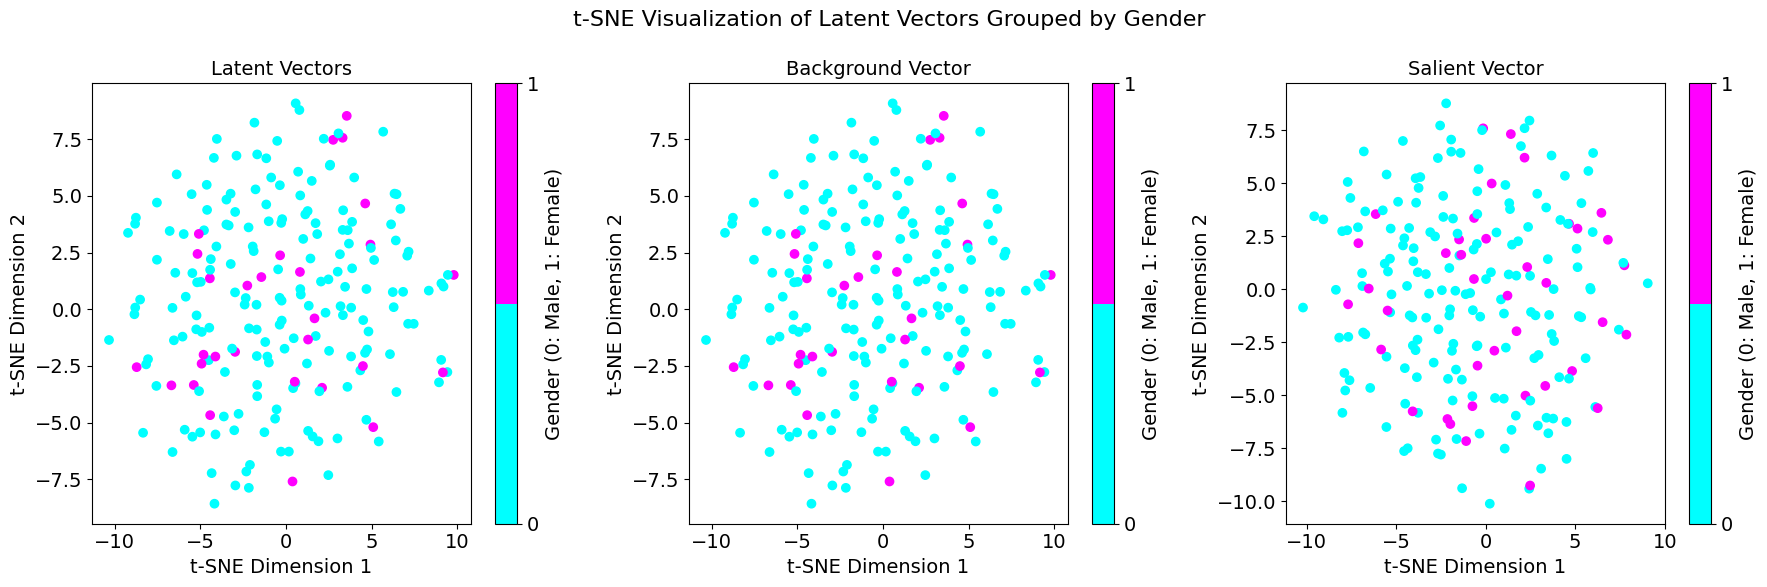

In [ ]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Common title
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by Gender', fontsize=16)

# First subplot: Latent Vectors (z and s combined)
combined_vectors = background_vectors_dict["latent_vec"].detach().cpu().numpy()
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(combined_vectors)
cmap = plt.cm.get_cmap("cool", 2)
scatter = axs[0].scatter(tsne_result[:, 0], tsne_result[:, 1], c=background_vectors_dict["gender"], cmap=cmap)
axs[0].set_title('Latent Vectors')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter, ax=axs[0], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)

# Second subplot: Background Vectors (z vectors)
background_vectors = background_vectors_dict["latent_vec"].detach().cpu().numpy()
tsne = TSNE(n_components=2, random_state=42)
tsne_result_z = tsne.fit_transform(background_vectors)
scatter_z = axs[1].scatter(tsne_result_z[:, 0], tsne_result_z[:, 1], c=background_vectors_dict["gender"], cmap=cmap)
axs[1].set_title('Background Vector')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z, ax=axs[1], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)

# Third subplot: Salient Vectors (s vectors)
background_no_autism_vectors = background_no_autism_dict["latent_vec"].detach().cpu().numpy()
tsne = TSNE(n_components=2, random_state=42)
tsne_result_s = tsne.fit_transform(background_no_autism_vectors)
scatter_s = axs[2].scatter(tsne_result_s[:, 0], tsne_result_s[:, 1], c=background_no_autism_dict["gender"], cmap=cmap)
axs[2].set_title('Salient Vector')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s, ax=axs[2], label="Gender (0: Male, 1: Female)", ticks=[0, 1], cmap=cmap)

plt.tight_layout()
plt.show()


Having performed t-SNE plots for the main variables of interest, let's briefly visualize this:

ValueError: ignored

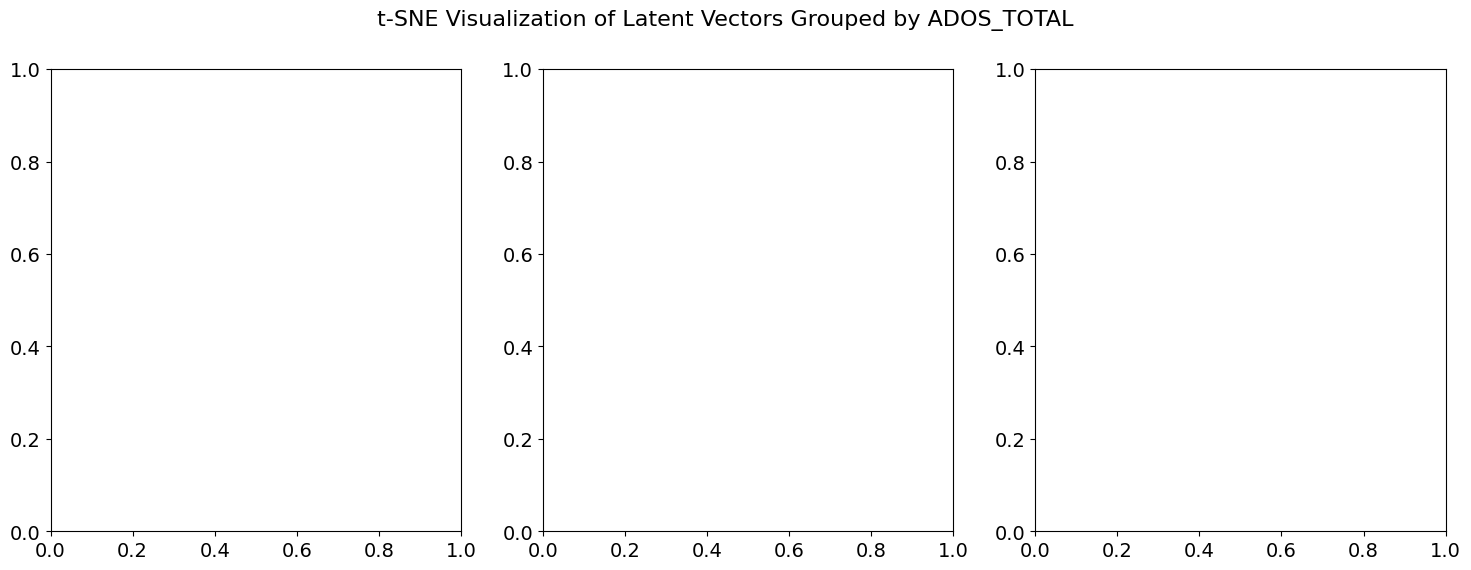

In [ ]:

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Common title
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by ADOS_TOTAL', fontsize=16)

# First subplot: Latent Vectors (z and s combined)
z_vectors = z_dict["latent_vec"].detach().cpu().numpy()
s_vectors = s_dict["latent_vec"].detach().cpu().numpy()
combined_vectors = np.hstack((z_vectors, s_vectors, z_dict["ADOS_TOTAL"].unsqueeze(1).detach().cpu().numpy()))
tsne_result_4 = tsne.fit_transform(combined_vectors)
scatter = axs[0].scatter(tsne_result_4[:, 0], tsne_result_4[:, 1], c=z_dict["ADOS_TOTAL"], cmap="viridis")
axs[0].set_title('Latent Vectors')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter, ax=axs[0], label="ADOS_TOTAL")

# Second subplot: Background Vectors (z vectors)
z_vectors = z_dict["latent_vec"].detach().cpu().numpy()
tsne = TSNE(n_components=2, random_state=42)
tsne_result_4_z = tsne.fit_transform(z_vectors)
scatter_z = axs[1].scatter(tsne_result_4_z[:, 0], tsne_result_4_z[:, 1], c=z_dict["ADOS_TOTAL"], cmap="viridis")
axs[1].set_title('Background Vector')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z, ax=axs[1], label="ADOS_TOTAL")

# Third subplot: Salient Vectors (s vectors)
s_vectors = s_dict["latent_vec"].detach().cpu().numpy()
tsne = TSNE(n_components=2, random_state=42)
tsne_result_4_s = tsne.fit_transform(s_vectors)
scatter_s = axs[2].scatter(tsne_result_4_s[:, 0], tsne_result_4_s[:, 1], c=z_dict["ADOS_TOTAL"], cmap="viridis")
axs[2].set_title('Salient Vector')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s, ax=axs[2], label="ADOS_TOTAL")

plt.tight_layout()
plt.show()


Next the ADOS social variable.

In [ ]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Common title
fig.suptitle('t-SNE Visualization of Latent Vectors Grouped by ADOS_SOCIAL', fontsize=16)

# First subplot: Latent Vectors (z and s combined)
z_vectors = z_dict["latent_vec"].detach().cpu().numpy()
s_vectors = s_dict["latent_vec"].detach().cpu().numpy()
combined_vectors = np.hstack((z_vectors, s_vectors, z_dict["ADOS_SOCIAL"].unsqueeze(1).detach().cpu().numpy()))
tsne = TSNE(n_components=2, random_state=42)
tsne_result_5 = tsne.fit_transform(combined_vectors)
scatter = axs[0].scatter(tsne_result_5[:, 0], tsne_result_5[:, 1], c=z_dict["ADOS_SOCIAL"], cmap="viridis")
axs[0].set_title('Latent Vectors')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter, ax=axs[0], label="ADOS_SOCIAL")

# Second subplot: Background Vectors (z vectors)
z_vectors = z_dict["latent_vec"].detach().cpu().numpy()
tsne = TSNE(n_components=2, random_state=42)
tsne_result_z_5 = tsne.fit_transform(z_vectors)
scatter_z = axs[1].scatter(tsne_result_z_5[:, 0], tsne_result_z_5[:, 1], c=z_dict["ADOS_SOCIAL"], cmap="viridis")
axs[1].set_title('Background Vector')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_z, ax=axs[1], label="ADOS_SOCIAL")

# Third subplot: Salient Vectors (s vectors)
s_vectors = s_dict["latent_vec"].detach().cpu().numpy()
tsne = TSNE(n_components=2, random_state=42)
tsne_result_s_5 = tsne.fit_transform(s_vectors)
scatter_s = axs[2].scatter(tsne_result_s_5[:, 0], tsne_result_s_5[:, 1], c=z_dict["ADOS_SOCIAL"], cmap="viridis")
axs[2].set_title('Salient Vector')
axs[2].set_xlabel('t-SNE Dimension 1')
axs[2].set_ylabel('t-SNE Dimension 2')
fig.colorbar(scatter_s, ax=axs[2], label="ADOS_SOCIAL")

plt.tight_layout()
plt.show()

## Classification Performance

### Confusion Matrix

A confusion matrix is a table that is often used to describe the performance of a classification model. It provides a summary of the model's predictions compared to the actual outcomes. In binary classification, the confusion matrix has the following format:

|                   | Predicted Positive | Predicted Negative |
|-------------------|--------------------|--------------------|
| Actual Positive   | True Positive (TP) | False Negative (FN)|
| Actual Negative   | False Positive (FP)| True Negative (TN) |

### Performance Metrics

Here are some key performance metrics derived from the confusion matrix:

- **Accuracy:** Accuracy is a measure of how many predictions were correct out of the total number of predictions. It's a ratio of the number of correct predictions to the total number of predictions.

- **Precision:** Precision is a measure of how many of the predicted positive instances were actually positive. It's a ratio of the true positives (TP) to the sum of true positives (TP) and false positives (FP).

- **Recall:** Recall, also known as sensitivity or true positive rate, is a measure of how many of the actual positive instances were correctly predicted as positive. It's a ratio of true positives (TP) to the sum of true positives (TP) and false negatives (FN).

- **F1 Score:** The F1 score is the harmonic mean of precision and recall. It provides a balance between precision and recall and is useful when the class distribution is imbalanced.

### How They Are Computed

You can compute these performance metrics using Python and libraries like scikit-learn. Here's a [link to the code](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) that demonstrates how to calculate Accuracy, Precision, Recall, and F1 Score from your model's predictions and the true labels.


In [ ]:
#!pip install bootstrapped
from sklearn.metrics import roc_auc_score, r2_score
from statsmodels.stats.proportion import proportion_confint
#from bootstrapped import bootstrap
from sklearn.utils import resample

# Initialize lists to store accuracy values, participant counts, and group-wise breakdown
accuracy_values = []
participant_counts = []

# Initialize dictionaries to store group-wise accuracy and ROC-AUC
accuracy_by_group = {
    'Autism': [],
    'No Autism': [],
}

r2_values = []

# Initialize a list to store all actual ages
all_actual_ages = []

# Initialize vectors to store true and predicted labels
true_labels_autism_age = []
predicted_labels_autism_age = []
true_labels_no_autism_age = []
predicted_labels_no_autism_age = []
true_labels_autism_gender = []
predicted_labels_autism_gender = []
true_labels_no_autism_gender = []
predicted_labels_no_autism_gender = []

# Set the model to evaluation mode
model_classifier.eval()
batch_iterator = iter(train_dataloader_no_batch)
# Iterate through the validation dataloader
for batch in batch_iterator:
    ((autism_data, autism_age, autism_gender, autism_diag_group, _,_,_,_,autism_sub_id), (no_autism_data, no_autism_age, no_autism_gender, no_autism_diag_group,_,no_autism_sub_id)) = batch
    # Move data to device if necessary
    autism_data = autism_data.to(device)
    no_autism_data = no_autism_data.to(device)

    # Generate predictions using the trained model
    _, _, _, _, _, _, _, _, class_autism_age, class_autism_gender, class_no_autism_age, class_no_autism_gender, _, _,_ = model_classifier(autism_data, no_autism_data)
    # Convert predicted probabilities to binary labels based on the threshold (0.5 in this case)
    predicted_labels_autism_gender_value = (class_autism_gender.cpu().detach().numpy() > 0.5).astype(int)
    predicted_labels_no_autism_gender_value = (class_no_autism_gender.cpu().detach().numpy() > 0.5).astype(int)

    # Append true and predicted labels for autism group
    true_labels_autism_age.extend([val for val in autism_age.cpu().detach().numpy()])
    predicted_labels_autism_age.extend([val for val in class_autism_age.cpu().detach().numpy()])

    true_labels_autism_gender.extend([var for var in autism_gender.cpu().detach().numpy()])
    predicted_labels_autism_gender.extend([val.tolist()[0] for val in predicted_labels_autism_gender_value])  # Convert to list of integers

    # Append true and predicted labels for no autism group
    true_labels_no_autism_age.extend([val for val in no_autism_age.cpu().detach().numpy()])
    predicted_labels_no_autism_age.extend([val for val in class_no_autism_age.cpu().detach().numpy()])

    true_labels_no_autism_gender.extend([val for val in no_autism_gender.cpu().detach().numpy()])
    predicted_labels_no_autism_gender.extend([val.tolist()[0] for val in predicted_labels_no_autism_gender_value])  # Convert to list of integers

    all_actual_ages.extend([val for val in autism_age.cpu().detach().numpy()])
    all_actual_ages.extend([val for val in no_autism_age.cpu().detach().numpy()])

# Age computations:
# Calculate accuracy for participants with autism
accuracy_autism = np.abs(np.array(true_labels_autism_age) - np.array(predicted_labels_autism_age)).mean()

# Calculate accuracy for participants without autism
accuracy_no_autism = np.abs(np.array(true_labels_no_autism_age) - np.array(predicted_labels_no_autism_age)).mean()small update on actigraph: having a meeting tomorrow with Katharina. Hope to get the pipeline done after. Could probably present the meeting after october 9th I hope?

# Calculate the total number of participants
num_participants = len(true_labels_autism_age) + len(true_labels_no_autism_age)

# Append accuracy and participant count to the lists
accuracy_values.append((accuracy_autism + accuracy_no_autism) / 2)  # Average accuracy for both groups
participant_counts.append(num_participants)

# Calculate R-squared for participants with autism
r2_autism = r2_score(true_labels_autism_age, predicted_labels_autism_age)
r2_values.append(r2_autism)

# Calculate R-squared for participants without autism
r2_no_autism = r2_score(true_labels_no_autism_age, predicted_labels_no_autism_age)
r2_values.append(r2_no_autism)

# Compute the standard deviation of actual ages
std_deviation_actual_ages = np.std(all_actual_ages)

# Compute the grand mean accuracy
weighted_sum = sum(accuracy * count for accuracy, count in zip(accuracy_values, participant_counts))
total_participants = sum(participant_counts)
grand_mean_accuracy = weighted_sum / total_participants

# Compute the grand mean R-squared
grand_mean_r2 = np.mean(r2_values)

# Calculate confidence interval for accuracy (e.g., 95% confidence)
proportions = [accuracy / 100.0 for accuracy in accuracy_values]
ci_accuracy = proportion_confint(sum(proportions), len(proportions), alpha=0.05, method='wilson')

# Calculate confidence interval for R-squared (e.g., 95% confidence)
lower_bound_r2 = np.percentile(r2_values, 2.5)
upper_bound_r2 = np.percentile(r2_values, 97.5)
ci_r2 = (lower_bound_r2, upper_bound_r2)


#Calculate statistics separately for Autism and No Autism groups
for group in ['Autism', 'No Autism']:
    # Calculate accuracy for participants in the group
    true_labels_group_age = true_labels_autism_age if group == 'Autism' else true_labels_no_autism_age
    predicted_labels_group_age = predicted_labels_autism_age if group == 'Autism' else predicted_labels_no_autism_age

    accuracy_group_age = np.abs(np.array(true_labels_group_age) - np.array(predicted_labels_group_age)).mean()
    accuracy_by_group[group].append(accuracy_group_age)

    # Calculate R-squared for participants in the group
    r2_group_age = r2_score(true_labels_group_age, predicted_labels_group_age)
    r2_values.append(r2_group_age)

# Print results
print("Results for Age Prediction:")
print("-" * 30)
print("Standard Deviation of Actual Ages:", std_deviation_actual_ages)
print("Grand Mean Accuracy (Age Prediction):", grand_mean_accuracy)
print("Grand Mean R-squared (Age Prediction):", grand_mean_r2)

# Print group-wise accuracy values
for group, group_accuracies in accuracy_by_group.items():
    group_mean_accuracy = sum(group_accuracies) / len(group_accuracies)
    print(f"{group} Mean Accuracy (Age Prediction):", group_mean_accuracy)

print("\n")

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Compute confusion matrix and related metrics for gender prediction
confusion_matrix_autism_gender = confusion_matrix(true_labels_autism_gender, predicted_labels_autism_gender)
confusion_matrix_no_autism_gender = confusion_matrix(true_labels_no_autism_gender, predicted_labels_no_autism_gender)

# Define a function to compute and print metrics
def print_metrics(confusion_matrix, group_name):
    tn, fp, fn, tp = confusion_matrix.ravel()
    true_labels = true_labels_autism_gender if group_name == 'Autism' else true_labels_no_autism_gender
    predicted_labels = predicted_labels_autism_gender if group_name == 'Autism' else predicted_labels_no_autism_gender
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Set zero_division=0 to suppress the warning and assign precision to 0 when no samples are predicted
    precision = precision_score(true_labels, predicted_labels, zero_division=0)

    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    print(f"Metrics for {group_name} Gender Prediction:")
    print(f"Confusion Matrix:\n{confusion_matrix}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Print metrics for autism group
print_metrics(confusion_matrix_autism_gender, 'Autism')

# Print metrics for no autism group
print_metrics(confusion_matrix_no_autism_gender, 'No Autism')


Results for Age Prediction:
------------------------------
Standard Deviation of Actual Ages: 8.110835
Grand Mean Accuracy (Age Prediction): 6.443785190582275
Grand Mean R-squared (Age Prediction): 0.10197793201610605
Autism Mean Accuracy (Age Prediction): 7.092670917510986
No Autism Mean Accuracy (Age Prediction): 5.7948994636535645


Metrics for Autism Gender Prediction:
Confusion Matrix:
[[179   0]
 [ 29   0]]
Accuracy: 0.8606
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Metrics for No Autism Gender Prediction:
Confusion Matrix:
[[169   0]
 [ 39   0]]
Accuracy: 0.8125
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


Next the sample used for validation

In [ ]:
#!pip install bootstrapped
from sklearn.metrics import roc_auc_score, r2_score
from statsmodels.stats.proportion import proportion_confint
#from bootstrapped import bootstrap
from sklearn.utils import resample

# Initialize lists to store accuracy values, participant counts, and group-wise breakdown
accuracy_values = []
participant_counts = []

# Initialize dictionaries to store group-wise accuracy and ROC-AUC
accuracy_by_group = {
    'Autism': [],
    'No Autism': [],
}

r2_values = []

# Initialize a list to store all actual ages
all_actual_ages = []

# Initialize vectors to store true and predicted labels
true_labels_autism_age = []
predicted_labels_autism_age = []
true_labels_no_autism_age = []
predicted_labels_no_autism_age = []
true_labels_autism_gender = []
predicted_labels_autism_gender = []
true_labels_no_autism_gender = []
predicted_labels_no_autism_gender = []

# Set the model to evaluation mode
model_classifier.eval()
batch_iterator = iter(val_dataloader_no_batch)
# Iterate through the validation dataloader
for batch in batch_iterator:
    ((autism_data, autism_age, autism_gender, autism_diag_group, _,_,_,_,autism_sub_id), (no_autism_data, no_autism_age, no_autism_gender, no_autism_diag_group,_,no_autism_sub_id)) = batch
    # Move data to device if necessary
    autism_data = autism_data.to(device)
    no_autism_data = no_autism_data.to(device)

    # Generate predictions using the trained model
    _, _, _, _, _, _, _, _, class_autism_age, class_autism_gender, class_no_autism_age, class_no_autism_gender, _, _,_ = model_classifier(autism_data, no_autism_data)

    # Convert predicted probabilities to binary labels based on the threshold (0.5 in this case)
    predicted_labels_autism_gender_value = (class_autism_gender.cpu().detach().numpy() > 0.5).astype(int)
    predicted_labels_no_autism_gender_value = (class_no_autism_gender.cpu().detach().numpy() > 0.5).astype(int)

    # Append true and predicted labels for autism group
    true_labels_autism_age.extend([val for val in autism_age.cpu().detach().numpy()])
    predicted_labels_autism_age.extend([val for val in class_autism_age.cpu().detach().numpy()])

    true_labels_autism_gender.extend([var for var in autism_gender.cpu().detach().numpy()])
    predicted_labels_autism_gender.extend([val.tolist()[0] for val in predicted_labels_autism_gender_value])  # Convert to list of integers

    # Append true and predicted labels for no autism group
    true_labels_no_autism_age.extend([val for val in no_autism_age.cpu().detach().numpy()])
    predicted_labels_no_autism_age.extend([val for val in class_no_autism_age.cpu().detach().numpy()])

    true_labels_no_autism_gender.extend([val for val in no_autism_gender.cpu().detach().numpy()])
    predicted_labels_no_autism_gender.extend([val.tolist()[0] for val in predicted_labels_no_autism_gender_value])  # Convert to list of integers

    all_actual_ages.extend([val for val in autism_age.cpu().detach().numpy()])
    all_actual_ages.extend([val for val in no_autism_age.cpu().detach().numpy()])

# Age computations:
# Calculate accuracy for participants with autism
accuracy_autism = np.abs(np.array(true_labels_autism_age) - np.array(predicted_labels_autism_age)).mean()

# Calculate accuracy for participants without autism
accuracy_no_autism = np.abs(np.array(true_labels_no_autism_age) - np.array(predicted_labels_no_autism_age)).mean()

# Calculate the total number of participants
num_participants = len(true_labels_autism_age) + len(true_labels_no_autism_age)

# Append accuracy and participant count to the lists
accuracy_values.append((accuracy_autism + accuracy_no_autism) / 2)  # Average accuracy for both groups
participant_counts.append(num_participants)

# Calculate R-squared for participants with autism
r2_autism = r2_score(true_labels_autism_age, predicted_labels_autism_age)
r2_values.append(r2_autism)

# Calculate R-squared for participants without autism
r2_no_autism = r2_score(true_labels_no_autism_age, predicted_labels_no_autism_age)
r2_values.append(r2_no_autism)

# Compute the standard deviation of actual ages
std_deviation_actual_ages = np.std(all_actual_ages)

# Compute the grand mean accuracy
weighted_sum = sum(accuracy * count for accuracy, count in zip(accuracy_values, participant_counts))
total_participants = sum(participant_counts)
grand_mean_accuracy = weighted_sum / total_participants

# Compute the grand mean R-squared
grand_mean_r2 = np.mean(r2_values)

# Calculate confidence interval for accuracy (e.g., 95% confidence)
proportions = [accuracy / 100.0 for accuracy in accuracy_values]
ci_accuracy = proportion_confint(sum(proportions), len(proportions), alpha=0.05, method='wilson')

# Calculate confidence interval for R-squared (e.g., 95% confidence)
lower_bound_r2 = np.percentile(r2_values, 2.5)
upper_bound_r2 = np.percentile(r2_values, 97.5)
ci_r2 = (lower_bound_r2, upper_bound_r2)


#Calculate statistics separately for Autism and No Autism groups
for group in ['Autism', 'No Autism']:
    # Calculate accuracy for participants in the group
    true_labels_group_age = true_labels_autism_age if group == 'Autism' else true_labels_no_autism_age
    predicted_labels_group_age = predicted_labels_autism_age if group == 'Autism' else predicted_labels_no_autism_age

    accuracy_group_age = np.abs(np.array(true_labels_group_age) - np.array(predicted_labels_group_age)).mean()
    accuracy_by_group[group].append(accuracy_group_age)

    # Calculate R-squared for participants in the group
    r2_group_age = r2_score(true_labels_group_age, predicted_labels_group_age)
    r2_values.append(r2_group_age)

# Print results
print("Results for Age Prediction:")
print("-" * 30)
print("Standard Deviation of Actual Ages:", std_deviation_actual_ages)
print("Grand Mean Accuracy (Age Prediction):", grand_mean_accuracy)
print("Grand Mean R-squared (Age Prediction):", grand_mean_r2)

# Print group-wise accuracy values
for group, group_accuracies in accuracy_by_group.items():
    group_mean_accuracy = sum(group_accuracies) / len(group_accuracies)
    print(f"{group} Mean Accuracy (Age Prediction):", group_mean_accuracy)

print("\n")

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Compute confusion matrix and related metrics for gender prediction
confusion_matrix_autism_gender = confusion_matrix(true_labels_autism_gender, predicted_labels_autism_gender)
confusion_matrix_no_autism_gender = confusion_matrix(true_labels_no_autism_gender, predicted_labels_no_autism_gender)

# Define a function to compute and print metrics
def print_metrics(confusion_matrix, group_name):
    tn, fp, fn, tp = confusion_matrix.ravel()
    true_labels = true_labels_autism_gender if group_name == 'Autism' else true_labels_no_autism_gender
    predicted_labels = predicted_labels_autism_gender if group_name == 'Autism' else predicted_labels_no_autism_gender
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Set zero_division=0 to suppress the warning and assign precision to 0 when no samples are predicted
    precision = precision_score(true_labels, predicted_labels, zero_division=0)

    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    print(f"Metrics for {group_name} Gender Prediction:")
    print(f"Confusion Matrix:\n{confusion_matrix}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Print metrics for autism group
print_metrics(confusion_matrix_autism_gender, 'Autism')

# Print metrics for no autism group
print_metrics(confusion_matrix_no_autism_gender, 'No Autism')


Results for Age Prediction:
------------------------------
Standard Deviation of Actual Ages: 8.230031
Grand Mean Accuracy (Age Prediction): 6.344203948974609
Grand Mean R-squared (Age Prediction): 0.06784448926130415
Autism Mean Accuracy (Age Prediction): 6.469361305236816
No Autism Mean Accuracy (Age Prediction): 6.219046592712402


Metrics for Autism Gender Prediction:
Confusion Matrix:
[[140   0]
 [ 16   0]]
Accuracy: 0.8974
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Metrics for No Autism Gender Prediction:
Confusion Matrix:
[[130   0]
 [ 26   0]]
Accuracy: 0.8333
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


Next the test-set!

In [ ]:
#!pip install bootstrapped
from sklearn.metrics import r2_score
from statsmodels.stats.proportion import proportion_confint
#from bootstrapped import bootstrap
from sklearn.utils import resample

# Initialize lists to store accuracy values, participant counts, and group-wise breakdown
accuracy_values = []
participant_counts = []

# Initialize dictionaries to store group-wise accuracy and ROC-AUC
accuracy_by_group = {
    'Autism': [],
    'No Autism': [],
}

r2_values = []

# Initialize a list to store all actual ages
all_actual_ages = []

# Initialize vectors to store true and predicted labels
true_labels_autism_age = []
predicted_labels_autism_age = []
true_labels_no_autism_age = []
predicted_labels_no_autism_age = []
true_labels_autism_gender = []
predicted_labels_autism_gender = []
true_labels_no_autism_gender = []
predicted_labels_no_autism_gender = []

# Set the model to evaluation mode
model_classifier.eval()
batch_iterator = iter(test_dataloader_no_batch)
# Iterate through the validation dataloader
for batch in batch_iterator:
    ((autism_data, autism_age, autism_gender, autism_diag_group, _,_,_,_,autism_sub_id), (no_autism_data, no_autism_age, no_autism_gender, no_autism_diag_group,_,no_autism_sub_id)) = batch
    # Move data to device if necessary
    autism_data = autism_data.to(device)
    no_autism_data = no_autism_data.to(device)

    # Generate predictions using the trained model
    _, _, _, _, _, _, _, _, class_autism_age, class_autism_gender, class_no_autism_age, class_no_autism_gender, _, _,_ = model_classifier(autism_data, no_autism_data)

    # Convert predicted probabilities to binary labels based on the threshold (0.5 in this case)
    predicted_labels_autism_gender_value = (class_autism_gender.cpu().detach().numpy() > 0.5).astype(int)
    predicted_labels_no_autism_gender_value = (class_no_autism_gender.cpu().detach().numpy() > 0.5).astype(int)

    # Append true and predicted labels for autism group
    true_labels_autism_age.extend([val for val in autism_age.cpu().detach().numpy()])
    predicted_labels_autism_age.extend([val for val in class_autism_age.cpu().detach().numpy()])

    true_labels_autism_gender.extend([var for var in autism_gender.cpu().detach().numpy()])
    predicted_labels_autism_gender.extend([val.tolist()[0] for val in predicted_labels_autism_gender_value])  # Convert to list of integers

    # Append true and predicted labels for no autism group
    true_labels_no_autism_age.extend([val for val in no_autism_age.cpu().detach().numpy()])
    predicted_labels_no_autism_age.extend([val for val in class_no_autism_age.cpu().detach().numpy()])

    true_labels_no_autism_gender.extend([val for val in no_autism_gender.cpu().detach().numpy()])
    predicted_labels_no_autism_gender.extend([val.tolist()[0] for val in predicted_labels_no_autism_gender_value])  # Convert to list of integers

    all_actual_ages.extend([val for val in autism_age.cpu().detach().numpy()])
    all_actual_ages.extend([val for val in no_autism_age.cpu().detach().numpy()])

# Age computations:
# Calculate accuracy for participants with autism
accuracy_autism = np.abs(np.array(true_labels_autism_age) - np.array(predicted_labels_autism_age)).mean()

# Calculate accuracy for participants without autism
accuracy_no_autism = np.abs(np.array(true_labels_no_autism_age) - np.array(predicted_labels_no_autism_age)).mean()

# Calculate the total number of participants
num_participants = len(true_labels_autism_age) + len(true_labels_no_autism_age)

# Append accuracy and participant count to the lists
accuracy_values.append((accuracy_autism + accuracy_no_autism) / 2)  # Average accuracy for both groups
participant_counts.append(num_participants)

# Calculate R-squared for participants with autism
r2_autism = r2_score(true_labels_autism_age, predicted_labels_autism_age)
r2_values.append(r2_autism)

# Calculate R-squared for participants without autism
r2_no_autism = r2_score(true_labels_no_autism_age, predicted_labels_no_autism_age)
r2_values.append(r2_no_autism)

# Compute the standard deviation of actual ages
std_deviation_actual_ages = np.std(all_actual_ages)

# Compute the grand mean accuracy
weighted_sum = sum(accuracy * count for accuracy, count in zip(accuracy_values, participant_counts))
total_participants = sum(participant_counts)
grand_mean_accuracy = weighted_sum / total_participants

# Compute the grand mean R-squared
grand_mean_r2 = np.mean(r2_values)

# Calculate confidence interval for accuracy (e.g., 95% confidence)
proportions = [accuracy / 100.0 for accuracy in accuracy_values]
ci_accuracy = proportion_confint(sum(proportions), len(proportions), alpha=0.05, method='wilson')

# Calculate confidence interval for R-squared (e.g., 95% confidence)
lower_bound_r2 = np.percentile(r2_values, 2.5)
upper_bound_r2 = np.percentile(r2_values, 97.5)
ci_r2 = (lower_bound_r2, upper_bound_r2)


#Calculate statistics separately for Autism and No Autism groups
for group in ['Autism', 'No Autism']:
    # Calculate accuracy for participants in the group
    true_labels_group_age = true_labels_autism_age if group == 'Autism' else true_labels_no_autism_age
    predicted_labels_group_age = predicted_labels_autism_age if group == 'Autism' else predicted_labels_no_autism_age

    accuracy_group_age = np.abs(np.array(true_labels_group_age) - np.array(predicted_labels_group_age)).mean()
    accuracy_by_group[group].append(accuracy_group_age)

    # Calculate R-squared for participants in the group
    r2_group_age = r2_score(true_labels_group_age, predicted_labels_group_age)
    r2_values.append(r2_group_age)

# Print results
print("Results for Age Prediction:")
print("-" * 30)
print("Standard Deviation of Actual Ages:", std_deviation_actual_ages)
print("Grand Mean Accuracy (Age Prediction):", grand_mean_accuracy)
print("Grand Mean R-squared (Age Prediction):", grand_mean_r2)

# Print group-wise accuracy values
for group, group_accuracies in accuracy_by_group.items():
    group_mean_accuracy = sum(group_accuracies) / len(group_accuracies)
    print(f"{group} Mean Accuracy (Age Prediction):", group_mean_accuracy)

print("\n")

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Compute confusion matrix and related metrics for gender prediction
confusion_matrix_autism_gender = confusion_matrix(true_labels_autism_gender, predicted_labels_autism_gender)
confusion_matrix_no_autism_gender = confusion_matrix(true_labels_no_autism_gender, predicted_labels_no_autism_gender)

# Define a function to compute and print metrics
def print_metrics(confusion_matrix, group_name):
    tn, fp, fn, tp = confusion_matrix.ravel()
    true_labels = true_labels_autism_gender if group_name == 'Autism' else true_labels_no_autism_gender
    predicted_labels = predicted_labels_autism_gender if group_name == 'Autism' else predicted_labels_no_autism_gender
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Set zero_division=0 to suppress the warning and assign precision to 0 when no samples are predicted
    precision = precision_score(true_labels, predicted_labels, zero_division=0)

    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    print(f"Metrics for {group_name} Gender Prediction:")
    print(f"Confusion Matrix:\n{confusion_matrix}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Print metrics for autism group
print_metrics(confusion_matrix_autism_gender, 'Autism')

# Print metrics for no autism group
print_metrics(confusion_matrix_no_autism_gender, 'No Autism')


Results for Age Prediction:
------------------------------
Standard Deviation of Actual Ages: 7.0671344
Grand Mean Accuracy (Age Prediction): 6.158263206481934
Grand Mean R-squared (Age Prediction): 0.043873541780266256
Autism Mean Accuracy (Age Prediction): 6.546976566314697
No Autism Mean Accuracy (Age Prediction): 5.76954984664917


Metrics for Autism Gender Prediction:
Confusion Matrix:
[[131   0]
 [ 25   0]]
Accuracy: 0.8397
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Metrics for No Autism Gender Prediction:
Confusion Matrix:
[[124   0]
 [ 32   0]]
Accuracy: 0.7949
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


## Cortical Thickness Analyses

To plot the differences in cortical thickness, I first need to generate cortical thickness measures. For this, I am interested specifically interested in what the "ASD" part of the model will do. Thus, what difference in cortical thickness arises when turning the specific encoder on!

In [ ]:
# Initialize dictionaries to store reconstructed data for each encoder
reconstructed_data_encoder_z0 = {}
reconstructed_data_encoder_zs = {}

# Set the model to evaluation mode
model_classifier.eval()
batch_iterator = iter(val_dataloader_no_batch)
batch = next(batch_iterator)

# Iterate through the validation dataloader
for i in range(1, 10):
    ((autism_data, autism_age, autism_gender, autism_diag_group, _,_,_,_,autism_sub_id), (no_autism_data, no_autism_age, no_autism_gender, no_autism_diag_group,_,no_autism_sub_id)) = batch
    batch_size = autism_data.shape[0]

    # Compute the reconstructed data for encoder_z
    z_mean, z_log_var = model_classifier.encoder_z(autism_data, batch_size)
    latent_z = model_classifier.reparameterize(z_mean, z_log_var)

    # Compute the reconstructed data for encoder_s
    s_mean, s_log_var = model_classifier.encoder_s(autism_data, batch_size)
    latent_s = model_classifier.reparameterize(s_mean, s_log_var)

    latent_zs = torch.cat([latent_z, latent_s], dim=1)
    reconstructed_data_batch_zs = model_classifier.decoder(latent_zs, batch_size).detach()

    latent_z_0 = torch.cat([latent_z, torch.zeros_like(latent_z)], dim=1)
    reconstructed_data_batch_z0 = model_classifier.decoder(latent_z_0, batch_size).detach()

    # Update the dictionaries for encoder_z and encoder_s
    for sub_id, recon_data_zs, recon_data_z0 in zip(autism_sub_id, reconstructed_data_batch_zs, reconstructed_data_batch_z0):
        if sub_id not in reconstructed_data_encoder_zs:
            reconstructed_data_encoder_zs[sub_id] = []
        if sub_id not in reconstructed_data_encoder_z0:
            reconstructed_data_encoder_z0[sub_id] = []
        reconstructed_data_encoder_zs[sub_id].append(recon_data_zs)
        reconstructed_data_encoder_z0[sub_id].append(recon_data_z0)


Let's get an average per participant

In [ ]:
# Initialize dictionaries to store averaged reconstructed data for each encoder
averaged_reconstructed_data_encoder_z0 = {}
averaged_reconstructed_data_encoder_zs = {}

# Iterate through the dictionaries of reconstructed data
for sub_id, recon_data_zs_list, recon_data_z0_list in zip(reconstructed_data_encoder_zs.keys(), reconstructed_data_encoder_zs.values(), reconstructed_data_encoder_z0.values()):
    # Calculate the average for encoder_zs
    average_recon_data_zs = torch.stack(recon_data_zs_list).mean(dim=0)

    # Calculate the average for encoder_z0
    average_recon_data_z0 = torch.stack(recon_data_z0_list).mean(dim=0)

    # Store the averaged data in the new dictionaries
    averaged_reconstructed_data_encoder_zs[sub_id] = average_recon_data_zs
    averaged_reconstructed_data_encoder_z0[sub_id] = average_recon_data_z0


# Creating 1D arrays
# Initialize dictionaries to store 1D arrays for each encoder
averaged_reconstructed_data_encoder_z0_1d = {}
averaged_reconstructed_data_encoder_zs_1d = {}

# Iterate through the dictionaries of averaged reconstructed data
for sub_id, average_recon_data_zs, average_recon_data_z0 in zip(averaged_reconstructed_data_encoder_zs.keys(), averaged_reconstructed_data_encoder_zs.values(), averaged_reconstructed_data_encoder_z0.values()):
    # Convert the tensors to NumPy arrays and reshape them to 1D
    recon_data_zs_1d = average_recon_data_zs.cpu().detach().numpy().reshape(-1)
    recon_data_z0_1d = average_recon_data_z0.cpu().detach().numpy().reshape(-1)

    # Store the 1D arrays in the new dictionaries
    averaged_reconstructed_data_encoder_zs_1d[sub_id] = recon_data_zs_1d
    averaged_reconstructed_data_encoder_z0_1d[sub_id] = recon_data_z0_1d


from nilearn.datasets import fetch_atlas_destrieux_2009
from nilearn.image import load_img
from nilearn.maskers import NiftiLabelsMasker
from nilearn.masking import unmask


atlas_destrieux_dataset = fetch_atlas_destrieux_2009(lateralized = True)
atlas_destrieux = load_img(atlas_destrieux_dataset.maps)
masker_destrieux = NiftiLabelsMasker(labels_img=atlas_destrieux)
masker_destrieux.fit()

# Initialize dictionaries to store unmasked data for each encoder
unmasked_reconstructed_data_encoder_z0 = {}
unmasked_reconstructed_data_encoder_zs = {}

# Iterate through the dictionaries of 1D arrays
for sub_id, recon_data_zs_1d, recon_data_z0_1d in zip(averaged_reconstructed_data_encoder_zs_1d.keys(), averaged_reconstructed_data_encoder_zs_1d.values(), averaged_reconstructed_data_encoder_z0_1d.values()):
    # Convert the 1D arrays back to 3D images using unmask with the masker
    recon_data_zs_img = masker_destrieux.inverse_transform(recon_data_zs_1d)
    recon_data_z0_img = masker_destrieux.inverse_transform(recon_data_z0_1d)

    # Store the unmasked images in the new dictionaries
    unmasked_reconstructed_data_encoder_zs[sub_id] = recon_data_zs_img
    unmasked_reconstructed_data_encoder_z0[sub_id] = recon_data_z0_img


Let's save this:

In [ ]:
from google.colab import drive
import os

# Mount Google Drive to access your Drive files
drive.mount('/content/drive')

# Define the directory path in your Google Drive where you want to save the data
save_dir = '/content/drive/MyDrive/MasterThesisData/preprocessed'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save unmasked_reconstructed_data_encoder_z0
for sub_id, data in unmasked_reconstructed_data_encoder_z0.items():
    filename = f'unmasked_reconstructed_data_encoder_z0_{sub_id}.nii.gz'
    filepath = os.path.join(save_dir, filename)
    data.to_filename(filepath)

# Save unmasked_reconstructed_data_encoder_zs
for sub_id, data in unmasked_reconstructed_data_encoder_zs.items():
    filename = f'unmasked_reconstructed_data_encoder_zs_{sub_id}.nii.gz'
    filepath = os.path.join(save_dir, filename)
    data.to_filename(filepath)


Let's plot the average difference per participant

In [ ]:
# Compute the element-wise mean across all participants for encoder_z0
mean_reconstructed_data_encoder_z0 = np.mean([arr for arr in averaged_reconstructed_data_encoder_z0_1d.values()], axis=0)

# Compute the element-wise mean across all participants for encoder_zs
mean_reconstructed_data_encoder_zs = np.mean([arr for arr in averaged_reconstructed_data_encoder_zs_1d.values()], axis=0)

from nilearn.datasets import fetch_atlas_destrieux_2009
from nilearn.image import load_img
from nilearn.maskers import NiftiLabelsMasker
from nilearn.masking import unmask


atlas_destrieux_dataset = fetch_atlas_destrieux_2009(lateralized = True)
atlas_destrieux = load_img(atlas_destrieux_dataset.maps)
masker_destrieux = NiftiLabelsMasker(labels_img=atlas_destrieux)
masker_destrieux.fit()


mean_reconstructed_image_encoder_z0 = masker_destrieux.inverse_transform(mean_reconstructed_data_encoder_z0)
mean_reconstructed_image_encoder_zs = masker_destrieux.inverse_transform(mean_reconstructed_data_encoder_zs)

In [ ]:
import nibabel as nib
import nilearn.plotting as plotting

# Load the Nifti images (mean_reconstructed_image_encoder_z0 and mean_reconstructed_image_encoder_zs)
# These should already be loaded Nifti images
# For example:
# mean_reconstructed_image_encoder_z0 = nib.load('path_to_z0_image.nii')
# mean_reconstructed_image_encoder_zs = nib.load('path_to_zs_image.nii')

# Load the Destrieux atlas
atlas_destrieux_dataset = fetch_atlas_destrieux_2009(lateralized=True)
atlas_destrieux = load_img(atlas_destrieux_dataset.maps)

# Compute the difference
difference_data = mean_reconstructed_image_encoder_z0.get_fdata() - mean_reconstructed_image_encoder_zs.get_fdata()

# Create a new Nifti image for the difference data
difference_image = nib.Nifti1Image(difference_data, mean_reconstructed_image_encoder_z0.affine)

# Display the difference image on top of the atlas
plotting.plot_stat_map(
    difference_image,
    bg_img=atlas_destrieux,
    title="Difference Image on Atlas",
    display_mode='z',  # You can choose different display modes
    cut_coords=[-40, -20, 0, 20, 40],  # Specify coordinates to display
    colorbar=True,
    cmap='RdBu_r',  # Choose a colormap
)

plotting.show()

plotting.plot_stat_map(
    difference_image,
    title="Difference Image",
    display_mode='z',  # You can choose different display modes
    cut_coords=[-40, -20, 0, 20, 40],  # Specify coordinates to display
    colorbar=True,
    cmap='RdBu_r',  # Choose a colormap
)

plotting.show()